np.empty([m,n]):m by n empty mtx
norm.cdf(n) : -infinity ~ n cdf


**Functional API vs Sequential API**

1. Sequential API

  model = Sequential()
  '레이어가 1줄로 일렬로 연결되는 경우'
  대개, 입력층이 1열, 흐름이 x->layer1->layer2->output


2. Functional API

  model = keras.Model(inputs = my_input, outputs = my_output)
  multi input, multi output이나 중간에서 갈라졌다 합쳐지는 구조(branch,merge등)
  잔차연결(skip/residual)같은 비선형 토폴로지 등


중요한 차이는 Functional API는 INPUT이 될 TENSOR에 대한 명확한 정의가 있어야함.

예컨대 Sequential API에선,

model = Sequential()
model.add(Dense(1, activation = 'Relu', name = 'output'))으로만 써도, Sequential이 자동적으로 '암묵적 input tensor를 지정해주고 연결해줘서'문제가 없지만,

 output = keras.Dense(1, activation = 'Relu', name = 'output')라고 쓰고,

model = Model(inputs = ['hedge_cost', 'price'], outputs = output)이렇게 하면

"output이 있긴한데 저새끼가 뭐 받는건지 정확히 정의가 안되어있었는데?"

일케됨.

 output = keras.Dense(1, activation = 'Relu', name = 'output')(input_vec)


 이렇게 '입력 텐서는 얘로 할게' 가 있어야만 가능

In [ ]:
# Pytorch Update

'''

# 1. 기존 버전 삭제 및 호환 버전 재설치
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 --upgrade --force-reinstall

# 2. 설치 후 런타임 재시작 필수! (아래 코드 실행)
import os
os.kill(os.getpid(), 9)

'''

In [1]:
import sympy
if sympy.__version__ != "1.12":
    print("SymPy 버전 불일치 감지 (1.12 권장). 재설치를 진행합니다...")
    !pip install "sympy==1.12"
    print("설치 완료. 런타임을 재시작한 후 다시 실행해주세요.")
    # 이후 로직 중단 혹은 경고

ModuleNotFoundError: No module named 'sympy'

In [ ]:
!pip install arch

In [ ]:
#!pip install yfinance

In [ ]:
pip install -U finance-datareader

In [ ]:
import FinanceDataReader as fdr

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import seaborn as sns
import torch.optim as optim
import torch.nn as nn
import math

from google.colab import files
from scipy.stats import norm
from tensorflow import keras

#keras regression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras import optimizers



In [ ]:
r =0.00
sig = 0.2
T= 30/365 #Maturity

M = 100 # 시나리오 개수
N = 500 #시간 나누는 개수


dt = T/N #1 day
rdt = r*dt
sigsdt = sig * np.sqrt(dt)

In [ ]:
S0 = 100


S = np.empty([M,N+1]) #N+1인 이유는오늘은 t=0으로 할 거기 때문
'''
rng = np.random.default_rng(seed=42)
rv = rng.normal(rdt, sigsdt, size=(M, N))
'''
np.random.seed(100)
rv = np.random.normal(rdt,sigsdt,(M,N))
# rv = GBM & risk-neutral prob 하, dlns_t인 동시에 return: ds_t/s_t
# np.random.noraml은 (Mean, **sd**, mtx size)로 생성하고,각 element는 랜덤하게 그런 분포에서 뽑아낸 값임.

In [ ]:
for i in range(M):
  S[i,0] = S0
  for j in range(N):
    S[i,j+1] = S[i,j] * (1+rv[i,j])


In [ ]:
for i in range(M):
  plt.plot(S[i,:])

plt.tight_layout()
plt.show()
print(pd.Series(S[:,-1]).describe())

In [ ]:
m=1
K = 100

hedge=0
cost = 0

with_hedge_pf = []
with_hedge_pf_cum = []
without_hedge_pf = []
without_hedge_pf_cum = []
call_price = []

for j in range(N):
  tow = T - j*dt
  d1 = (np.log(S[m,j]/K) + (r+0.5*sig**2)*tow)/(sig*np.sqrt(tow))
  d2 = d1 - sig*np.sqrt(tow)
  delta = norm.cdf(d1)
  cost = cost + S[m,j]*(delta - hedge)
  call = S[m,j]*norm.cdf(d1) - K*np.exp(-r*tow)*norm.cdf(d2)
  call_price.append(call)

  #with hedge profit




  #without hedge profit
  if j == 0:
    without_hedge_pf.append(0)
  else:
    without_hedge_pf.append(call_price[j-1] - call_price[j])

  without_hedge_pf_cum.append(sum(without_hedge_pf))

  if str(j)[-1] ==  '9' or j == 0:
    print(f'{m+1}번째 시나리오, {j}시점: \n 주가: {S[m,j]:.5f},delta: {delta}, delta 변화분: {delta - hedge}, hedge cost: {cost}')



  hedge = delta # hedge= delta_t-1 -> delta-hedge = Δholding





print(np.array(without_hedge_pf))
print('-'*15)
print(np.array(without_hedge_pf_cum))
print('-'*15)
print(np.array(call_price))

In [ ]:
final_cost = []

for i in range(M):
  cost = 0
  hedge = 0
  for j in range(N):
    tow = T - j*dt
    d1 = (np.log(S[i,j]/K) + (r+0.5*sig**2)*tow)/(sig*np.sqrt(tow))
    d2 = d1 - sig*np.sqrt(tow)
    delta = norm.cdf(d1)
    cost = cost + S[i,j]*(hedge- delta)
    hedge = delta
  if S[i,N] > K:
    cost = cost + (hedge-1)*S[i,N] + K
  else:
    cost = cost + (hedge-0)*S[i,N]


  final_cost.append(cost)

print(pd.Series(final_cost).idxmax())

plt.hist(final_cost,bins = 30)
plt.show()

# 딥 헤징 2부

In [ ]:
r = 0.00
sig = 0.2
T = 30/365

M = 20000
N = 30

dt = T/N
rdt = r * dt
sigsdt = sig * np.sqrt(dt)

In [ ]:
np.random.seed(1234)
S0 = 100

S = np.empty([M,N+1])
S[:,0] =   S0 #np.full((1000,),S0) 둘다 똑같음

rv = np.random.normal(rdt,sigsdt,(M,N))

In [ ]:
for i in range(M):
  for j in range(N):
    S[i,j+1] = S[i,j] * (1+rv[i,j])

In [ ]:
for i in range(M):
  plt.plot(S[i,:])

plt.tight_layout()
plt.show()

$(\Delta_0 - 0) S_0
+ (\Delta_1 - \Delta_0) S_1
+ (\Delta_2 - \Delta_1) S_2
+ \cdots
+ (\Delta_{T-1} - \Delta_{T-2}) S_{T-1}
+ (\Delta_T - \Delta_{T-1}) S_T
$

지만, 만기 시점에는 다름

In [ ]:
# Long 1 call with delta hedging


S0 = 100
K = 100
call_list = np.empty((M,N))
cost_list = []
payoff_list = []

for i in range(M):

  hedge = 0
  cost = 0



  for j in range(N):
    '''
    r = 0.00
    sig = 0.2 - j*0.004
    T = 30/365

    M = 1000
    N = 30

    dt = T/N
    rdt = r * dt
    sigsdt = sig * np.sqrt(dt)
    '''
    sig = 0.3 - j*0.004
    tow = T - j*dt
    d1 = (np.log(S[i,j]/K) + (r+0.5*sig**2)*tow)/(sig*np.sqrt(tow))
    d2 = d1 - sig*np.sqrt(tow)
    delta = norm.cdf(d1)



    cost = cost + S[i,j]*(delta - hedge) # Δ_T-1 - Δ_T-2 까지
    hedge = delta # hedge= delta_t-1 -> delta-hedge = Δholding

    call = S[i,j]*norm.cdf(d1) - K*np.exp(-r*tow)*norm.cdf(d2)
    call_list[i,j] = call

  if i == M-1:
    for k in range(M):
      if call_list[k,0] - call_list[0,0] == 0:
        pass
      else:
        print(f'{call_list[k,0]} is different to others')
        break

  payoff = -(cost - hedge * S[i,N] + np.maximum(S[i,N] - K, 0) - call_list[0,0])# 만기 시점 총 payoff
  cost = cost - hedge * S[i,N] #만기 시점에 사놓은 주식 팔아서 생기는 이득 고려한 순수 '헷징 비용'
  #cost = cost - hedge * S[i,N] + np.maximum(S[i,N] - K, 0) # 만기 시점 call opt 행사 유무까지 반영한 비용
  payoff_list.append(payoff)
  cost_list.append(cost)







In [ ]:
plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.scatter(S[:,-1], cost_list, alpha =0.6)
plt.title('Delta-Hedge Strategy Cost w/o maturity strike')

plt.subplot(2,1,2)
plt.scatter(S[:,-1], payoff_list, alpha = 0.6)
plt.plot([S[:,-1].min(),S[:,-1].max()],[0.0,0.0], ':', color = 'red')
plt.title('Delta-Hedge Strategy Payoff')
plt.show()

In [ ]:
a=[]
for i in payoff_list:
  if i >= 0:
    a.append(1)
  else:
    a.append(0)
a= pd.Series(a)
a.value_counts()

In [ ]:
payoff_df = pd.Series(payoff_list)
df = pd.concat([pd.Series(S[:,-1]),payoff_df, a], axis = 1)
df.columns = ['stock_price','payoff','over0']
df

In [ ]:
nd = rv.copy()
nd = pd.DataFrame(nd)
nd = pd.concat([nd,df['over0']], axis = 1)
nd1 = nd.loc[nd['over0'] == 1]


nd1 = nd.loc[nd['over0'] == 1].drop('over0', axis = 1).reset_index(drop = True)
nd0 = nd.loc[nd['over0'] == 0].drop('over0', axis = 1).reset_index(drop = True)



plt.subplot(2,1,1)
for i in range(nd1.shape[0]):
  plt.plot(nd1.iloc[i])

plt.subplot(2,1,2)
for i in range(nd0.shape[0]):
  plt.plot(nd1.iloc[i])

plt.tight_layout()
plt.show()

In [ ]:
'''
delta-hedging이 되면 나머지 Greeks에 대한 예견이 됨. 예컨대 우린 지금
short call long stock하고 있으니, vol이 줄어들면
(more precisely, realize vol <= implied vol)
1 count 커짐 + 전체 payoff
mean도 커짐.
못믿겠으면 sig값이 시간에 따라 decreasing하게 해보거나 델타 헤징시의 sig
를 줄여보셈
'''




In [ ]:
def bscall(S,K,T,r,sig):
  d1 = (np.log(S/K) + (r+0.5*sig**2)*T)/(sig*np.sqrt(T))
  d2 = d1 - sig * np.sqrt(T)
  return S * norm.cdf(d1) - K*np.exp(-r*T) * norm.cdf(d2)

def bsput(S,K,T,r,sig):
  d1 = (np.log(S/K) + (r+0.5*sig**2)*T)/(sig*np.sqrt(T))
  d2 = d1 - sig * np.sqrt(T)
  return K*np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)

In [ ]:
print(bscall(S0,K,T,r,sig), bsput(S0,K,T,r,sig))

$(\Delta_0 - 0) S_0
+ (\Delta_1 - \Delta_0) S_1
+ (\Delta_2 - \Delta_1) S_2
+ \cdots
+ (\Delta_{T-1} - \Delta_{T-2}) S_{T-1}
+ (\Delta_T - \Delta_{T-1}) S_T
$

=


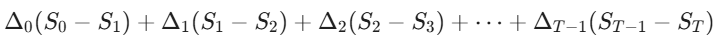
$+ \Delta_T S_T$

In [ ]:
cost_list=[]
payoff_list = []

for i in range(M):
  cost = 0
  price = S[i,0]
  for j in range(N):
    tow = T - j*dt
    d1 = (np.log(S[i,j]/K) + (r+0.5*sig**2)*tow)/(sig*np.sqrt(tow))
    d2 = d1 - sig*np.sqrt(tow)
    delta = norm.cdf(d1)

    cost = cost + delta*(price - S[i,j+1])
    price = S[i,j+1]

  payoff = cost + np.maximum(S[i,N]-K,0)  - 2.2871506280449694
  payoff_list.append(payoff)
  cost_list.append(cost)

In [ ]:
plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.scatter(S[:,-1], cost_list, alpha =0.6)
plt.title('Delta-Hedge Strategy Cost w/o maturity strike')

plt.subplot(2,1,2)
plt.scatter(S[:,-1], payoff_list, alpha = 0.6)
plt.plot([S[:,-1].min(),S[:,-1].max()],[0.0,0.0], ':', color = 'red')
plt.title('Delta-Hedge Strategy Payoff')
plt.show()

#ML

In [ ]:
r = 0.00
sig = 0.2
T = 30/365

M = 20000
N = 30

dt = T/N
rdt = r * dt
sigsdt = sig * np.sqrt(dt)

In [ ]:
#minimizing hedge_cost (결국 이게 profit maximizing)

my_input = []

hedge_cost = keras.layers.Input(shape = (1,), name = 'hedge_cost')
my_input.append(hedge_cost) # exactly same to my_input = my_input + [hedge_cost]

price = keras.layers.Input(shape = (1,), name = 'S_0')
my_input.append(price) # exactly same to my_input = my_input + [price]



for j in range(3):
  delta = tf.keras.layers.Dense(1, name = 'delta_'+str(j))(price)

  new_price = Input(shape = (1,), name = 'S_'+str(j+1)) # S[i,j+1]
  my_input.append(new_price)

  price_inc = keras.layers.Subtract(name = 'price_inc_'+str(j))([price ,new_price]) #
  cost = tf.keras.layers.Multiply(name = 'Multiply (Cost)_'+str(j))([delta, price_inc]) #  delta * (price - S[i,j+1])
  hedge_cost= tf.keras.layers.Add(name = 'hedge_cost_'+str(j))([hedge_cost,cost]) # cost= cost + delta * (price - S[i,j+1]) -> hedge_cost = hedge_cost + cost

  price = new_price



input_vec = keras.layers.Concatenate(name = 'input')(my_input)

hedge_costs = keras.layers.Dense(1, name = 'hedge_costs')(hedge_cost)

output = tf.keras.layers.Dense(1, activation = 'linear', name = 'output')(input_vec)

model = tf.keras.Model(inputs = my_input, outputs = output)



In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_layer_names=True)

In [ ]:
K=100

my_input = []

call = tf.keras.layers.Input(shape = (1,), name = 'call')
my_input.append(call)

hedge_cost= tf.keras.layers.Input(shape = (1,), name = 'hedge_cost')
my_input.append(hedge_cost)

price = tf.keras.layers.Input(shape = (1,), name = 'S0')
my_input.append(price)

for j in range(N):

  delta = Dense(32, activation = 'tanh')(price)
  delta = keras.layers.BatchNormalization()(delta)
  delta = Dense(32, activation = 'relu')(delta)
  delta = keras.layers.BatchNormalization()(delta)
  delta = Dense(32, activation = 'tanh')(delta)
  delta = keras.layers.BatchNormalization()(delta)
  delta = Dense(1)(delta)

  new_price = tf.keras.layers.Input(shape = (1,), name = 'S'+str(j+1))
  #이렇게 해야 계속 for문 돌아가면서 S1,...SN까지 받음
  my_input.append(new_price)

  price_inc = tf.keras.layers.Subtract(name = 'price_inc_'+str(j))([price, new_price])
  cost = tf.keras.layers.Multiply(name = 'Multiply_'+str(j))([delta, price_inc])
  hedge_cost= tf.keras.layers.Add(name = 'hedge_cost_'+str(j))([hedge_cost,cost])
  price = new_price

payoff = tf.keras.layers.Lambda(lambda x : 0.5*(tf.abs(x-K) + x-K), name = 'payoff')(price)

'''
lambda는 입력 → 출력 함수 하나를 한 줄로 정의하는 문법이고,
layers.Lambda는 그 함수를 “레이어”로 만들어 입력 텐서(price 등)에 적용하는 것이다.
'''
cum_cost = tf.keras.layers.Add(name = 'cum_cost')([hedge_cost, payoff])
cum_cost = tf.keras.layers.Subtract(name = 'final_cum_cost')([cum_cost, call])

model = tf.keras.Model(inputs = my_input, outputs = cum_cost)




In [ ]:
p = bscall(S0,K,T,r,sig) * np.ones([M,1])
c = np.zeros([M,1])
SS = [S[:,i].reshape(M,1) for i in range(N+1)]
x = [p] + [c] + [SS[i] for i in range(N+1)]
y = np.zeros([M,1])

In [ ]:
model.compile(optimizer = 'adam', loss = 'mse')
model.fit(x,y, epochs=30)

In [ ]:
model.predict(x)

In [ ]:
plt.hist(model.predict(x),bins = 100)

# 숙제: Long Butterfly 제작 + ML으로 payoff 설계

## Long butterfly 제작

In [ ]:
K1 = 92.5
K2 = 100
K3 = 107.5

S0=100

ST = np.arange(50,151,1)


#1. t=0 call price

d1_1 = (np.log(S0/K1) + (r+0.5*sig**2)*T)/(sig*np.sqrt(T))
d1_2 = (np.log(S0/K2) + (r+0.5*sig**2)*T)/(sig*np.sqrt(T))
d1_3 = (np.log(S0/K3) + (r+0.5*sig**2)*T)/(sig*np.sqrt(T))

d2_1 = d1_1 - sig*np.sqrt(T)
d2_2 = d1_2 - sig*np.sqrt(T)
d2_3 = d1_3 - sig*np.sqrt(T)

call1 = S0 * norm.cdf(d1_1) - K1 * np.exp(-r*T) * norm.cdf(d2_1)
call2 = S0 * norm.cdf(d1_2) - K2 * np.exp(-r*T) * norm.cdf(d2_2)
call3 = S0 * norm.cdf(d1_3) - K3 * np.exp(-r*T) * norm.cdf(d2_3)

#2. Maturyity payoff

opts = -call1 + 2 * call2 -call3

payoff1 = np.maximum(ST-K1,0)
payoff2 = np.maximum(ST-K2,0)
payoff3 = np.maximum(ST-K3,0)

pf_payoff = payoff1 - 2*payoff2 + payoff3

pf_profit = pf_payoff + opts

print(pf_profit)

'''
cost_list=[]
payoff_list = []

for i in range(M):
  cost = 0
  price = S[i,0]
  for j in range(N):
    tow = T - j*dt
    d1 = (np.log(S[i,j]/K) + (r+0.5*sig**2)*tow)/(sig*np.sqrt(tow))
    d2 = d1 - sig*np.sqrt(tow)
    delta = norm.cdf(d1)

    cost = cost + delta*(price - S[i,j+1])
    price = S[i,j+1]

  payoff = cost + np.maximum(S[i,N]-K,0)  - 2.2871506280449694
  payoff_list.append(payoff)
  cost_list.append(cost)
  '''

print(call1,call2,call3)

In [ ]:
logS = np.log(S)
dlogS = logS[:,1:] - logS[:,:-1]      # shape (M, N) 1~30 - 0~29
RV = np.cumsum(dlogS**2, axis=1)      # shape (M, N)
RV = [RV[:,i].reshape((M,1)) for i in range(N)][:-1]
RV = [np.zeros((M,1))] +[RV[i] for i in range(len(RV))]


In [ ]:
RV[29]

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(ST,pf_profit)
plt.title('Long Butterfly Profit')
plt.show()

In [ ]:
# ML -> Long Butterfly Spread
my_input = []

initial_cf = tf.keras.layers.Input(shape = (1,), name = 'initial_cf')
my_input.append(initial_cf)

hedge_cost= tf.keras.layers.Input(shape = (1,), name = 'hedge_cost')
my_input.append(hedge_cost)

tau = tf.keras.layers.Input(shape=(1,), name='tau')
my_input.append(tau)

realised_var = tf.keras.layers.Input(shape = (1,), name = 'realised_var')
my_input.append(realised_var)

price = tf.keras.layers.Input(shape = (1,), name = 'S0')
my_input.append(price)



for j in range(N):

  state = tf.keras.layers.Concatenate(name = 'state_'+str(j))([price, tau, realised_var])

  delta = Dense(128, activation = 'leaky_relu')(state)
  delta = keras.layers.BatchNormalization()(delta)
  delta = Dense(128, activation = 'leaky_relu')(delta)
  delta = keras.layers.BatchNormalization()(delta)
  delta = Dense(128, activation = 'leaky_relu')(delta)
  delta = Dense(1, activation = 'sigmoid')(delta)

  if not j == N-1:
    new_tau = tf.keras.layers.Input(shape = (1,), name = 'tau'+str(j+1))
    my_input.append(new_tau)
    tau = new_tau

    new_var = tf.keras.layers.Input(shape = (1,), name = 'var'+str(j+1))
    my_input.append(new_var)
    realised_var = new_var


  new_price = tf.keras.layers.Input(shape = (1,), name = 'S'+str(j+1))
  my_input.append(new_price)

  price_inc = tf.keras.layers.Subtract(name = 'price_inc_'+str(j))([price, new_price])
  cost = tf.keras.layers.Multiply(name = 'Multiply_'+str(j))([delta, price_inc])
  hedge_cost= tf.keras.layers.Add(name = 'hedge_cost_'+str(j))([hedge_cost,cost])
  price = new_price


stock_profit = - hedge_cost
payoff = tf.keras.layers.Lambda(lambda x :
                                  0.5*(tf.abs(x-K1) + x-K1)
                                  - 2* 0.5*(tf.abs(x-K2) + x-K2)
                                  + 0.5*(tf.abs(x-K3) + x-K3),
                                  name = 'payoff')(price)

opt = tf.keras.layers.Add(name = 'opt')([initial_cf, payoff])
goal = tf.keras.layers.Add(name = 'goal')([opt, stock_profit])


stock_model = tf.keras.Model(inputs = my_input, outputs = stock_profit)
model = tf.keras.Model(inputs = my_input, outputs = goal)




In [ ]:
[i.name for i in model.inputs]

In [ ]:
opts_mtx = opts * np.ones([M,1])
c = np.zeros([M,1])
SS = [S[:,i].reshape(M,1) for i in range(N+1)]
tau_list = [(T - j*dt) * np.ones((M,1)) for j in range(N)]
RV = RV

variables = []
for i in range(N):
    variables.append(tau_list[i])
    variables.append(RV[i])
    variables.append(SS[i])

variables.append(SS[-1])


x = [opts_mtx] + [c] + [variables[i] for i in range(len(variables))]
y = np.zeros([M,1])

In [ ]:
model.compile(optimizer = 'adam', loss = 'mse')
model.fit(x,y, epochs=60)

In [ ]:
stock_pnl = stock_model.predict(x)
plt.scatter(S[:,-1], stock_pnl, alpha=0.5)
plt.xlabel("Terminal Price $S_T$")
plt.ylabel("Stock Hedging P&L")
plt.show()

In [ ]:
# 예측
stock_pnl = stock_model.predict(x).ravel()
# payoff 계산(넘파이로)
ST = S[:,-1]
payoff_vals = opts + np.maximum(ST-K1,0) - 2*np.maximum(ST-K2,0) + np.maximum(ST-K3,0)

# replicated payoff (모형이 만들었다고 주장하는 것)
replicated = stock_pnl   # initial_cf를 상수로 넣었다면 그 값


In [ ]:
plt.scatter(ST, payoff_vals, alpha=0.3, label="true payoff")
plt.scatter(ST, replicated, alpha=0.3, label="stock_pnl")
plt.legend(); plt.show()


# 딥헤징 ３부

In [ ]:
r = 0.00
sig = 0.2
T = 30/365

M = 1000
N = 30

dt = T/N
rdt = r * dt
sigsdt = sig * np.sqrt(dt)

In [ ]:
np.random.seed(1234)
S0 = 1
K = 1

S = np.empty([M,N+1])
S[:,0] =   S0 #np.full((1000,),S0) 둘다 똑같음

rv = np.random.normal(rdt,sigsdt,(M,N))

In [ ]:
for i in range(M):
  for j in range(N):
    S[i,j+1] = S[i,j] * (1+rv[i,j])

In [ ]:
for i in range(M):
  plt.plot(S[i,:])

plt.tight_layout()
plt.show()

In [ ]:
def bscall(S,K,T,r,sig):
  d1 = (np.log(S/K) + (r+0.5*sig**2)*T)/(sig*np.sqrt(T))
  d2 = d1 - sig * np.sqrt(T)
  return S * norm.cdf(d1) - K*np.exp(-r*T) * norm.cdf(d2)

def bsput(S,K,T,r,sig):
  d1 = (np.log(S/K) + (r+0.5*sig**2)*T)/(sig*np.sqrt(T))
  d2 = d1 - sig * np.sqrt(T)
  return K*np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)

In [ ]:
model.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
my_input = []

call = tf.keras.layers.Input(shape = (1,), name = 'call')
my_input.append(call)

hedge_cost= tf.keras.layers.Input(shape = (1,), name = 'hedge_cost')
my_input.append(hedge_cost)

price = tf.keras.layers.Input(shape = (1,), name = 'S0')
my_input.append(price)

for j in range(N):

  delta = Dense(32, activation = 'leaky_relu')(price)
  delta = keras.layers.BatchNormalization()(delta)
  delta = Dense(32, activation = 'leaky_relu')(delta)
  delta = keras.layers.BatchNormalization()(delta)
  delta = Dense(32, activation = 'leaky_relu')(delta)
  delta = Dense(1, activation = 'sigmoid')(delta)

  new_price = tf.keras.layers.Input(shape = (1,), name = 'S'+str(j+1))
  #이렇게 해야 계속 for문 돌아가면서 S1,...SN까지 받음
  my_input.append(new_price)

  price_inc = tf.keras.layers.Subtract(name = 'price_inc_'+str(j))([price, new_price])
  cost = tf.keras.layers.Multiply(name = 'Multiply_'+str(j))([delta, price_inc])
  hedge_cost= tf.keras.layers.Add(name = 'hedge_cost_'+str(j))([hedge_cost,cost])
  price = new_price

payoff = tf.keras.layers.Lambda(lambda x : 0.5*(tf.abs(x-K) + x-K), name = 'payoff')(price)
cum_cost = tf.keras.layers.Add(name = 'cum_cost')([hedge_cost, payoff])
cum_cost = tf.keras.layers.Subtract(name = 'final_cum_cost')([cum_cost, call])
stock_profit = - hedge_cost


stock_model = tf.keras.Model(inputs = my_input, outputs = stock_profit)
model = tf.keras.Model(inputs = my_input, outputs = cum_cost)




In [ ]:
p = bscall(S0,K,T,r,sig) * np.ones([M,1])
c = np.zeros([M,1])
SS = [S[:,i].reshape(M,1) for i in range(N+1)]
x = [p] + [c] + [SS[i] for i in range(N+1)]
y = np.zeros([M,1])

In [ ]:
model.compile(optimizer = 'adam', loss = 'mse')
hist = model.fit(x,y, batch_size= 32, epochs = 30, verbose = True, validation_split = 0.2)

In [ ]:
plt.plot(hist.history['loss'])

In [ ]:
plt.hist(stock_model.predict(x),bins = 30)

In [ ]:
plt.scatter(S[:,-1],stock_model.predict(x), alpha = 0.5)
plt.tight_layout()

In [ ]:
# 예측
stock_pnl = stock_model.predict(x).ravel()
# payoff 계산(넘파이로)
ST = S[:,-1]
payoff_vals = opts + np.maximum(ST-K1,0) - 2*np.maximum(ST-K2,0) + np.maximum(ST-K3,0)

# replicated payoff (모형이 만들었다고 주장하는 것)
replicated = stock_pnl   # initial_cf를 상수로 넣었다면 그 값


# Buhler - Deep Hedging

## 기초 텐서 조작 및 자동 미분 (Autograd)

$\frac{\partial C}{\partial \theta}$ (비용 함수에 대한 파라미터 미분)를 구하는 과정입니다.

In [ ]:
import torch

# 1. 텐서 생성 (Requires_grad=True는 TF의 Variable과 유사하게 그래디언트 추적을 의미)
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
w = torch.tensor([0.5, 0.5, 0.5], requires_grad=True)

# 2. 연산 수행 (Forward)
y = torch.dot(x, w)  # 내적
loss = (y - 5.0) ** 2  # 간단한 MSE Loss

# 3. 역전파 (Backward)
# PyTorch는 명시적인 Tape(TF의 GradientTape) 없이 loss.backward()로 호출
loss.backward()

# 4. 그래디언트 확인
print(f"w의 기울기: {w.grad}") # d(Loss)/dw




**Note: PyTorch는 그래디언트를 누적(accumulate)하는 특성이 있어, 학습 Loop에서 optimizer.zero_grad()를 통해 매번 그래디언트를 초기화해줘야 합니다.**

Batch 1

loss = ...
loss.backward()

현재 w.grad: 10 (첫 번째 배치의 기울기)

optimizer.step() # 파라미터 업데이트 (10만큼 반영)

Batch 2 (여기서 zero_grad()를 깜빡함!)
loss = ...
loss.backward()


현재 w.grad: 20 (10 + 10) -> !?!?!?
원래는 이번 배치의 기울기인 10이어야 하는데, 이전 것이 남아서 합쳐짐

optimizer.step() # 파라미터 업데이트 (20만큼 반영 -> 학습이 엉뚱하게 튐)


Batch 1


optimizer.zero_grad() # 쓰레기통 비우기 (w.grad = 0)

loss.backward()       # w.grad = 0 + 10 = 10

optimizer.step()

Batch 2

optimizer.zero_grad() # 쓰레기통 비우기 (w.grad = 0)

loss.backward()       # w.grad = 0 + 10 = 10 (정상!)

optimizer.step()

## Deep-Hedging LSTM 설계

In [ ]:
import torch
import torch.nn as nn

class DeepHedgingModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(DeepHedgingModel, self).__init__()
        '''
        PyTorch에서 모델을 만들 때는 보통 nn.Module이라는 기본 클래스를 상속받습니다. nn.Module 안에는 신경망 모델이 동작하는 데 꼭 필요한 복잡한 기능들(파라미터 추적, GPU 이동, 레이어 등록 등)이 이미 구현되어 있습니다.

        super(...).__init__()을 호출하는 이유는 "내가 만든 모델(DeepHedgingModel)도 nn.Module이 가진 그 기능들을 그대로 초기화해서 쓰겠다"고 선언하는 것입니다.

        2. 코드의 구성 요소
        super(): 부모 클래스(여기서는 nn.Module)를 가리킵니다.

        DeepHedgingModel: 현재 본인이 정의하고 있는 클래스의 이름입니다.

        self: 현재 생성된 인스턴스 자기 자신을 의미합니다.

        .__init__(): 부모 클래스의 초기화 함수(생성자)를 실행하라는 뜻입니다.
        '''

        # LSTM 레이어 정의
        # input_dim: 시장 정보의 수 (예: 주가, 변동성, 이전 델타 등)
        # hidden_dim: 정보를 압축할 은닉 노드 수
        # batch_first=True: 입력 데이터 형태를 (Batch, Time, Feat)로 설정
        # Batch: 샘플 크기 Time: 말 그대로 며칠 동안의 데이터 인지 Feat: 말 그대로 column 개수
        # ex) (1000,20,3): 1000개의 MC 경로가 있고, 20일치이며, 사용하는 데이터가 3개(주가, vol, current delta 처럼)다.
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            num_layers=3, #hidden layer 개수
                            batch_first=True)

        # 출력 레이어 (델타 산출)
        # 0과 1 사이의 비중을 출력하기 위해 Tanh나 Sigmoid를 쓰기도 하지만,
        # 논문에서는 제약조건에 따라 활성화 함수가 달라질 수 있음
        self.fc = nn.Linear(hidden_dim, output_dim)
        # fc indicates fully connected(dense) layer, 즉 마지막 출력 layer로 바로 앞 hidden layer를 전부 받겠다.

        self.activation = nn.Tanh()
        # 이건 마지막 출력층에만 가해지는 activaion funciton -> 엥 그럼 각 hidden layer는요?
        # 그게 이미 내장되어 있음. 보통 tanh이랑 sigmoid임. -> 엥 왜요?
        # 그게 가장 안정적이고 효과가 좋음. 흔히 수정 안하고, 혹여나 자기가 바꾸고 싶으면 아래와 같이 층을 나눠줘야함.

        '''
        # 이런 식으로 짜면 층 사이에 원하는 함수를 넣을 수 있습니다.
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.relu = nn.ReLU() # 층 사이에 넣고 싶은 함수
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)

        # forward 함수에서
        out, _ = self.lstm1(x)
        out = self.relu(out) # 1층 통과 후 ReLU 적용
        out, _ = self.lstm2(out) # 그 다음 2층 통과
        '''

    def forward(self, x, prev_hedge=None):
        """
        x shape: (Batch Size, Time Steps, Features)
        """
        # 1. LSTM 통과
        # out shape: (Batch, Time, Hidden) -> 모든 시점의 은닉 상태
        # (h_n, c_n): 마지막 시점의 상태 (여기선 사용 안 함)
        lstm_out, (h_n, c_n) = self.lstm(x)

        # 2. 델타 계산 (모든 타임 스텝에 대해)
        # Deep Hedging은 만기까지의 '모든 시점'에서 리밸런싱이 일어나므로
        # 전체 시퀀스(lstm_out)를 다 사용합니다.
        deltas = self.activation(self.fc(lstm_out))

        return deltas

## MC Simulation & Loss Function

In [ ]:
def generate_gbm(n_paths, n_steps, t_maturity, mu, sigma, s_0, device='cpu'):
    """
    n_paths: 시뮬레이션 경로 수 (Batch Size) = M
    n_steps: 리밸런싱 횟수 (Time Steps) = N
    t_maturity: 만기 (년 단위, ex: 30/365)
    mu: 연간 기대 수익률 (Drift)
    sigma: 연간 변동성 (Volatility)
    s_0: 초기 주가
    """
    dt = t_maturity / n_steps

    # 1. 브라운 운동의 증분(dW) 생성 (정규분포)
    # shape: (Batch, Steps)
    dw = torch.randn(n_paths, n_steps, device=device) * torch.sqrt(torch.tensor(dt)) # = ε_t * root dt

    # 2. 주가 경로 계산 (Vectorized)
    # Prerequiste: Ito's y = lnS_t &  S_t follows GBM
    # S_t = S_0 * exp( (mu - 0.5*sigma^2)*t + sigma*W_t )
    # 누적합(cumsum)을 이용해 한 번에 계산

    drift = (mu - 0.5 * sigma**2) * dt
    diffusion = sigma * dw

    # discrete log return
    log_returns = drift + diffusion

    # 로그 수익률 누적
    log_returns_cum = torch.cumsum(drift + diffusion, dim=1)

    # 초기 주가와 결합 (t=0 시점 추가)
    ones = torch.zeros(n_paths, 1, device=device) # t=0 시점의 로그 수익률은 0
    log_returns_cum = torch.cat((ones, log_returns_cum), dim=1)

    paths = s_0 * torch.exp(log_returns_cum)
    paths_3d = paths.unsqueeze(-1)

    # Return shape: (Batch Size, Time Steps + 1, 1) -> Feature 차원 추가
    # 우리가 넣는건 batch(경로 개수) & time(time개수) & 'feature'(주가 등의 data)의 3차원 이므로 지금 2차원으로 구성된 것에
    # 추가 해줘야함. unqueeze(n)은 "n번째에 차원 추가해라" 란 의미 squeeze는 줄이는거
    return paths_3d

In [ ]:
#Loss Functions

def entropic_loss(pnl, risk_aversion=1.0):
    # pnl: (batch_size,)
    x = -risk_aversion * pnl
    # log(mean(exp(x))) = logsumexp(x) - log(N)
    # logsumexp는 내부적으로 max 값을 빼서 계산하므로 inf가 안 뜸
    loss = (1/risk_aversion) * (torch.logsumexp(x, dim=0) - torch.log(torch.tensor(x.size(0), device=pnl.device)))
    return loss

def cvar_loss(pnl, alpha=0.05):
    """
    pnl: (Batch Size,) 형태의 텐서. 모델의 헷징 결과로 얻은 최종 손익.
    alpha: 상위 몇 %의 악성 손실을 볼 것인가 (보통 1%, 5%)
    """
    # 1. P&L을 오름차순 정렬 (손실이 큰 순서대로, 즉 값이 작은 순서대로)
    sorted_pnl, _ = torch.sort(pnl)

    # 2. 하위 alpha%에 해당하는 인덱스 계산
    n_samples = pnl.size(0)
    cutoff_index = int(n_samples * alpha)

    # 3. 하위 alpha%의 평균 계산 (Expected Shortfall)
    # pnl이 이익(+)일 수도 손실(-)일 수도 있음.
    # CVaR은 보통 '손실의 크기'를 양수로 표현하므로 -를 붙여줌.
    # 즉, -100원이면 손실이 100원이므로 Loss는 100이 되어야 함.
    tail_loss = -torch.mean(sorted_pnl[:cutoff_index])

    return tail_loss

def mean_loss(pnl):
  mse = pnl ** 2
  return torch.mean(mse)

In [ ]:
def bscall(S,K,T,r,sig):
  d1 = (np.log(S/K) + (r+0.5*sig**2)*T)/(sig*np.sqrt(T))
  d2 = d1 - sig * np.sqrt(T)
  return S * norm.cdf(d1) - K*np.exp(-r*T) * norm.cdf(d2)

def bsput(S,K,T,r,sig):
  d1 = (np.log(S/K) + (r+0.5*sig**2)*T)/(sig*np.sqrt(T))
  d2 = d1 - sig * np.sqrt(T)
  return K*np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)

## Deep-Hedging vs BS Delta Hedging

### W/O Transaction Cost

In [ ]:
import torch.optim as optim

# --- 하이퍼파라미터 설정 ---
M = 20000   # 배치 사이즈 (User Code의 주석 참고)
N = 30     # (Time Steps)
T = 30/365
mean = 0.0
sig = 0.2
S_0 = 100.0
K = 100.0   # ATM 옵션
initial_cf = bscall(S_0, K, T, mean, sig)

# 디바이스 설정 (GPU 권장)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 모델 초기화 ---
# input_dim=1 (주가 정보만 사용한다고 가정)
# hidden_dim=32
model = DeepHedgingModel(input_dim=1, hidden_dim=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)


# --- 학습 루프 ---
print("Training Start...")
for epoch in range(1001): # 500 에포크

    # 1. 데이터 생성 (매 에포크마다 새로운 시뮬레이션 -> 오버피팅 방지)
    # prices shape: (Batch, Steps+1, 1)
    prices = generate_gbm(M, N, T, mean, sig, S_0, device)

    # 2. 모델 예측 (Action)
    # prices는 t=0 ~ t=T까지 있음.
    # 모델에는 t=0 ~ t=T-1 까지의 정보를 주고, t=0 ~ t=T-1 시점의 델타를 구함
    inputs = prices[:, :-1, :] # 마지막 만기 시점 제외

    # deltas shape: (Batch, Steps, 1)
    # User Code의 forward에서 squeeze가 없다면 (Batch, Steps, 1)로 나옴
    deltas = model(inputs)

    # 3. P&L 계산 (Financial Logic)
    # 옵션 Payoff (Call Option): Max(S_T - K, 0)
    S_T = prices[:, -1, 0]
    option_payoff = torch.relu(S_T - K)

    # 4. 헷징 포트폴리오의 가치 변화
    price_changes = prices[:, 1:, 0] - prices[:, :-1, 0] # (Batch, Steps)

    # 텐서 shape 맞추기 (Batch, Steps)
    deltas = deltas.squeeze(-1)

    # [수정 전 - no transaction cost]

    # 헷징 수익 = sum(델타 * 주가변동)
    # ΣDelta_t * (S_{t+1} - S_t) -> 손해면 마이너스로 나옴
    hedging_pnl = torch.sum(deltas * price_changes, dim=1)


    # 최종 P&L = 옵션 매도 프리미엄(생략 가능) + 헷징 수익 - 만기 Payoff 지불
    # 여기서는 '순수 헷징 오차'를 줄이는 것이 목표이므로 프리미엄은 제외하고
    # Wealth = Hedging PnL - Liability 로 봅니다.
    total_pnl = hedging_pnl - option_payoff # 얘 평균이 결국 BS Call Price로 수렴하는지 봐야함. 그게 asset pricing에서 말하는 option premium이니깐
    final_pnl = total_pnl + initial_cf
    # 4. Loss 계산 (CVaR)
    loss = cvar_loss(total_pnl) # 하위 5% 상황 방어
    loss_mse = mean_loss(total_pnl)
    loss_entropy = entropic_loss(total_pnl)

    # 5. 역전파 및 업데이트
    optimizer.zero_grad() # [중요] 그래디언트 초기화
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch} | CVaR Loss: {loss.item():.4f} | Mean PnL: {total_pnl.mean().item():.8f} | Mean PnL - BSCALL : {final_pnl.mean().item():.8f}")
        #print(f"Epoch {epoch} | MSE Loss: {loss_mse.item():.4f} | Mean PnL: {total_pnl.mean().item():.8f}")



print(f"Training Finished. BSCALL PRICE : {initial_cf}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

S_T_np = S_T.detach().cpu().numpy()
option_payoff_np = option_payoff.detach().cpu().numpy()
hedging_pnl_np = hedging_pnl.detach().cpu().numpy()          # shape (M,)
final_pnl_np = final_pnl.detach().cpu().numpy()

# ---- Plot 1: S_T histogram ----
plt.figure()
plt.hist(S_T_np, bins=50)
plt.title("Histogram of $S_T$")
plt.xlabel("$S_T$")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# ---- Plot 2: hedging_pnl histogram ----
plt.figure()
plt.hist(hedging_pnl_np, bins=80)
plt.title("Histogram of Hedging PnL")
plt.xlabel("hedging_pnl")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# ---- Plot 3: scatter S_T vs hedging_pnl ----
plt.figure()
plt.scatter(S_T_np, hedging_pnl_np, s=8)
plt.scatter(S_T_np, option_payoff_np)
plt.title("Scatter: $S_T$ vs Hedging PnL")
plt.xlabel("$S_T$")
plt.ylabel("hedging_pnl")
plt.tight_layout()
plt.show()

# ---- Plot 4: scatter S_T vs hedging_pnl ----
plt.figure()
plt.scatter(S_T_np, final_pnl_np, s=8, alpha = 0.4)
plt.plot([S_T_np.min(),S_T_np.max()],[0.0,0.0], ':', color = 'red')
plt.title("Scatter: $S_T$ vs Final PnL")
plt.xlabel("$S_T$")
plt.ylabel("Final PnL")
plt.tight_layout()
plt.show()
pd.Series(final_pnl_np).describe()





In [ ]:
'''
Deep-Hedging Model
'''

# 모델을 평가 모드로 전환 (Dropout, BatchNorm 비활성화)
model.eval()

#test stock data
prices_test = generate_gbm(M, N, T, mean, sig, S_0, device)

with torch.no_grad(): # 기울기 계산을 끄고 메모리 절약

    # Scikit-learn의 model.predict(X) 대신 아래와 같이 사용
    predicted_delta = model(prices_test[:, :-1, :])
    predicted_delta = predicted_delta.squeeze(-1)

    S_T_test = prices_test[:, -1, 0]
    option_payoff_test = torch.relu(S_T_test - K)

    price_changes_test = prices_test[:, 1:, 0] - prices_test[:, :-1, 0] # (Batch, Steps)


    hedging_pnl_test = torch.sum(predicted_delta * price_changes_test, dim=1)


    total_pnl_test = hedging_pnl_test - option_payoff_test # 얘 평균이 결국 BS Call Price로 수렴하는지 봐야함. 그게 asset pricing에서 말하는 option premium이니깐
    final_pnl_test = total_pnl_test + initial_cf

    # 4. Loss 계산 (CVaR)
    loss = cvar_loss(total_pnl_test) # 하위 5% 상황 방어
    loss_mse = mean_loss(total_pnl_test)


In [ ]:
import torch
from torch.distributions import Normal

# 1. Black-Scholes Delta 계산 함수 (Vectorized)
def calculate_bs_delta(S, time_remaining, K, r, sigma):
    """
    S: 현재 주가 (Tensor)
    time_remaining: 잔여 만기 (Tensor)
    K: 행사가
    r: 무위험 이자율
    sigma: 변동성
    """
    # 만기 시점(time_remaining=0) 근처에서의 0으로 나누기 에러 방지용 epsilon
    epsilon = 1e-8

    d1 = (torch.log(S / K) + (r + 0.5 * sigma ** 2) * time_remaining) / (sigma * torch.sqrt(time_remaining) + epsilon)

    normal = Normal(0, 1)
    delta = normal.cdf(d1)

    return delta

In [ ]:

# 2. BS Hedging Simulation
# ---------------------------------------------------------
# prices_test shape: (Batch, Steps+1, 1)
# 우리가 헷징 포지션을 잡아야 하는 건 t=0 부터 t=T-1 까지입니다.

with torch.no_grad():
    # (1) 입력 데이터 준비
    # 시뮬레이션에 사용된 주가 (마지막 만기 시점 제외)
    S_t = prices_test[:, :-1, 0] # shape: (Batch, Steps)

    # (2) 잔여 만기(Time to Maturity) 텐서 생성
    # t=0일 때 잔여만기 T, t=1일 때 T-dt, ...
    # shape를 (Batch, Steps)로 맞춰줍니다.
    batch_size, steps = S_t.shape
    dt = T / steps

    # [T, T-dt, T-2dt, ... , dt] 형태로 시간 생성
    times = torch.linspace(T, dt, steps, device=device)
    time_remaining_matrix = times.unsqueeze(0).expand(batch_size, steps) # (Batch, Steps)

    # (3) BS Delta 계산
    # r=0 (가정), sigma=sig
    bs_deltas = calculate_bs_delta(S_t, time_remaining_matrix, K, 0.0, sig)

    # (4) BS P&L 계산 (Deep Hedging과 동일한 로직)
    # 주가 변동분
    price_changes_test = prices_test[:, 1:, 0] - prices_test[:, :-1, 0]

    # 헷징 포트폴리오 수익
    bs_hedging_pnl = torch.sum(bs_deltas * price_changes_test, dim=1)

    # 옵션 Payoff (만기 시점)
    S_T_test = prices_test[:, -1, 0]
    option_payoff_test = torch.relu(S_T_test - K)

    # 최종 P&L (Initial Premium + Hedging PnL - Payoff)
    # initial_cf는 BS Call Price라고 하셨으므로, 이론상 이 값의 평균은 0에 수렴해야 함
    bs_total_pnl = bs_hedging_pnl - option_payoff_test
    bs_final_pnl = initial_cf + bs_total_pnl

# ---------------------------------------------------------
# 3. 결과 비교 및 출력
# ---------------------------------------------------------
print(f"--- Comparison (Test Paths: {M}) ---")
print(f"[Deep Hedging] Mean PnL: {final_pnl_test.mean().item():.4f} | Std: {final_pnl_test.std().item():.4f} | CVaR(5%) w/o inital cf: {loss.item():.4f}")
print(f"[BS Delta]     Mean PnL: {bs_final_pnl.mean().item():.4f} | Std: {bs_final_pnl.std().item():.4f} | CVaR(5%) w/o inital cf: {cvar_loss(bs_total_pnl).item():.4f}")

In [ ]:


plt.figure(figsize=(10, 6))
# 딥러닝 PnL 분포
plt.hist(final_pnl_test.cpu().numpy(), bins=75, alpha=0.5, label='Deep Hedging', density=True, color='blue')
# BS PnL 분포
plt.hist(bs_final_pnl.cpu().numpy(), bins=75, alpha=0.5, label='BS Hedging', density=True, color='red')

plt.axvline(x=0, color='k', linestyle='--')
plt.title('PnL Distribution Comparison')
plt.xlabel('Profit & Loss')
plt.ylabel('Density')
plt.legend()
plt.show()

### WITH Transaction Cost

In [ ]:
import torch.optim as optim

# --- 하이퍼파라미터 설정 ---
M = 20000   # 배치 사이즈 (User Code의 주석 참고)
N = 30     # (Time Steps)
T = 30/365
mean = 0.0
sig = 0.2
S_0 = 100.0
K = 100.0   # ATM 옵션
number_opt = 10000.0
initial_cf = bscall(S_0, K, T, mean, sig)

# 디바이스 설정 (GPU 권장)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 모델 초기화 ---
# input_dim=1 (주가 정보만 사용한다고 가정)
# hidden_dim=32
model = DeepHedgingModel(input_dim=1, hidden_dim=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)


# --- 학습 루프 ---
print("Training Start...")
for epoch in range(1001): # 500 에포크

    # 1. 데이터 생성 (매 에포크마다 새로운 시뮬레이션 -> 오버피팅 방지)
    # prices shape: (Batch, Steps+1, 1)
    prices = generate_gbm(M, N, T, mean, sig, S_0, device)

    # 2. 모델 예측 (Action)
    # prices는 t=0 ~ t=T까지 있음.
    # 모델에는 t=0 ~ t=T-1 까지의 정보를 주고, t=0 ~ t=T-1 시점의 델타를 구함
    inputs = prices[:, :-1, :] # 마지막 만기 시점 제외

    # deltas shape: (Batch, Steps, 1)
    # User Code의 forward에서 squeeze가 없다면 (Batch, Steps, 1)로 나옴
    deltas = model(inputs)

    # 3. P&L 계산 (Financial Logic)
    # 옵션 Payoff (Call Option): Max(S_T - K, 0)
    S_T = prices[:, -1, 0]
    option_payoff = torch.relu(S_T - K)

    # 4. 헷징 포트폴리오의 가치 변화
    price_changes = prices[:, 1:, 0] - prices[:, :-1, 0] # (Batch, Steps)

    # 텐서 shape 맞추기 (Batch, Steps)
    deltas = deltas.squeeze(-1)



    # [수정 후: transaction cost 존재]
    COST_BPS = 0.1

    # 1. 델타 변화량 계산 (거래량)
    # 첫 시점(t=0)의 델타 변화량은 |delta_0 - 0| = |delta_0|
    # 그 이후는 |delta_t - delta_{t-1}|
    # prev_deltas: [0, delta_0, delta_1, ..., delta_{T-2}]
    prev_deltas = torch.cat([torch.zeros(deltas.size(0), 1).to(device), deltas[:, :-1]], dim=1)
    delta_changes = torch.abs(deltas - prev_deltas) # (Batch, Steps)

    # 2. 거래 비용 계산: 거래량 * 주가 * 비용율
    # 주가는 해당 시점의 가격 사용 (prices[:, :-1, 0])
    transaction_costs = torch.sum(delta_changes * prices[:, :-1, 0] * (COST_BPS / 100), dim=1)

    # 3. 순수익 계산 (비용 차감)
    hedging_pnl = torch.sum(deltas * price_changes, dim=1) - transaction_costs


    # 최종 P&L = 옵션 매도 프리미엄(생략 가능) + 헷징 수익 - 만기 Payoff 지불
    # 여기서는 '순수 헷징 오차'를 줄이는 것이 목표이므로 프리미엄은 제외하고
    # Wealth = Hedging PnL - Liability 로 봅니다.
    total_pnl = number_opt * (hedging_pnl - option_payoff) # 얘 평균이 결국 BS Call Price로 수렴하는지 봐야함. 그게 asset pricing에서 말하는 option premium이니깐
    final_pnl = total_pnl + number_opt * (initial_cf)
    # 4. Loss 계산 (CVaR)
    loss = cvar_loss(total_pnl) # 하위 5% 상황 방어
    loss_mse = mean_loss(total_pnl)


    # 5. 역전파 및 업데이트
    optimizer.zero_grad() # [중요] 그래디언트 초기화
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch} | CVaR Loss: {loss.item():.4f} | Mean PnL: {total_pnl.mean().item():.8f} | Final PnL : {final_pnl.mean().item():.8f}")
        #print(f"Epoch {epoch} | MSE Loss: {loss_mse.item():.4f} | Mean PnL: {total_pnl.mean().item():.8f}")



print(f"Training Finished.     BSCALL PRICE : {initial_cf}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

S_T_np = S_T.detach().cpu().numpy()
option_payoff_np = option_payoff.detach().cpu().numpy()
hedging_pnl_np = hedging_pnl.detach().cpu().numpy()          # shape (M,)
final_pnl_np = final_pnl.detach().cpu().numpy()

# ---- Plot 1: S_T histogram ----
plt.figure()
plt.hist(S_T_np, bins=50)
plt.title("Histogram of $S_T$")
plt.xlabel("$S_T$")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# ---- Plot 2: hedging_pnl histogram ----
plt.figure()
plt.hist(hedging_pnl_np, bins=80)
plt.title("Histogram of Hedging PnL")
plt.xlabel("hedging_pnl")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# ---- Plot 3: scatter S_T vs hedging_pnl ----
plt.figure()
plt.scatter(S_T_np, hedging_pnl_np, s=8)
plt.scatter(S_T_np, option_payoff_np)
plt.title("Scatter: $S_T$ vs Hedging PnL")
plt.xlabel("$S_T$")
plt.ylabel("hedging_pnl")
plt.tight_layout()
plt.show()

# ---- Plot 4: scatter S_T vs hedging_pnl ----
plt.figure()
plt.scatter(S_T_np, final_pnl_np, s=8, alpha = 0.4)
plt.plot([S_T_np.min(),S_T_np.max()],[0.0,0.0], ':', color = 'red')
plt.title("Scatter: $S_T$ vs Final PnL")
plt.xlabel("$S_T$")
plt.ylabel("Final PnL")
plt.tight_layout()
plt.show()
pd.Series(final_pnl_np).describe()





In [ ]:
'''
Deep-Hedging Model
'''

# 모델을 평가 모드로 전환 (Dropout, BatchNorm 비활성화)
model.eval()

#test stock data
prices_test = generate_gbm(M, N, T, mean, sig, S_0, device)

with torch.no_grad(): # 기울기 계산을 끄고 메모리 절약

    # Scikit-learn의 model.predict(X) 대신 아래와 같이 사용
    predicted_delta = model(prices_test[:, :-1, :])
    predicted_delta = predicted_delta.squeeze(-1)

    S_T_test = prices_test[:, -1, 0]
    option_payoff_test = torch.relu(S_T_test - K)

    price_changes_test = prices_test[:, 1:, 0] - prices_test[:, :-1, 0] # (Batch, Steps)

    prev_deltas_test = torch.cat([torch.zeros(predicted_delta.size(0), 1).to(device), predicted_delta[:, :-1]], dim=1)
    delta_changes_test = torch.abs(predicted_delta - prev_deltas_test) # (Batch, Steps)

    transaction_costs_test = torch.sum(delta_changes_test * prices_test[:, :-1, 0] * (COST_BPS / 100), dim=1)

    hedging_pnl_test = torch.sum(predicted_delta * price_changes_test, dim=1) - transaction_costs_test

    total_pnl_test = number_opt * (hedging_pnl_test - option_payoff_test) # 얘 평균이 결국 BS Call Price로 수렴하는지 봐야함. 그게 asset pricing에서 말하는 option premium이니깐
    final_pnl_test = total_pnl_test + number_opt * (initial_cf)

    # 4. Loss 계산 (CVaR)
    loss_test = cvar_loss(total_pnl_test) # 하위 5% 상황 방어
    loss_mse_test = mean_loss(total_pnl_test)


In [ ]:
import torch
from torch.distributions import Normal

# 1. Black-Scholes Delta 계산 함수 (Vectorized)
def calculate_bs_delta(S, time_remaining, K, r, sigma):
    """
    S: 현재 주가 (Tensor)
    time_remaining: 잔여 만기 (Tensor)
    K: 행사가
    r: 무위험 이자율
    sigma: 변동성
    """
    # 만기 시점(time_remaining=0) 근처에서의 0으로 나누기 에러 방지용 epsilon
    epsilon = 1e-8

    d1 = (torch.log(S / K) + (r + 0.5 * sigma ** 2) * time_remaining) / (sigma * torch.sqrt(time_remaining) + epsilon)

    normal = Normal(0, 1)
    delta = normal.cdf(d1)

    return delta

In [ ]:

# 2. BS Hedging Simulation
# ---------------------------------------------------------
# prices_test shape: (Batch, Steps+1, 1)
# 우리가 헷징 포지션을 잡아야 하는 건 t=0 부터 t=T-1 까지입니다.

with torch.no_grad():
    # (1) 입력 데이터 준비
    # 시뮬레이션에 사용된 주가 (마지막 만기 시점 제외)
    S_t = prices_test[:, :-1, 0] # shape: (Batch, Steps)

    # (2) 잔여 만기(Time to Maturity) 텐서 생성
    # t=0일 때 잔여만기 T, t=1일 때 T-dt, ...
    # shape를 (Batch, Steps)로 맞춰줍니다.
    batch_size, steps = S_t.shape
    dt = T / steps

    # [T, T-dt, T-2dt, ... , dt] 형태로 시간 생성
    times = torch.linspace(T, dt, steps, device=device)
    time_remaining_matrix = times.unsqueeze(0).expand(batch_size, steps) # (Batch, Steps)

    # (3) BS Delta 계산
    # r=0 (가정), sigma=sig
    bs_deltas = calculate_bs_delta(S_t, time_remaining_matrix, K, 0.0, sig)

    bs_prev_deltas = torch.cat([torch.zeros(bs_deltas.size(0), 1).to(device), bs_deltas[:, :-1]], dim=1)
    bs_delta_changes = torch.abs(bs_deltas - bs_prev_deltas) # (Batch, Steps)

    bs_transaction_costs = torch.sum(bs_delta_changes * prices_test[:, :-1, 0] * (COST_BPS / 100), dim=1)

    # (4) BS P&L 계산 (Deep Hedging과 동일한 로직)
    # 주가 변동분
    price_changes_test = prices_test[:, 1:, 0] - prices_test[:, :-1, 0]

    # 헷징 포트폴리오 수익
    bs_hedging_pnl = torch.sum(bs_deltas * price_changes_test, dim=1) - bs_transaction_costs

    # 옵션 Payoff (만기 시점)
    S_T_test = prices_test[:, -1, 0]
    option_payoff_test = torch.relu(S_T_test - K)

    # 최종 P&L (Initial Premium + Hedging PnL - Payoff)
    # initial_cf는 BS Call Price라고 하셨으므로, 이론상 이 값의 평균은 0에 수렴해야 함
    bs_total_pnl = number_opt * (bs_hedging_pnl - option_payoff_test)
    bs_final_pnl = number_opt * (initial_cf) + bs_total_pnl

# ---------------------------------------------------------
# 3. 결과 비교 및 출력
# ---------------------------------------------------------
print(f"--- Comparison (Test Paths: {M}) ---")
print(f"[Deep Hedging] Mean PnL: {final_pnl_test.mean().item():.4f} | Std: {final_pnl_test.std().item():.4f} | CVaR(5%) w/o inital cf: {loss.item():.4f}")
print(f"[BS Delta]     Mean PnL: {bs_final_pnl.mean().item():.4f} | Std: {bs_final_pnl.std().item():.4f} | CVaR(5%) w/o inital cf: {cvar_loss(bs_total_pnl).item():.4f}")

In [ ]:
plt.figure(figsize=(10, 6))
# 딥러닝 PnL 분포
plt.hist(final_pnl_test.cpu().numpy(), bins=75, alpha=0.5, label='Deep Hedging', density=True, color='blue')
# BS PnL 분포
plt.hist(bs_final_pnl.cpu().numpy(), bins=75, alpha=0.5, label='BS Hedging', density=True, color='red')

plt.axvline(x=0, color='k', linestyle='--')
plt.title('PnL Distribution Comparison with transaction cost')
plt.xlabel('Profit & Loss')
plt.ylabel('Density')
plt.legend()
plt.show()

## Putting Previous Delta & Tow Into the Model





In [ ]:
import torch
import torch.nn as nn

class DeepHedgingModelWithState(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(DeepHedgingModelWithState, self).__init__()

        # input_dim: 시장 데이터 개수 (예: Log Return 1개)
        # 실제 입력 차원 = 시장 데이터 + 이전 델타(1개) + tow(1개)
        self.input_dim = input_dim
        self.total_input_dim = input_dim + 2

        self.hidden_dim = hidden_dim

        # LSTMCell: 시퀀스 전체가 아니라 한 스텝(t)만 계산
        self.lstm_cell = nn.LSTMCell(self.total_input_dim, hidden_dim)

        #hidden_layer output 정규화
        self.layer_normalization = nn.LayerNorm(hidden_dim)

        # 출력 레이어
        self.fc = nn.Linear(hidden_dim, output_dim)

        # 숏 포지션 허용 시 Tanh, 롱 온리면 Sigmoid
        # 여기서는 -1 ~ 1 사이로 가정 (Tanh)
        self.activation = nn.Tanh()

    def forward(self, x, initial_delta=None, T=None):
        """
        x: (Batch, Steps, input_dim) -> 예: 주가 로그 수익률 등
        initial_delta: t=0 시점 이전에 보유한 포지션 (없으면 0)
        """
        batch_size, steps, _ = x.size()

        # 1. 초기 은닉 상태 (h_0, c_0) 초기화
        h_t = torch.zeros(batch_size, self.hidden_dim, device=x.device)
        c_t = torch.zeros(batch_size, self.hidden_dim, device=x.device)

        # 2. 초기 델타, 만기 설정 (delta: t=0 이전에 아무것도 없었으면 0.0)
        if initial_delta is None:
            prev_delta = torch.zeros(batch_size, 1, device=x.device)
        else:
            prev_delta = initial_delta

        deltas = []

        # 3. Time Step Loop (수동으로 돌리기)
        for t in range(steps):
            # (1) 현재 시점의 시장 데이터 가져오기: (Batch, input_dim)
            market_input = x[:, t, :]

            if T is None:
              print('T is not assigned. Try Again.')
              break

            else:
              pass

            dt = torch.ones(batch_size, 1, device=x.device) * (T/steps)
            tow = dt * (T - t)

            # (2) 입력 결합: [시장 데이터, 이전 델타] -> (Batch, input_dim + 1)
            # dim=1은 feature 차원
            lstm_input = torch.cat([market_input, prev_delta, tow], dim=1)

            # (3) LSTM Cell 연산
            h_t, c_t = self.lstm_cell(lstm_input, (h_t, c_t))
            h_t_norm = self.layer_normalization(h_t) #정규화

            # (4) 현재 델타 계산
            delta_t = self.activation(self.fc(h_t_norm))

            # (5) 결과 저장 및 업데이트
            deltas.append(delta_t)
            prev_delta = delta_t # 방금 구한 델타가 다음 스텝의 입력이 됨

        # 리스트에 담긴 델타들을 텐서로 합침 -> (Batch, Steps, 1)
        deltas = torch.stack(deltas, dim=1)

        return deltas

In [ ]:
import torch.optim as optim

# --- 하이퍼파라미터 설정 ---
M = 20000   # 배치 사이즈 (User Code의 주석 참고)
N = 30     # (Time Steps)
T = 30/365
mean = 0.0
sig = 0.2
S_0 = 100.0
K = 100.0   # ATM 옵션
number_opt = 10000.0
initial_cf = bscall(S_0, K, T, mean, sig)

BATCH_SIZE = 256 # 논문 설정대로 미니 배치 크기 지정

# 디바이스 설정 (GPU 권장)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 모델 초기화 ---
# input_dim=1 (주가 정보만 사용한다고 가정)
# hidden_dim=32
model = DeepHedgingModelWithState(input_dim=1, hidden_dim=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005) #deep hedging 논문은 0.005엿음. / batc_size= 256


# --- 학습 루프 ---
print("Training Start...")
for epoch in range(501):

    # 1. 데이터 생성 (매 에포크마다 새로운 시뮬레이션 -> 오버피팅 방지)
    # prices shape: (Batch, Steps+1, 1)
    prices = generate_gbm(M, N, T, mean, sig, S_0, device)
    S_T = prices[:, -1, 0]

    # 1-1. moneyness로 input 받아서, scale 무관하게 만들기(로그수익률은 아무리 봐도 현재 위치가 반영 안되는게 좀)
    inputs = prices/K
    inputs = inputs[:, :-1, :] # 마지막 만기 시점 제외

    # 2. 미니 배치 루프

    # 루프 시작 전 변수 초기화
    epoch_loss = 0.0
    epoch_loss_mse = 0.0
    epoch_loss_entropy = 0.0
    epoch_final_pnl = 0.0
    num_iters = 0

    for i in range(0, M, BATCH_SIZE):

        if (i + BATCH_SIZE) + BATCH_SIZE > M:

            batch_inputs = inputs[i:,:,:]
            batch_prices = prices[i:,:,:]
            option_payoff = torch.relu(S_T - K)[i:]
            is_last_batch = True

        else:

            batch_inputs = inputs[i : i + BATCH_SIZE,:,:]
            batch_prices = prices[i : i + BATCH_SIZE,:,:]
            option_payoff = torch.relu(S_T - K)[i : i + BATCH_SIZE]
            is_last_batch = False

        # 2. 모델 예측 (Action)
        # prices는 t=0 ~ t=T까지 있음.
        # 모델에는 t=0 ~ t=T-1 까지의 정보를 주고, t=0 ~ t=T-1 시점의 델타를 구함

        # deltas shape: (Batch, Steps, 1)
        # User Code의 forward에서 squeeze가 없다면 (Batch, Steps, 1)로 나옴
        deltas = model(batch_inputs, T = T)

        # 3. P&L 계산 (Financial Logic)
        # 옵션 Payoff (Call Option): Max(S_T - K, 0)


        # 4. 헷징 포트폴리오의 가치 변화
        price_changes = batch_prices[:, 1:, 0] - batch_prices[:, :-1, 0] # (Batch, Steps)

        # 텐서 shape 맞추기 (Batch, Steps)
        deltas = deltas.squeeze(-1)

        # 수정 후: transaction cost 존재
        COST_BPS = 50

        # 1. 델타 변화량 계산 (거래량)
        # 첫 시점(t=0)의 델타 변화량은 |delta_0 - 0| = |delta_0|
        # 그 이후는 |delta_t - delta_{t-1}|
        # prev_deltas: [0, delta_0, delta_1, ..., delta_{T-2}]
        prev_deltas = torch.cat([torch.zeros(deltas.size(0), 1).to(device), deltas[:, :-1]], dim=1)
        delta_changes = torch.abs(deltas - prev_deltas) # (Batch, Steps)

        # 2. 거래 비용 계산: 거래량 * 주가 * 비용율
        # 주가는 해당 시점의 가격 사용 (prices[:, :-1, 0])
        transaction_costs = torch.sum(delta_changes * batch_prices[:, :-1, 0] * (COST_BPS / 10000), dim=1)

        # 3. 순수익 계산 (비용 차감)
        hedging_pnl = torch.sum(deltas * price_changes, dim=1) - transaction_costs


        # 최종 P&L = 옵션 매도 프리미엄(생략 가능) + 헷징 수익 - 만기 Payoff 지불
        # 여기서는 '순수 헷징 오차'를 줄이는 것이 목표이므로 프리미엄은 제외하고
        # Wealth = Hedging PnL - Liability 로 봅니다.
        total_pnl = hedging_pnl - option_payoff # 얘 평균이 결국 BS Call Price로 수렴하는지 봐야함. 그게 asset pricing에서 말하는 option premium이니깐
        final_pnl = number_opt * (total_pnl + initial_cf)

        # 4. Loss 계산 (CVaR)
        loss = cvar_loss(total_pnl) # 하위 5% 상황 방어
        loss_mse = mean_loss(total_pnl)
        loss_entropy = entropic_loss(total_pnl)

        # 5. 역전파 및 업데이트
        optimizer.zero_grad()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        loss_entropy.backward()
        optimizer.step()

        # 6. 기록 누적
        epoch_loss += loss.item()
        epoch_loss_mse += loss_mse.item()
        epoch_loss_entropy += loss_entropy.item()
        epoch_final_pnl += final_pnl.mean().item()
        num_iters += 1

        # 마지막 배치를 처리했으면, 더 이상 루프를 돌 필요 없이 종료
        if is_last_batch:
            break

    if epoch  % 10 == 0:
       avg_loss = epoch_loss / num_iters
       avg_mse = epoch_loss_mse / num_iters
       avg_entropy = epoch_loss_entropy / num_iters
       avg_pnl = epoch_final_pnl / num_iters

       print(f"Epoch {epoch} | CVaR Loss: {avg_loss:.4f} | MSE Loss: {avg_mse:.4f} | Entropic Loss: {avg_entropy:.4f} | Mean Final PnL: {avg_pnl:.4f}")
print(f"Training Finished. FAIR PRICE : {avg_entropy:.7f} | BSCALL PRICE : {initial_cf:.7f}")


In [ ]:
# 모델을 평가 모드로 전환 (Dropout, BatchNorm 비활성화)
model.eval()

#generating test stock data
prices_test = generate_gbm(M, N, T, mean, sig, S_0, device)

In [ ]:
'''
Deep-Hedging Model
'''
with torch.no_grad(): # 기울기 계산을 끄고 메모리 절약

    # Scikit-learn의 model.predict(X) 대신 아래와 같이 사용
    predicted_delta = model((prices_test/K)[:,:-1,:], T = T)
    predicted_delta = predicted_delta.squeeze(-1)

    S_T_test = prices_test[:, -1, 0]
    option_payoff_test = torch.relu(S_T_test - K)

    price_changes_test = prices_test[:, 1:, 0] - prices_test[:, :-1, 0] # (Batch, Steps)

    prev_deltas_test = torch.cat([torch.zeros(predicted_delta.size(0), 1).to(device), predicted_delta[:, :-1]], dim=1)
    delta_changes_test = torch.abs(predicted_delta - prev_deltas_test) # (Batch, Steps)

    transaction_costs_test = torch.sum(delta_changes_test * prices_test[:, :-1, 0] * (COST_BPS / 10000), dim=1)

    hedging_pnl_test = torch.sum(predicted_delta * price_changes_test, dim=1) - transaction_costs_test

    total_pnl_test = hedging_pnl_test - option_payoff_test
    final_pnl_test = (total_pnl_test + initial_cf) # * number_opt

    # 4. Loss 계산
    loss_test = cvar_loss(total_pnl_test) # 하위 5% 상황 방어
    loss_mse_test = mean_loss(total_pnl_test)
    loss_entropy_test = entropic_loss(total_pnl_test)


In [ ]:
import torch
from torch.distributions import Normal

# 1. Black-Scholes Delta 계산 함수 (Vectorized)
def calculate_bs_delta(S, time_remaining, K, r, sigma):
    """
    S: 현재 주가 (Tensor)
    time_remaining: 잔여 만기 (Tensor)
    K: 행사가
    r: 무위험 이자율
    sigma: 변동성
    """
    # 만기 시점(time_remaining=0) 근처에서의 0으로 나누기 에러 방지용 epsilon
    epsilon = 1e-8

    d1 = (torch.log(S / K) + (r + 0.5 * sigma ** 2) * time_remaining) / (sigma * torch.sqrt(time_remaining) + epsilon)

    normal = Normal(0, 1)
    delta = normal.cdf(d1)

    return delta

In [ ]:

# 2. BS Hedging Simulation
# ---------------------------------------------------------
# prices_test shape: (Batch, Steps+1, 1)
# 우리가 헷징 포지션을 잡아야 하는 건 t=0 부터 t=T-1 까지입니다.

with torch.no_grad():
    # (1) 입력 데이터 준비
    # 시뮬레이션에 사용된 주가 (마지막 만기 시점 제외)
    S_t = prices_test[:, :-1, 0] # shape: (Batch, Steps)

    # (2) 잔여 만기(Time to Maturity) 텐서 생성
    # t=0일 때 잔여만기 T, t=1일 때 T-dt, ...
    # shape를 (Batch, Steps)로 맞춰줍니다.
    batch_size, steps = S_t.shape
    dt = T / steps

    # [T, T-dt, T-2dt, ... , dt] 형태로 시간 생성
    times = torch.linspace(T, dt, steps, device=device)
    time_remaining_matrix = times.unsqueeze(0).expand(batch_size, steps) # (Batch, Steps)

    # (3) BS Delta 계산
    # r=0 (가정), sigma=sig
    bs_deltas = calculate_bs_delta(S_t, time_remaining_matrix, K, 0.0, sig)

    bs_prev_deltas = torch.cat([torch.zeros(bs_deltas.size(0), 1).to(device), bs_deltas[:, :-1]], dim=1)
    bs_delta_changes = torch.abs(bs_deltas - bs_prev_deltas) # (Batch, Steps)

    bs_transaction_costs = torch.sum(bs_delta_changes * prices_test[:, :-1, 0] * (COST_BPS / 10000), dim=1)

    # (4) BS P&L 계산 (Deep Hedging과 동일한 로직)
    # 주가 변동분
    price_changes_test = prices_test[:, 1:, 0] - prices_test[:, :-1, 0]

    # 헷징 포트폴리오 수익
    bs_hedging_pnl = torch.sum(bs_deltas * price_changes_test, dim=1) - bs_transaction_costs

    # 옵션 Payoff (만기 시점)
    S_T_test = prices_test[:, -1, 0]
    option_payoff_test = torch.relu(S_T_test - K)

    # 최종 P&L (Initial Premium + Hedging PnL - Payoff)
    # initial_cf는 BS Call Price라고 하셨으므로, 이론상 이 값의 평균은 0에 수렴해야 함
    bs_total_pnl = bs_hedging_pnl - option_payoff_test
    bs_final_pnl = (initial_cf + bs_total_pnl) #* number_opt

# ---------------------------------------------------------
# 3. 결과 비교 및 출력
# ---------------------------------------------------------
print(f"--- Comparison (Test Paths: {M}) ---")
print(f"[Deep Hedging] Mean PnL: {final_pnl_test.mean().item():.4f} | Std: {final_pnl_test.std().item():.4f} | CVaR(5%) w/o inital cf: {cvar_loss(final_pnl_test).item():.4f}")
print(f"[BS Delta]     Mean PnL: {bs_final_pnl.mean().item():.4f} | Std: {bs_final_pnl.std().item():.4f} | CVaR(5%) w/o inital cf: {cvar_loss(bs_final_pnl).item():.4f}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

S_T_np = S_T_test.detach().cpu().numpy()
option_payoff_np = option_payoff_test.detach().cpu().numpy()
hedging_pnl_np = hedging_pnl_test.detach().cpu().numpy()
final_pnl_np = final_pnl_test.detach().cpu().numpy()

# ---- Plot 1: S_T histogram ----
plt.figure()
plt.hist(S_T_np, bins=50)
plt.title("Histogram of $S_T$")
plt.xlabel("$S_T$")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# ---- Plot 2: hedging_pnl histogram ----
plt.figure()
plt.hist(hedging_pnl_np, bins=80)
plt.title("Histogram of Hedging PnL")
plt.xlabel("hedging_pnl")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# ---- Plot 3: scatter S_T vs hedging_pnl ----
plt.figure()
plt.scatter(S_T_np, hedging_pnl_np, s=8)
plt.scatter(S_T_np, option_payoff_np)
plt.title("Scatter: $S_T$ vs Hedging PnL")
plt.xlabel("$S_T$")
plt.ylabel("hedging_pnl")
plt.tight_layout()
plt.show()

# ---- Plot 4: scatter S_T vs hedging_pnl ----
plt.figure()
plt.scatter(S_T_np, final_pnl_np, s=8, alpha = 0.4)
plt.plot([S_T_np.min(),S_T_np.max()],[0.0,0.0], ':', color = 'red')
plt.title("Scatter: $S_T$ vs Final PnL")
plt.xlabel("$S_T$")
plt.ylabel("Final PnL")
plt.tight_layout()
plt.show()
pd.Series(final_pnl_np).describe()





In [ ]:
plt.figure(figsize=(10, 6))
# 딥러닝 PnL 분포
plt.hist(final_pnl_test.cpu().numpy(), bins=75, alpha=0.5, label='Deep Hedging', density=True, color='blue')
# BS PnL 분포
plt.hist(bs_final_pnl.cpu().numpy(), bins=75, alpha=0.5, label='BS Hedging', density=True, color='red')

plt.axvline(x=0, color='k', linestyle='--')
plt.title('PnL Distribution Comparison with transaction cost')
plt.xlabel('Profit & Loss')
plt.ylabel('Density')
plt.legend()
plt.show()

In [ ]:
#The difference btw Deep & BS Delta

import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
import seaborn as sns

# 시각화 스타일 설정
plt.style.use('seaborn-v0_8-darkgrid')

def analyze_model_behavior(model, prices_test, K, T, device, n_samples=3):
    """
    1. 개별 경로(Path) 시각화: 주가 움직임에 따라 Deep Delta와 BS Delta가 어떻게 다른지 확인
    2. 전체 통계 분석: Moneyness 및 Realized Volatility에 따른 델타 차이 분석
    """

    model.eval()

    # -------------------------------
    # 1. 데이터 준비 및 추론
    # -------------------------------
    with torch.no_grad():
        # (1) Deep Hedging Delta 계산
        # Input: (Batch, Steps, 1) -> Moneyness로 변환된 값
        inputs = (prices_test / K)[:, :-1, :]
        predicted_delta = model(inputs, T=T).squeeze(-1) # Shape: (Batch, Steps)

        # (2) Black-Scholes Delta 계산 (비교군)
        S_t = prices_test[:, :-1, 0] # Shape: (Batch, Steps)
        batch_size, steps = S_t.shape
        dt = T / steps
        times = torch.linspace(T, dt, steps, device=device)
        time_remaining = times.unsqueeze(0).expand(batch_size, steps)

        # BS Delta 계산 함수 (이전 코드의 함수 활용)
        bs_deltas = calculate_bs_delta(S_t, time_remaining, K, 0.0, sig)

    # Numpy 변환
    S_t_np = S_t.cpu().numpy()
    deep_deltas_np = predicted_delta.cpu().numpy()
    bs_deltas_np = bs_deltas.cpu().numpy()

    # -------------------------------
    # 2. n개의 개별 Sample Path 시각화
    # -------------------------------
    # 랜덤하게 n개 샘플 추출
    indices = np.random.choice(range(batch_size), n_samples, replace=False)

    fig, axes = plt.subplots(n_samples, 1, figsize=(12, 4 * n_samples))
    if n_samples == 1: axes = [axes]

    for i, idx in enumerate(indices):
        ax1 = axes[i]

        # 왼쪽 축: 주가 (Stock Price)
        color = 'tab:gray'
        ax1.set_xlabel('Time Steps')
        ax1.set_ylabel('Stock Price ($S_t$)', color=color)
        ax1.plot(S_t_np[idx], color=color, linestyle='--', alpha=0.6, label='Stock Price')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.axhline(y=K, color='black', linestyle=':', alpha=0.3) # 행사가

        # 오른쪽 축: 델타 (Delta)
        ax2 = ax1.twinx()
        ax2.set_ylabel('Delta', color='tab:blue')
        ax2.plot(deep_deltas_np[idx], label='Deep Delta', color='blue', linewidth=2)
        ax2.plot(bs_deltas_np[idx], label='BS Delta', color='red', linestyle='--', linewidth=2, alpha=0.7)
        ax2.tick_params(axis='y', labelcolor='tab:blue')
        ax2.set_ylim(-0.1, 1.1) # Call Option Delta Range

        # Title & Legend
        plt.title(f"Sample Path #{idx}: Price vs Delta Movement")

        # 범례 합치기 (꼼수)
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

    plt.tight_layout()
    plt.show()

    # -------------------------------
    # 3. 심층 분석: Moneyness & Volatility vs Delta
    # -------------------------------
    print("\n--- Deep Analysis: Moneyness & Volatility ---")

    # 데이터 Flattening (모든 배치의 모든 타임스텝을 하나의 점으로 취급)
    # 분석을 위해 데이터프레임으로 변환
    flat_S = S_t_np.flatten()
    flat_Deep = deep_deltas_np.flatten()
    flat_BS = bs_deltas_np.flatten()
    flat_Time = time_remaining.cpu().numpy().flatten()

    df = pd.DataFrame({
        'Stock': flat_S,
        'Moneyness': flat_S / K,
        'Deep_Delta': flat_Deep,
        'BS_Delta': flat_BS,
        'Time_Remaining': flat_Time,
        'Delta_Diff': flat_Deep - flat_BS
    })

    # (1) Moneyness vs Delta (The "Smile" Curve)
    # 만기가 얼마 안 남았을 때(T < 0.02)의 데이터만 골라서 봅니다 (델타 변화가 가장 극심한 구간)
    short_maturity_df = df[df['Time_Remaining'] < (T * 0.2)]

    plt.figure(figsize=(10, 6))
    plt.scatter(short_maturity_df['Stock'], short_maturity_df['BS_Delta'],
                s=1, color='red', alpha=0.3, label='BS Delta (Theoretical)')
    plt.scatter(short_maturity_df['Stock'], short_maturity_df['Deep_Delta'],
                s=1, color='blue', alpha=0.3, label='Deep Delta (Learned)')

    plt.title(f"Delta vs Stock Price (Near Maturity: T < {T*0.2:.3f})")
    plt.xlabel("Stock Price ($S_t$)")
    plt.ylabel("Delta")
    plt.legend()
    plt.show()

    # (2) Realized Volatility vs Hedge Difference (Path-wise Analysis)
    # 각 패스별로 "실현 변동성"과 "BS와의 평균 괴리율"을 계산

    # Log Return 계산
    log_returns = np.log(S_t_np[:, 1:] / S_t_np[:, :-1])
    realized_vol = np.std(log_returns, axis=1) * np.sqrt(252/dt) # 연환산 변동성 (근사치)

    # 딥헤징이 BS와 얼마나 다르게 행동했는가? (Mean Absolute Difference)
    # axis=1 (시간축)에 대해 평균
    delta_diff_mae = np.mean(np.abs(deep_deltas_np - bs_deltas_np), axis=1)

    plt.figure(figsize=(10, 6))
    plt.scatter(realized_vol, delta_diff_mae, alpha=0.5, s=10)

    # 추세선
    z = np.polyfit(realized_vol, delta_diff_mae, 1)
    p = np.poly1d(z)
    plt.plot(realized_vol, p(realized_vol), "r--", alpha=0.8)

    plt.title("Realized Volatility vs Deviation from BS Delta")
    plt.xlabel("Realized Volatility of Path (Annualized)")
    plt.ylabel("MAE (Deep Delta - BS Delta)")
    plt.show()

    return df

# --- 실행 ---
# 위에서 정의한 함수를 호출하세요. (변수들은 기존 Context에 있는 것 사용)
# n_samples=3 : 3개의 경로를 뽑아서 보여줌
df_analysis = analyze_model_behavior(model, prices_test, K, T, device, n_samples=3)

# Deep Hedging

## Simulator

### Mkt Structure

#### GJR-GARCH & HESTON

In [ ]:
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from scipy.stats import linregress
import statsmodels.api as sm

def garch_heston_analysis(price_series):
    """
    Output: Heston Simulator에 넣을 파라미터 딕셔너리
    """
    print(f"--- 1. Data Processing (N={len(price_series)}) ---")

    # 1. Log Returns 계산
    S = np.array(price_series)
    # 0이나 음수가 있으면 에러나므로 예외처리
    if np.any(S <= 0):
        raise ValueError("주가 데이터에 0 또는 음수가 포함되어 있습니다.")

    log_returns_percent = 100 * np.diff(np.log(S)) # arch 모델은 % 단위(x100)를 선호함 (수렴 잘됨)
    log_returns = np.diff(np.log(S))       # 실제 계산용 (x1 안 함)

    # 2. ADF Test (단위근 검정)
    print("\n--- 2. Stationarity Check (ADF Test) ---")
    result = adfuller(log_returns)
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4e}")
    if result[1] < 0.05:
        print(">> Result: Stationary (I(0)).")
    else:
        print(">> Warning: Non-Stationary (I(1)). 차분 필요.")
        return

    # 3. GARCH(p,q) Modeling
    p=1
    q=1
    print(f"\n--- 3. Fitting GARCH({p},{q}) ---")
    # vol='Garch', p, q, dist='Normal' or 't' (Fat tail 반영하려면 't' 추천)
    garch = arch_model(log_returns_percent, vol='GARCH', p=p, q=q, o=1, dist='skewt')
    res = garch.fit(disp='off')
    print(res.summary())
    #print(res.params, res.resid, res.forecast(horizon=n), res.plot())

    # 조건부 변동성(sigma_t) 추출 -> % 단위였으므로 다시 100으로 나눠줌
    conditional_vol = res.conditional_volatility / 100.0

    # Heston의 v_t (분산) = sigma_t^2
    vt_series = conditional_vol ** 2

    # 4. Heston Parameter Calibration (Daily -> Annualized)
    print("\n--- 4. Calibrating Heston Parameters ---")

    dt = 1/252 # Daily assumption

    # (1) Mu (Drift)
    # 연환산 수익률 평균
    mu_est = np.mean(log_returns) / dt
    mu_garch = res.params['mu']/100 / dt
    mu_simple = np.mean(np.diff(S)/S[:-1]) / dt
    print(f'\nmu_est : {mu_est} | mu_garch : {mu_garch} | mu_simple : {mu_simple}\n')

    # (2) Kappa, Theta, Xi (Regression)
    # 회귀식: (v_{t+1} - v_t)/sqrt(v_t) = a * (1/sqrt(v_t)) + b * sqrt(v_t) + error
    # a = kappa * theta * dt
    # b = -kappa * dt

    # 1. 아예 처음부터 연율화 시켜버림
    vt_series_annual = vt_series / dt

    # 2. Regression 준비
    v = vt_series_annual[:-1]
    v_next = vt_series_annual[1:]

    Y = (v_next - v) / np.sqrt(v)
    X1 = 1.0 / np.sqrt(v)
    X2 = np.sqrt(v)
    X_design = np.column_stack((X1, X2))

    # 3. OLS 실행
    model = sm.OLS(Y, X_design) # 상수항 없음
    results = model.fit()
    print(results.summary())
    beta1, beta2 = results.params

    # 4. 파라미터 추출 (이제 Scaling 고민할 필요 없음)
    # beta2 = -kappa * dt  =>  kappa = -beta2 / dt
    kappa_est = -beta2 / dt

    # beta1 = kappa * Theta * dt  =>  Theta = beta1 / (kappa * dt)
    theta_est = beta1 / (kappa_est * dt) # 이미 연율화된 Theta가 나옴

    # 5. Xi (Vol of Vol) 추출
    # 잔차의 분산 = Xi^2 * dt
    residuals = results.resid
    std_resid = np.std(residuals)
    xi_est = std_resid / np.sqrt(dt)

    # 6. rho(Corr) 추출
    dwts = (log_returns - mu_est * dt) / np.sqrt(vt_series_annual)
    dwtv = (np.diff(vt_series_annual) - kappa_est *(theta_est -  vt_series_annual[:-1])*dt) / (xi_est * np.sqrt(vt_series_annual[:-1]))
    min_len = min(len(dwts), len(dwtv))
    rho_est = np.corrcoef(dwts[:min_len], dwtv[:min_len])[0, 1]

    # 6. 결과
    final_params = {
        "kappa": kappa_est,
        "theta": theta_est,
        "xi": xi_est,
        "rho": rho_est,
        "v0": vt_series_annual[-1],
        "mu_garch": mu_garch,
        "mu_simple": mu_simple
    }
    return final_params, vt_series

### Stock Movement

#### GBM

In [ ]:
def generate_gbm(n_paths, n_steps, t_maturity, mu, sigma, s_0, device='cpu'):
    """
    n_paths: 시뮬레이션 경로 수 (Batch Size) = M
    n_steps: 리밸런싱 횟수 (Time Steps) = N
    t_maturity: 만기 (년 단위, ex: 30/365)
    mu: 연간 기대 수익률 (Drift)
    sigma: 연간 변동성 (Volatility)
    s_0: 초기 주가
    """
    dt = t_maturity / n_steps

    # 1. 브라운 운동의 증분(dW) 생성 (정규분포)
    # shape: (Batch, Steps)
    dw = torch.randn(n_paths, n_steps, device=device) * torch.sqrt(torch.tensor(dt)) # = ε_t * root dt

    # 2. 주가 경로 계산 (Vectorized)
    # Prerequiste: Ito's y = lnS_t &  S_t follows GBM
    # S_t = S_0 * exp( (mu - 0.5*sigma^2)*t + sigma*W_t )
    # 누적합(cumsum)을 이용해 한 번에 계산

    drift = (mu - 0.5 * sigma**2) * dt
    diffusion = sigma * dw

    # discrete log return
    log_returns = drift + diffusion

    # 로그 수익률 누적
    log_returns_cum = torch.cumsum(drift + diffusion, dim=1)

    # 초기 주가와 결합 (t=0 시점 추가)
    ones = torch.zeros(n_paths, 1, device=device) # t=0 시점의 로그 수익률은 0
    log_returns_cum = torch.cat((ones, log_returns_cum), dim=1)

    paths = s_0 * torch.exp(log_returns_cum)
    paths_3d = paths.unsqueeze(-1)

    # Return shape: (Batch Size, Time Steps + 1, 1) -> Feature 차원 추가
    # 우리가 넣는건 batch(경로 개수) & time(time개수) & 'feature'(주가 등의 data)의 3차원 이므로 지금 2차원으로 구성된 것에
    # 추가 해줘야함. unqueeze(n)은 "n번째에 차원 추가해라" 란 의미 squeeze는 줄이는거
    return paths_3d

#### HESTON

In [ ]:
def generate_heston(n_paths, n_steps, t_maturity, mu,
                    kappa, theta, xi, rho, v_0, s_0, device='cpu'):
    """
    Heston Model Simulator (Euler-Maruyama Scheme)

    Returns:
        S_paths (Tensor): (Batch, Steps+1, 1) -> 주가 경로
        v_paths (Tensor): (Batch, Steps+1, 1) -> 분산(Variance) 경로
    """
    dt = t_maturity / n_steps
    sqrt_dt = torch.sqrt(torch.tensor(dt))

    # 1. 상관관계가 있는 난수 생성 (Correlated Brownian Motions)
    # Z1: 주가용 난수, Z2: 변동성용 독립 난수
    Z1 = torch.randn(n_paths, n_steps, device=device)
    Z2 = torch.randn(n_paths, n_steps, device=device)

    # dW_S와 dW_v 구성 (Cholesky Decomposition)
    # dW_v = rho * dW_S + sqrt(1 - rho^2) * dW_independent
    dW_S = Z1 * sqrt_dt
    dW_v = (rho * Z1 + torch.sqrt(1 - rho**2) * Z2) * sqrt_dt

    # 2. 경로 저장을 위한 텐서 초기화
    # (Batch, Steps + 1) -> 초기값 포함
    S = torch.zeros(n_paths, n_steps + 1, device=device)
    v = torch.zeros(n_paths, n_steps + 1, device=device)

    S[:, 0] = s_0
    v[:, 0] = v_0

    # 3. Time-Stepping (Euler Method)
    # Heston은 v_t가 변하므로 for loop 필수 (Vectorized over Batch)
    for t in range(n_steps):
        # 현재 시점의 값
        S_t = S[:, t]
        v_t = v[:, t]

        # (중요) 분산이 음수가 되는 것을 방지 (Full Truncation Scheme)
        # v_t가 음수면 0으로 간주하고 계산
        v_t_pos = torch.relu(v_t)

        # 분산(Variance) 프로세스 업데이트: dv_t
        # dv = kappa * (theta - v) * dt + xi * sqrt(v) * dW_v
        dv = kappa * (theta - v_t_pos) * dt + xi * torch.sqrt(v_t_pos) * dW_v[:, t]
        v[:, t+1] = v_t + dv

        # 주가(Price) 프로세스 업데이트: dS_t (Log Price로 계산하면 더 안정적)
        # d(lnS) = (mu - 0.5*v)dt + sqrt(v)dW_S
        drift_S = (mu - 0.5 * v_t_pos) * dt
        diffusion_S = torch.sqrt(v_t_pos) * dW_S[:, t]

        # S_{t+1} = S_t * exp( drift + diffusion )
        S[:, t+1] = S_t * torch.exp(drift_S + diffusion_S)

    # 4. 차원 맞추기 (Batch, Steps+1, 1) -> Feature 차원 추가
    S_paths = S.unsqueeze(-1)
    v_paths = v.unsqueeze(-1)

    return S_paths, v_paths

def generate_var_swap_prices_heston(T, dt, S_paths, v_paths, kappa, theta, r, device): #S,V paths should be dim=2
    """
    Heston 모델 하에서 Variance Swap의 Fair Value Path를 생성합니다.

    Args:
        T (float): 만기 (연 단위)
        dt (float): Time step size
        v_paths (torch.Tensor): 시뮬레이션된 분산 경로들 (Batch, Steps+1)
        kappa, theta (torch.Tensor): Heston 파라미터
        r (float): 무위험 이자율 (Risk-free rate)

    Returns:
        K_var (torch.Tensor): Fair Strike (scalar or batch scalar)
        var_swap_prices (torch.Tensor): 각 시점의 Variance Swap 가격 (Batch, Steps+1, 1)
    """
    batch_size, steps_plus_1 = v_paths.shape

    # 1. Time Grid 생성 (남은 만기 계산용)
    # t = 0, dt, 2dt, ... , T
    times = torch.linspace(0, T, steps_plus_1).to(device)
    tau = T - times # (Steps+1,) : 잔존 만기 [T, T-dt, ..., 0]

    # Broadcasting을 위해 차원 맞추기
    # tau: (1, Steps+1)
    tau = tau.unsqueeze(0)

    # 2. Fair Strike (K_var) 계산 (t=0 시점 기준)
    # K_var = theta + (v_0 - theta) * (1 - e^(-kappa*T)) / (kappa*T)
    # 주의: v_paths[:, 0]은 v_0입니다.
    v0 = v_paths[:, 0]
    K_var = theta + (v0 - theta) * (1 - torch.exp(-kappa * T)) / (kappa * T)

    # 3. 미래 기대 분산 (Expected Future Variance) - Heston 공식
    # E[int_t^T v_u du] / T 가 아니라, 적분값 자체를 구함
    # 식: (T-t)*theta + (v_t - theta) * (1 - e^(-kappa*(T-t))) / kappa

    term1 = theta * tau
    term2 = (v_paths - theta) * (1 - torch.exp(-kappa * tau)) / kappa
    expected_future_integral = term1 + term2 # (Batch, Steps+1)

    # 4. 과거 실현 분산 (Realized Variance)
    # 이산 시간에서는 적분 대신 합(Sum) 사용: sum(v_i * dt)
    # cumsum을 사용하여 0~t까지의 누적합을 구함
    # 주의: t시점의 가격을 구할 때, 보통 t까지의 실현분산 + t이후의 기대분산을 합칩니다.
    # 그러나, 우리는 이산시간을 다루기 때문에, t=0에서의 가격이 0이 되기 위해서,
    # 아울러 중복 계산을 배제하기 위해서 t-1까지의 실현분산과 t부터의 기대분산을 합치겠습니다.

    '''
    # v_paths * dt 의 누적 합
    current_cumsum = torch.cumsum(v_paths * dt, dim=1) # annual -> daily
    realized_integral = current_cumsum - (v_paths * dt) # rv: t -> t-1
    '''

    # ------------> 수정: 현실성 & 모델 교차 검증을 위해, p_paths로부터 계산된 ln_return^2 = v_t로 정의.)

    # S_paths: (Batch, Steps+1) -> [S0, S1, S2, ..., ST]

    # 1. 로그 수익률 계산 (크기: Steps)
    # r_1 = ln(S1/S0), r_2 = ln(S2/S1), ...
    ln_S = torch.log(S_paths)
    ln_return = ln_S[:, 1:] - ln_S[:, :-1]  # 차분 (Batch, Steps)

    # 2. 제곱 (Realized Variance contribution)
    rv_daily = ln_return ** 2

    # 3. 누적 합 (Cumsum)을 구하되, t=0 시점(0)을 앞에 붙여줌
    # 이렇게 하면 shape가 다시 (Batch, Steps+1)이 되어 time grid와 맞습니다.
    zeros = torch.zeros(batch_size, 1).to(device)
    rv_stream = torch.cat((zeros, rv_daily), dim=1) # [0, r1^2, r2^2, ...]

    # 4. 최종 실현 분산 경로
    realized_integral = torch.cumsum(rv_stream, dim=1)



    # 5. Variance Swap Price (Pt) 계산
    # Pt = e^(-r*tau) * [ (Realized + Expected) / T - K_var ] * N(명목금액=1)

    # 차원 맞추기 (K_var는 (Batch,) 이므로 (Batch, 1)로 변경)
    if K_var.dim() == 1:
        K_var_expanded = K_var.unsqueeze(1)
    else:
        K_var_expanded = K_var

    total_expected_variance = (realized_integral + expected_future_integral) / T

    # 할인율 적용
    df = torch.exp(-r * tau)

    var_swap_prices = df * (total_expected_variance - K_var_expanded)

    # LSTM Input 형태인 (Batch, Steps+1, 1)로 변환
    return K_var, var_swap_prices.unsqueeze(-1)

### Loss Function

In [ ]:
#Loss Functions

def entropic_loss(pnl, risk_aversion=1.0):
    # pnl: (batch_size,)
    x = -risk_aversion * pnl
    # log(mean(exp(x))) = logsumexp(x) - log(N)
    # logsumexp는 내부적으로 max 값을 빼서 계산하므로 inf가 안 뜸
    loss = (1/risk_aversion) * (torch.logsumexp(x, dim=0) - torch.log(torch.tensor(x.size(0), device=pnl.device)))
    return loss

def cvar_loss(pnl, alpha=0.05):
    """
    pnl: (Batch Size,) 형태의 텐서. 모델의 헷징 결과로 얻은 최종 손익.
    alpha: 상위 몇 %의 악성 손실을 볼 것인가 (보통 1%, 5%)
    """
    # 1. P&L을 오름차순 정렬 (손실이 큰 순서대로, 즉 값이 작은 순서대로)
    sorted_pnl, _ = torch.sort(pnl)

    # 2. 하위 alpha%에 해당하는 인덱스 계산
    n_samples = pnl.size(0)
    cutoff_index = int(n_samples * alpha)

    # 3. 하위 alpha%의 평균 계산 (Expected Shortfall)
    # pnl이 이익(+)일 수도 손실(-)일 수도 있음.
    # CVaR은 보통 '손실의 크기'를 양수로 표현하므로 -를 붙여줌.
    # 즉, -100원이면 손실이 100원이므로 Loss는 100이 되어야 함.
    tail_loss = -torch.mean(sorted_pnl[:cutoff_index])

    return tail_loss

def mean_loss(pnl):
  se = pnl ** 2
  return torch.mean(se)

## BS



In [ ]:
def bscall(S,K,T,r,sig):
  d1 = (np.log(S/K) + (r+0.5*sig**2)*T)/(sig*np.sqrt(T))
  d2 = d1 - sig * np.sqrt(T)
  return S * norm.cdf(d1) - K*np.exp(-r*T) * norm.cdf(d2)

def bsput(S,K,T,r,sig):
  d1 = (np.log(S/K) + (r+0.5*sig**2)*T)/(sig*np.sqrt(T))
  d2 = d1 - sig * np.sqrt(T)
  return K*np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)

In [ ]:
import torch
from torch.distributions import Normal

# 1. Black-Scholes Delta 계산 함수 (Vectorized)
def calculate_bs_delta(S, time_remaining, K, r, sigma):
    """
    S: 현재 주가 (Tensor)
    time_remaining: 잔여 만기 (Tensor)
    K: 행사가
    r: 무위험 이자율
    sigma: 변동성
    """
    # 만기 시점(time_remaining=0) 근처에서의 0으로 나누기 에러 방지용 epsilon
    epsilon = 1e-8

    d1 = (torch.log(S / K) + (r + 0.5 * sigma ** 2) * time_remaining) / (sigma * torch.sqrt(time_remaining) + epsilon)

    normal = Normal(0, 1)
    delta = normal.cdf(d1)

    return delta

## DGP

In [ ]:
def clean_price_data(price_series):
    # 1. Pandas Series로 변환 (아직 아니라면)
    s = pd.Series(price_series)

    # 2. 0 또는 음수값이 있다면 NaN으로 처리 (비정상 데이터 제거)
    s[s <= 0] = np.nan
    print(f'The number of Nulls : {s.isnull().sum()}')

    # 3. 선형 보간 (Linear Interpolation)
    # 주변 가격의 평균으로 메꿈으로써 수익률의 급격한 왜곡 방지
    s = s.interpolate(method='linear')

    # 4. 양 끝단에 남은 결측치 처리 (보통 bfill/ffill로 마무리)
    s = s.bfill().ffill()

    # 5. data 개수: 3000개 이하
    print(f'The number of data points : {len(s)}')
    if len(s) > 3000:
        s = s.tail(3000)

    return s

In [ ]:
def rolling_rv(prices, window=10):
    # prices shape: (Batch, Total_Steps) 이라고 가정
    # 1. Log Return 계산
    # prices가 float64일 수 있으니 안전하게 .float() 처리
    prices = prices.float()
    ln_prices = torch.log(prices)
    ln_diff = ln_prices[:, 1:] - ln_prices[:, :-1] # (Batch, Total_Steps-1)

    # 2. Unfold를 사용하여 Rolling Window 만들기
    # dimension 1(시간축)에서 window 사이즈만큼 묶음
    # step=1: 한 칸씩 이동
    windows = ln_diff.unfold(dimension=1, size=window, step=1)
    # windows shape: (Batch, Number_of_Windows, window)

    # 3. 각 윈도우의 표준편차(std) 혹은 분산(var) 계산
    # Deep Hedging에서는 보통 Std를 많이 쓰지만, RV 개념상 분산이 필요하면 var 유지
    # 여기서는 질문주신 코드대로 var 유지하되, 차원 유지
    rolling_vars = torch.std(windows, dim=2) # (Batch, Number_of_Windows)

    # 4. 차원 확장 (Batch, Steps, 1) - Concat을 위해
    rolling_vars = rolling_vars.unsqueeze(-1)

    return rolling_vars

In [ ]:
import yfinance as yf


# 1. 기초자산 티커 설정 (예: 애플)
aapl = yf.Ticker("AAPL")

# 2. 가능한 만기일(Expiration Dates) 확인
expirations = aapl.options
print(expirations) # 상위 5개만 출력
'''
# 3. 특정 만기일의 옵션 체인 가져오기 (가장 가까운 만기일 예시)
opt_chain = aapl.option_chain(expirations[0])

# 4. 콜옵션(Calls)과 풋옵션(Puts) 데이터프레임 추출
calls = opt_chain.calls
puts = opt_chain.puts

# 5. 주요 데이터 확인 (행사가, 현재가, 변동성 등)
print(calls[['contractSymbol', 'strike', 'lastPrice', 'impliedVolatility']].head())
'''

## Models

In [ ]:
import torch
import torch.nn as nn

class DeepHedgingModelwoPreviousValues(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(DeepHedgingModel, self).__init__()
        '''
        PyTorch에서 모델을 만들 때는 보통 nn.Module이라는 기본 클래스를 상속받습니다. nn.Module 안에는 신경망 모델이 동작하는 데 꼭 필요한 복잡한 기능들(파라미터 추적, GPU 이동, 레이어 등록 등)이 이미 구현되어 있습니다.

        super(...).__init__()을 호출하는 이유는 "내가 만든 모델(DeepHedgingModel)도 nn.Module이 가진 그 기능들을 그대로 초기화해서 쓰겠다"고 선언하는 것입니다.

        2. 코드의 구성 요소
        super(): 부모 클래스(여기서는 nn.Module)를 가리킵니다.

        DeepHedgingModel: 현재 본인이 정의하고 있는 클래스의 이름입니다.

        self: 현재 생성된 인스턴스 자기 자신을 의미합니다.

        .__init__(): 부모 클래스의 초기화 함수(생성자)를 실행하라는 뜻입니다.
        '''

        # LSTM 레이어 정의
        # input_dim: 시장 정보의 수 (예: 주가, 변동성, 이전 델타 등)
        # hidden_dim: 정보를 압축할 은닉 노드 수
        # batch_first=True: 입력 데이터 형태를 (Batch, Time, Feat)로 설정
        # Batch: 샘플 크기 Time: 말 그대로 며칠 동안의 데이터 인지 Feat: 말 그대로 column 개수
        # ex) (1000,20,3): 1000개의 MC 경로가 있고, 20일치이며, 사용하는 데이터가 3개(주가, vol, current delta 처럼)다.
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            num_layers=3, #hidden layer 개수
                            batch_first=True)

        # 출력 레이어 (델타 산출)
        # 0과 1 사이의 비중을 출력하기 위해 Tanh나 Sigmoid를 쓰기도 하지만,
        # 논문에서는 제약조건에 따라 활성화 함수가 달라질 수 있음
        self.fc = nn.Linear(hidden_dim, output_dim)
        # fc indicates fully connected(dense) layer, 즉 마지막 출력 layer로 바로 앞 hidden layer를 전부 받겠다.

        self.activation = nn.Tanh()
        # 이건 마지막 출력층에만 가해지는 activaion funciton -> 엥 그럼 각 hidden layer는요?
        # 그게 이미 내장되어 있음. 보통 tanh이랑 sigmoid임. -> 엥 왜요?
        # 그게 가장 안정적이고 효과가 좋음. 흔히 수정 안하고, 혹여나 자기가 바꾸고 싶으면 아래와 같이 층을 나눠줘야함.

        '''
        # 이런 식으로 짜면 층 사이에 원하는 함수를 넣을 수 있습니다.
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.relu = nn.ReLU() # 층 사이에 넣고 싶은 함수
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)

        # forward 함수에서
        out, _ = self.lstm1(x)
        out = self.relu(out) # 1층 통과 후 ReLU 적용
        out, _ = self.lstm2(out) # 그 다음 2층 통과
        '''

    def forward(self, x, prev_hedge=None):
        """
        x shape: (Batch Size, Time Steps, Features)
        """
        # 1. LSTM 통과
        # out shape: (Batch, Time, Hidden) -> 모든 시점의 은닉 상태
        # (h_n, c_n): 마지막 시점의 상태 (여기선 사용 안 함)
        lstm_out, (h_n, c_n) = self.lstm(x)

        # 2. 델타 계산 (모든 타임 스텝에 대해)
        # Deep Hedging은 만기까지의 '모든 시점'에서 리밸런싱이 일어나므로
        # 전체 시퀀스(lstm_out)를 다 사용합니다.
        deltas = self.activation(self.fc(lstm_out))

        return deltas

In [ ]:
import torch
import torch.nn as nn

class DeepHedgingModelWithState(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=2):
        super(DeepHedgingModelWithState, self).__init__()

        # input_dim: 시장 데이터 개수 (예: Log Moneyness + VarSwap Price = 2개)
        self.input_dim = input_dim

        # 실제 입력 차원 계산
        # 시장 데이터(input_dim) + 이전 Stock 델타(1) + 이전 VarSwap N(1) + 잔존만기 tau(1)
        self.total_input_dim = input_dim + 3

        self.hidden_dim = hidden_dim

        # LSTMCell
        self.lstm_cell = nn.LSTMCell(self.total_input_dim, hidden_dim)

        # Normalization
        self.layer_normalization = nn.LayerNorm(hidden_dim)

        # 출력 레이어 (Output dim = 2)
        self.fc = nn.Linear(hidden_dim, output_dim)

        # 활성화 함수 (Tanh: -1 ~ 1)
        self.activation = nn.Tanh()


    def forward(self, x, initial_delta=None, initial_N=None, T=None, action_bound=1.0):
        """
        x: (Batch, Steps, input_dim)
        """
        batch_size, steps, _ = x.size()

        # 1. 초기 은닉 상태 초기화
        h_t = torch.zeros(batch_size, self.hidden_dim, device=x.device)
        c_t = torch.zeros(batch_size, self.hidden_dim, device=x.device)

        # 2. 초기 포지션 설정
        # prev_delta (Stock): (Batch, 1)
        if initial_delta is None:
            prev_delta = torch.zeros(batch_size, 1, device=x.device)
        else:
            prev_delta = initial_delta

        # prev_N (VarSwap): (Batch, 1)
        if initial_N is None:
            prev_N = torch.zeros(batch_size, 1, device=x.device)
        else:
            prev_N = initial_N

        deltas = []
        var_swap_ns = []

        # dt 계산 (Steps가 N이므로 dt = T/Steps)
        dt = T / steps

        # 3. Time Step Loop
        for t in range(steps):
            # (1) 현재 시점 데이터: (Batch, input_dim)
            market_input = x[:, t, :]

            # shape: (Batch, 1)
            current_time = t * dt
            remaining_time = T - current_time
            tau = torch.full((batch_size, 1), remaining_time, device=x.device)

            # (2) 입력 결합
            # [Market(3), Prev_Stock(1), Prev_Var(1), Tau(1)] -> Total 6
            lstm_input = torch.cat([market_input, prev_delta, prev_N, tau], dim=1)

            # (3) LSTM Cell
            h_t, c_t = self.lstm_cell(lstm_input, (h_t, c_t))
            h_t_norm = self.layer_normalization(h_t)

            # (4) Action 출력 및 분리 (Unpacking)
            # fc output: (Batch, 2)
            raw_output = self.fc(h_t_norm)
            action = self.activation(raw_output) * action_bound

            # 텐서 슬라이싱으로 분리 (중요!)
            # action[:, 0]은 (Batch,)가 되므로 unsqueeze(1)을 해줘야 (Batch, 1)이 유지됨
            delta_t = action[:, 0].unsqueeze(1)      # Stock Hedge Ratio
            var_swap_n_t = action[:, 1].unsqueeze(1) # VarSwap Notional

            # (5) 저장
            deltas.append(delta_t)
            var_swap_ns.append(var_swap_n_t)

            # (6) 상태 업데이트 (다음 스텝의 입력으로 사용)
            prev_delta = delta_t
            prev_N = var_swap_n_t

        # 4. 결과 합치기 (Batch, Steps, 1)
        deltas = torch.stack(deltas, dim=1)
        var_swap_ns = torch.stack(var_swap_ns, dim=1)

        return deltas, var_swap_ns

In [ ]:
#Deep Hedging with Transformer
import math

class DeepHedgingModelTransformerViz(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=8, output_dim=2, max_len=90):
        super(DeepHedgingModelTransformerViz, self).__init__()

        self.input_dim = input_dim
        self.total_input_dim = input_dim + 3
        self.d_model = d_model

        # 1. Embedding & PE
        self.embedding = nn.Linear(self.total_input_dim, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, max_len, d_model))

        # 2. Transformer Components (수동 분해)
        # nn.TransformerEncoderLayer 대신 직접 정의
        # D1 generating Q/K/V with hyperparameters: d/nhead -> QK' = A -> AV = Z
        self.mha = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, batch_first=True)

        # Feed Forward Network
        self.linear1 = nn.Linear(d_model, d_model * 4)
        self.dropout = nn.Dropout(0.1) #일부 뉴런 의도적으로 끄기. 이건 한 뉴런이 학습 전에 꺼질 확률
        self.linear2 = nn.Linear(d_model * 4, d_model)

        # Layer Norms
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        # Activation for FFN
        self.relu = nn.ReLU()

        # 3. Output Layer
        self.fc = nn.Linear(d_model, output_dim)
        self.activation = nn.Tanh()

        self._init_weights()


    def _init_weights(self):
        for m in self.modules():
            # 1. Linear & Embedding 초기화
            if isinstance(m, (nn.Linear, nn.Embedding)):
                nn.init.normal_(m.weight, mean=0, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

            # 2. [추가] MultiheadAttention 초기화
            elif isinstance(m, nn.MultiheadAttention):
                # in_proj_weight: Q, K, V를 만드는 가장 중요한 가중치 (3 * d_model, d_model)
                if m.in_proj_weight is not None:
                    nn.init.normal_(m.in_proj_weight, mean=0, std=0.02)

                # bias도 있다면 0으로 초기화
                if m.in_proj_bias is not None:
                    nn.init.zeros_(m.in_proj_bias)

                # out_proj는 내부적으로 nn.Linear이므로,
                # 위 loop가 재귀적으로 돌 때 (1)번 조건에서 처리될 수도 있지만,
                # 명시적으로 확실히 하고 싶다면 여기서 해도 됩니다.
                # (보통 PyTorch의 재귀적 modules() 호출 덕분에 out_proj는 (1)에서 처리됩니다.)

            # 3. Positional Encoding 파라미터
            elif isinstance(m, nn.Parameter):
                pass

        # Positional Encoding 명시적 초기화
        nn.init.normal_(self.pos_encoder, mean=0, std=0.02)

    def forward(self, x, initial_delta=None, initial_N=None, T=None, action_bound=1.0):
        batch_size, steps, _ = x.size()
        device = x.device

        # 초기값 설정 (생략 가능, 위 코드와 동일)
        prev_delta = initial_delta if initial_delta is not None else torch.zeros(batch_size, 1, device=device)
        prev_N = initial_N if initial_N is not None else torch.zeros(batch_size, 1, device=device)

        deltas = []
        var_swap_ns = []

        # *** Attention Map을 저장할 리스트 ***
        # 매 Time Step마다 모델이 어디를 쳐다봤는지 기록
        causal_attention_map = torch.zeros(steps, steps)

        final_inputs = torch.empty(batch_size, 0, self.d_model, device=device)
        dt = T / steps

        for t in range(steps):
            # (1) Input 구성 & Embedding
            market_input = x[:, t, :]
            current_time = t * dt
            remaining_time = T - current_time
            tau = torch.full((batch_size, 1), remaining_time, device=device)

            current_raw_input = torch.cat([market_input, prev_delta, prev_N, tau], dim=1)
            current_embed = self.embedding(current_raw_input).unsqueeze(1) * math.sqrt(self.d_model)
            current_embed = current_embed + self.pos_encoder[:, t:t+1, :]

            final_inputs = torch.cat([final_inputs, current_embed], dim=1)

            # (2) Multi-Head Attention (수동 호출)
            # need_weights=True로 설정해야 가중치(Map)가 나옴
            # attn_output: (Batch, Seq_Len, d_model)
            # attn_weights: (Batch, Seq_Len, Seq_Len) -> 이게 바로 Attention Map!
            attn_output, attn_weights = self.mha(final_inputs, final_inputs, final_inputs, need_weights=True)
            #전자가 Z(20000,sz_times,64), 후자가 A(20000,sz_times,sz_times)

            # Residual Connection + LayerNorm
            #final_inputs로 미분될 때 gradient vanishing 방지를 위해
            # (예컨대 final_inputs로 가는 bias)
            x_sub = self.norm1(final_inputs + attn_output)

            # (3) Feed Forward
            # noise(wx+b = 음수, 필요없음)날리고, 미분값(if 양수) = 1로 해서 빠르게 학습 시키기 위해
            ff_output = self.linear2(self.dropout(self.relu(self.linear1(x_sub))))
            transformer_output = self.norm2(x_sub + ff_output)

            # (4) Attention Map 저장 (가장 마지막 시점 t가 과거를 어떻게 보는지)
            # attn_weights[:, -1, :] : 현재 시점(마지막 행)이 과거 모든 시점에 준 가중치
            causal_attention_map[t, :t+1] = attn_weights[0, -1, :].detach().cpu()

            # (5) Action 도출
            last_hidden_state = transformer_output[:, -1, :]
            raw_output = self.fc(last_hidden_state)
            action = self.activation(raw_output) * action_bound

            delta_t = action[:, 0].unsqueeze(1)
            var_swap_n_t = action[:, 1].unsqueeze(1)

            deltas.append(delta_t) #At each t node, each deltas of samples
            var_swap_ns.append(var_swap_n_t)

            prev_delta = delta_t
            prev_N = var_swap_n_t

        deltas = torch.stack(deltas, dim=1)
        var_swap_ns = torch.stack(var_swap_ns, dim=1)

        # 모델이 뱉는 값에 attention_maps 추가
        return deltas, var_swap_ns, causal_attention_map

"""
class DeepHedgingModelTransformer(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=8, num_layers=2, output_dim=2, max_len=90): #d_model = hidden_dim
        super(DeepHedgingModelTransformer, self).__init__()

        # 1. 입력 차원 정의
        self.input_dim = input_dim
        # 실제 입력: Market(input_dim) + Prev_Stock(1) + Prev_Var(1) + Tau(1) = input_dim + 3
        self.total_input_dim = input_dim + 3

        self.d_model = d_model

        # 2. Embedding Layer
        # Raw Input을 Transformer 내부 차원(d_model)으로 뻥튀기 해주는 역할
        # (LSTM은 그냥 넣어도 되지만 Transformer는 차원을 맞춰주는 게 성능상 유리함)
        self.embedding = nn.Linear(self.total_input_dim, d_model)

        # 3. Positional Encoding
        # 순서 정보를 주입 (학습 가능한 파라미터로 설정)
        self.pos_encoder = nn.Parameter(torch.zeros(1, max_len, d_model)) # max_len x d_model 0 mtx 1개

        # 4. Transformer Encoder
        # batch_first=True: (Batch, Steps, Features) 형태 유지
        # EncoderLayer는 후술할 D1 D2 D3를 DEF / 그냥 Encoder는 그런 Encoderlayer를 몇겹 쌓을지 결정)

        # initial W를 통과하고 t by d(=d_model)이 된 mtx에다가, D1 = d x d / D2 = d x dim_feedforward(관습적으로 d*4) / D3 = d*4 x d mtx에 차례대로 projection
        # D1: 'Multi Head Attention', 말그대로 본격적으로 d로 뻥튀기된 데이터 정보들에 대해 '어떻게 바라볼까?' 하는 거.
        # 이 때 nhead가 들어오는데 nhead = 'data를 몇개의 group(perspective)에서 분석할까?'를 정하는 거고, 각 그룹이 d/n = k차원을 갖는 것 현재는 n=8개의 관점에서, 각 관점마다 8(64/8)개의 차원에서 분석하자
        # 무조건 d/n % = 0이어야 하고, 보통 8~64 dim per 1 head가 golden rule.
        # D2는 말그대로 고차원으로 걍 한번 projection 해주는 역할

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=d_model*4, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers) #financial scene 에선 under/overfitting 방지를 위해 2~3 정도

        # 5. 출력 레이어
        self.fc = nn.Linear(d_model, output_dim)

        # 6. 활성화 함수
        self.activation = nn.Tanh()

        # 가중치 초기화 (선택 사항)
        self._init_weights()

    def _init_weights(self):
      for m in self.modules():
          # Linear 레이어나 Embedding 레이어인 경우
          if isinstance(m, (nn.Linear, nn.Embedding)):
              nn.init.normal_(m.weight, mean=0, std=0.02)
              if m.bias is not None:
                  nn.init.zeros_(m.bias) # 편향은 보통 0으로 시작
          # Positional Encoding 파라미터인 경우
          elif isinstance(m, nn.Parameter):
              # 이 부분은 수동으로 지정한 경우라 따로 체크 필요
              pass

      # PE는 따로 한 번 더 확실히 해줌, 얘는 nn.parameter로 부른거라,module로 안잡힘 즉 layer가 아니라 안잡힘.
      nn.init.normal_(self.pos_encoder, mean=0, std=0.02)

    def generate_square_subsequent_mask(self, sz_times, device='cpu'): #지금 당장은 어쩌피 loop 돌면서 attention map 마지막 행만 쓰므로 필요가 없음.
        # 미래 정보를 못 보게 가리는 마스크 (Upper Triangular Mask)
        # 대각선 위쪽을 -inf로 채움
        mask = (torch.triu(torch.ones(sz_times, sz_times, device=device)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, x, initial_delta=None, initial_N=None, T=None, action_bound=1.0):

        x: (Batch, Steps, input_dim) -> Market Data는 이미 다 알고 있음
        하지만 Action은 Loop를 돌면서 하나씩 채워나가야 함.

        batch_size, steps, _ = x.size()
        device = x.device

        # 1. 초기 포지션 설정
        if initial_delta is None:
            prev_delta = torch.zeros(batch_size, 1, device=device)
        else:
            prev_delta = initial_delta

        if initial_N is None:
            prev_N = torch.zeros(batch_size, 1, device=device)
        else:
            prev_N = initial_N

        # 결과를 저장할 리스트
        deltas = []
        var_swap_ns = []

        # Transformer에 넣을 History를 저장하는 버퍼
        # (Batch, 0, total_input_dim)에서 시작해서 매 스텝 쌓아감
        final_inputs = torch.empty(batch_size, 0, self.d_model, device=device)

        dt = T / steps

        # --- Time Step Loop (Autoregressive) ---
        for t in range(steps):
            # (1) 현재 시점의 입력 Feature 구성
            market_input = x[:, t, :] # (Batch, input_dim)

            current_time = t * dt
            remaining_time = T - current_time
            tau = torch.full((batch_size, 1), remaining_time, device=device)

            # [Market, Prev_Stock, Prev_Var, Tau] 결합 -> (Batch, Total_Input_Dim)
            current_raw_input = torch.cat([market_input, prev_delta, prev_N, tau], dim=1)

            # (2) Embedding & Scaling
            # (Batch, 1, d_model)
            current_embed = self.embedding(current_raw_input).unsqueeze(1) * math.sqrt(self.d_model)
            # root(d)를 곱해주는 건, embed가 pe에 지지 않게 하기 위해.
            # 기존의 pe방식인 sin/cos는 -1~1의 값이 나와 초기값이 임베딩 값보다 커질 가능성 O
            # 따라서 이걸 곱해서 임베드도 SCALING해줌. 우리야 0언저리에서 시작하는 learnable PE로 해서 상관 없지만, 있어도 무관하니 남

            # (3) Positional Encoding 더하기
            # 현재 시점 t에 해당하는 pos_encoding만 가져와서 더함
            current_embed = current_embed + self.pos_encoder[:, t:t+1, :]

            # (4) History Buffer에 추가
            # 이제 history_buffer는 t=0부터 t까지의 정보를 담고 있음 shape: (Batch, t+1, d_model)
            final_inputs = torch.cat([final_inputs, current_embed], dim=1)

            # (5) Transformer Encoder 통과
            # 매 스텝마다 전체 History를 다 다시 봄 (Self-Attention)
            # 마스크는 사실 Loop 방식이라 없어도 되지만, 습관적으로 넣거나 패딩용으로 쓸 수 있음.
            # 여기서는 causal 구조상 Loop를 돌리므로 t시점 output만 잘 뽑으면 됨.

            # (Batch, t+1, d_model)
            transformer_output = self.transformer_encoder(final_inputs)

            # (6) 현재 시점(t)의 결과만 가져오기
            # 마지막 시점의 Hidden State 사용
            last_hidden_state = transformer_output[:, -1, :] # (Batch, d_model)

            # (7) Action 도출
            raw_output = self.fc(last_hidden_state)
            action = self.activation(raw_output) * action_bound

            # (8) Unpacking & Save
            delta_t = action[:, 0].unsqueeze(1)
            var_swap_n_t = action[:, 1].unsqueeze(1)

            deltas.append(delta_t)
            var_swap_ns.append(var_swap_n_t)

            # (9) 상태 업데이트
            prev_delta = delta_t
            prev_N = var_swap_n_t

        # 결과 합치기
        deltas = torch.stack(deltas, dim=1)
        var_swap_ns = torch.stack(var_swap_ns, dim=1)

        return deltas, var_swap_ns #2dim
"""

# Preparation: Generating df for Learning / Setting HyperParameters

In [ ]:
# Generating Data
subject = 'AAPL'
N=30


df = fdr.DataReader(f'{subject}', '2011', '2025-11')
df = df['Close']
df = clean_price_data(df)

df_train = df.iloc[:-N]

print(f'The number of Nulls : {df.isnull().sum()}')
print('-'*40)
print('-'*40)
print(f'The Period of Test Data : {df.index[-N]} ~ {df.index[-1]}' )
print('-'*40)
print('-'*40)
S_0 = df_train.iloc[-1]
print(f'S0 = {S_0}')
print('-'*40)
print('-'*40)

plt.plot(df)
plt.title(f'{subject} Daily Data')
plt.show()

In [ ]:
# --- 하이퍼파라미터 설정 ---
M = 20000   # 배치 사이즈 (User Code의 주석 참고)
T = 30/252
dt = T/N
r = 0.0
NUMBER_OPT = 10000.0
RV_WINDOW = 10

# '1 LSTM with HESTON




In [ ]:
# HESTON
params, v_t = garch_heston_analysis(df)
print(f'\n{params}\n')
# 디바이스 설정 (GPU 권장)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 하이퍼파라미터 설정 ---
mean = torch.tensor(params['mu_simple'])
kappa = torch.tensor(params['kappa'])
theta = torch.tensor(params['theta'])
xi = torch.tensor(params['xi'])
rho = torch.tensor(params['rho'])
V_0 = torch.tensor(params['v0'])
sig_0 = torch.sqrt(V_0)
S_0 = torch.tensor(df[-1])
S_minus1 = torch.tensor(df[-2].item())
K = torch.tensor(df[-1])   # ATM 옵션
number_opt = 10000.0
window = 10
initial_cf = bscall(S_0, K, T, mean, sig_0)


BATCH_SIZE = 256 # 논문 설정대로 미니 배치 크기 지정


# --- 모델 초기화 ---
model_lstm = DeepHedgingModelWithState(input_dim=3, hidden_dim=64).to(device)
optimizer = optim.Adam(model_lstm.parameters(), lr=0.005) #deep hedging 논문은 0.005엿음. / batc_size= 256


# --- 학습 루프 ---
print("\n\nTraining Start...")
for epoch in range(101):

    # 1. 데이터 생성 (generate_heston이 S와 v를 둘 다 뱉도록 수정 필수!)
    # prices: (Batch, Steps+1, 1), variances: (Batch, Steps+1)
    prices, variances = generate_heston(M, N, T, mean, kappa, theta, xi, rho, V_0, S_0, device=device)

    S_T = prices[:, -1, 0]

    past_10_prices = (torch.tensor(df[-11:-1].values) * torch.ones(M, 10)).to(device)

    prices_expanded = torch.cat([past_10_prices, prices.squeeze(-1)], dim=1)
    rolling_rvs = rolling_rv(prices_expanded, window = window)


    # 2. Variance Swap Path 생성 (위에서 정의한 함수 사용)
    K_var, var_swap_prices = generate_var_swap_prices_heston(T, dt,S_minus1, variances[:, :, 0], kappa, theta, r, device)

    # 3. Inputs 구성
    log_moneyness = torch.log(prices / K)

    # shape: (Batch, Steps+1, 3)
    inputs = torch.cat([log_moneyness, var_swap_prices, rolling_rvs], dim=2)

    # 마지막 시점(T)은 Action을 취할 필요가 없으므로 제외 (Batch, Steps, 2)
    inputs = inputs[:, :-1, :]



    # 2. 미니 배치 루프

    COST_BPS_STOCK = 10.0
    COST_BPS_VAR   = 50.0  # 분산 스왑은 유동성 고려하여 조금 더 높게 설정

    # 2. 미니 배치 루프
    epoch_loss = 0.0
    epoch_loss_mse = 0.0
    epoch_loss_entropy = 0.0
    epoch_final_pnl = 0.0
    num_iters = 0

    for i in range(0, M, BATCH_SIZE):

        # [변수명 변경 반영] var_swap_paths -> var_swap_prices
        if (i + 2*BATCH_SIZE) > M:
            # 마지막 짜투리 배치
            batch_inputs = inputs[i:, :, :]
            batch_prices = prices[i:, :, :]             # Stock Price Path
            batch_varswaps = var_swap_prices[i:, :, :]  # VarSwap Price Path (Batch, Steps+1, 1)
            batch_K_var = K_var[i:]                     # K_var (Batch,) - 비용 계산용
            option_payoff = torch.relu(S_T - K)[i:]
            is_last_batch = True
        else:
            # 일반 배치
            batch_inputs = inputs[i : i + BATCH_SIZE, :, :]
            batch_prices = prices[i : i + BATCH_SIZE, :, :]
            batch_varswaps = var_swap_prices[i : i + BATCH_SIZE, :, :]
            batch_K_var = K_var[i : i + BATCH_SIZE]
            option_payoff = torch.relu(S_T - K)[i : i + BATCH_SIZE]
            is_last_batch = False

        # 3. 모델 예측 (Action)
        # deltas: Stock Hedge Ratio, var_swap_ns: VarSwap Notional
        deltas, var_swap_ns = model_lstm(batch_inputs, T=T)

        # 4. 차원 맞추기 (Squeeze) -> (Batch, Steps)
        deltas = deltas.squeeze(-1)
        var_swap_ns = var_swap_ns.squeeze(-1)

        # 5. 자산 가격 변화량 계산 (t+1 - t)
        # Stock Change
        price_changes_stock = batch_prices[:, 1:, 0] - batch_prices[:, :-1, 0]
        # VarSwap Change (변수명 변경 반영)
        price_changes_var = batch_varswaps[:, 1:, 0] - batch_varswaps[:, :-1, 0]

        # 6. 거래 비용 (Transaction Cost) 계산

        # (A) Stock Cost
        # 이전 델타와 현재 델타의 차이 (거래량)
        prev_deltas = torch.cat([torch.zeros(deltas.size(0), 1).to(device), deltas[:, :-1]], dim=1)
        delta_changes = torch.abs(deltas - prev_deltas)
        # 비용 = 거래량 * 주가 * bps
        cost_stock = torch.sum(delta_changes * batch_prices[:, :-1, 0] * (COST_BPS_STOCK / 10000), dim=1)

        # (B) VarSwap Cost
        # 이전 N과 현재 N의 차이
        prev_ns = torch.cat([torch.zeros(var_swap_ns.size(0), 1).to(device), var_swap_ns[:, :-1]], dim=1)
        n_changes = torch.abs(var_swap_ns - prev_ns)

        # VarSwap 비용은 '가격(0 근처)'이 아닌 'Notional(K_var)' 기준으로 매기는 것이 일반적
        # batch_K_var 차원 확장: (Batch,) -> (Batch, 1) -> Broadcasting
        k_var_expanded = batch_K_var.unsqueeze(1)
        cost_var = torch.sum(n_changes * k_var_expanded * (COST_BPS_VAR / 10000), dim=1)

        # 7. Hedging P&L 계산 (수익 - 비용)
        # Stock P&L + VarSwap P&L - Stock Cost - Var Cost
        gain_stock = torch.sum(deltas * price_changes_stock, dim=1)
        gain_var = torch.sum(var_swap_ns * price_changes_var, dim=1)

        hedging_pnl = (gain_stock + gain_var) - (cost_stock + cost_var)

        # 8. 최종 P&L 및 Loss 계산
        # Total P&L = (옵션 프리미엄 + 헷징 손익) - 옵션 Payoff
        total_pnl = hedging_pnl - option_payoff
        final_pnl = number_opt * (total_pnl + initial_cf)

        # Loss Function
        loss = cvar_loss(total_pnl)
        loss_mse = mean_loss(total_pnl)
        loss_entropy = entropic_loss(total_pnl)

        # 9. 역전파 및 업데이트
        optimizer.zero_grad()
        torch.nn.utils.clip_grad_norm_(model_lstm.parameters(), max_norm=1.0)
        loss_entropy.backward()
        optimizer.step()

        # 10. 기록
        epoch_loss += loss.item()
        epoch_loss_mse += loss_mse.item()
        epoch_loss_entropy += loss_entropy.item()
        epoch_final_pnl += final_pnl.mean().item()
        num_iters += 1

        if is_last_batch:
            break

    if epoch  % 10 == 0:
       avg_loss = epoch_loss / num_iters
       avg_mse = epoch_loss_mse / num_iters
       avg_entropy = epoch_loss_entropy / num_iters
       avg_pnl = epoch_final_pnl / num_iters

       print(f"\nEpoch {epoch} | CVaR Loss: {avg_loss:.4f} | MSE Loss: {avg_mse:.4f} | Entropic Loss: {avg_entropy:.4f} | Mean Final PnL: {avg_pnl:.4f}")
print(f"Training Finished. FAIR PRICE : {avg_entropy:.7f} | BSCALL PRICE : {initial_cf:.7f}")


In [ ]:
model_lstm.eval()  # 모델을 평가 모드로 전환 (Dropout, BatchNorm 비활성화)

#generating test stock data

prices_test, variances_test = generate_heston(M, N, T, mean, kappa, theta, xi, rho, V_0, S_0, device=device)
prices_test = a
variances_test=b

In [ ]:
# --- Test 데이터 준비 (Test Loop 진입 전 실행) ---
# prices_test: (Test_Size, Steps+1, 1)
# variances_test: (Test_Size, Steps+1) -> Test 데이터 생성 시 분산도 같이 받아야 함
# ------------------------------------------------

with torch.no_grad(): # 기울기 계산 끄기 (메모리 절약)

    # 1. Test용 Variance Swap 데이터 생성
    # dt는 학습 때와 동일하게 정의되어 있어야 함 (dt = T/N)
    # r_rate = 0.0 (학습과 동일 가정)
    K_var_test, var_swap_prices_test = generate_var_swap_prices_heston(T, dt, variances_test[:,:,0], kappa, theta, 0.0, device)
    prices_expanded_test = torch.cat([past_10_prices, prices_test.squeeze(-1)], dim=1)
    rolling_rvs_test = rolling_rv(prices_expanded_test, window = window)

    # 2. Input 구성
    log_moneyness_test = torch.log(prices_test / K)

    inputs_test = torch.cat([log_moneyness_test, var_swap_prices_test, rolling_rvs_test], dim=2)
    inputs_test = inputs_test[:, :-1, :] # 마지막 시점 제외

    # 3. 모델 예측 (Action)
    # 결과: Stock 델타, VarSwap Notional
    deltas_test, var_swap_ns_test = model_lstm(inputs_test, T=T)

    # 차원 축소 (Batch, Steps, 1) -> (Batch, Steps)
    deltas_test = deltas_test.squeeze(-1)
    var_swap_ns_test = var_swap_ns_test.squeeze(-1)

    # 4. 자산 가격 변화량 계산 (t+1 - t)
    price_changes_stock_test = prices_test[:, 1:, 0] - prices_test[:, :-1, 0]
    price_changes_var_test = var_swap_prices_test[:, 1:, 0] - var_swap_prices_test[:, :-1, 0]

    # 5. 거래 비용 (Transaction Cost) 계산

    # (A) Stock Cost
    prev_deltas_stock = torch.cat([torch.zeros(deltas_test.size(0), 1).to(device), deltas_test[:, :-1]], dim=1)
    delta_changes_test = torch.abs(deltas_test - prev_deltas_stock)
    cost_stock_test = torch.sum(delta_changes_test * prices_test[:, :-1, 0] * (COST_BPS_STOCK / 10000), dim=1)

    # (B) VarSwap Cost
    prev_ns_var = torch.cat([torch.zeros(var_swap_ns_test.size(0), 1).to(device), var_swap_ns_test[:, :-1]], dim=1)
    n_changes_test = torch.abs(var_swap_ns_test - prev_ns_var)

    # K_var_test 차원 확장 및 비용 계산
    k_var_test_expanded = K_var_test.unsqueeze(1)
    cost_var_test = torch.sum(n_changes_test * k_var_test_expanded * (COST_BPS_VAR / 10000), dim=1)

    # 6. Hedging P&L 계산 (수익 - 비용)
    gain_stock_test = torch.sum(deltas_test * price_changes_stock_test, dim=1)
    gain_var_test = torch.sum(var_swap_ns_test * price_changes_var_test, dim=1)

    hedging_pnl_test = (gain_stock_test + gain_var_test) - (cost_stock_test + cost_var_test)

    # 7. 최종 P&L 및 Loss 계산
    S_T_test = prices_test[:, -1, 0]
    option_payoff_test = torch.relu(S_T_test - K)

    total_pnl_test = hedging_pnl_test - option_payoff_test
    # initial_cf는 옵션 프리미엄(초기 현금흐름)
    final_pnl_test = (total_pnl_test + initial_cf) # * number_opt (필요시 곱하기)

    # Loss Metric 계산
    loss_test = cvar_loss(total_pnl_test)
    loss_mse_test = mean_loss(total_pnl_test)
    loss_entropy_test = entropic_loss(total_pnl_test)

In [ ]:
# 2. BS Hedging Simulation
# ---------------------------------------------------------
# prices_test shape: (Batch, Steps+1, 1)
# 우리가 헷징 포지션을 잡아야 하는 건 t=0 부터 t=T-1 까지입니다.

with torch.no_grad():
    # (1) 입력 데이터 준비
    # 시뮬레이션에 사용된 주가 (마지막 만기 시점 제외)
    S_t = prices_test[:, :-1, 0] # shape: (Batch, Steps)

    # (2) 잔여 만기(Time to Maturity) 텐서 생성
    # t=0일 때 잔여만기 T, t=1일 때 T-dt, ...
    # shape를 (Batch, Steps)로 맞춰줍니다.
    batch_size, steps = S_t.shape
    dt = T / steps

    # [T, T-dt, T-2dt, ... , dt] 형태로 시간 생성
    times = torch.linspace(T, dt, steps, device=device)
    time_remaining_matrix = times.unsqueeze(0).expand(batch_size, steps) # (Batch, Steps)

    # (3) BS Delta 계산
    # r=0 (가정), sigma=sig
    bs_deltas = calculate_bs_delta(S_t, time_remaining_matrix, K, 0.0, sig_0)

    bs_prev_deltas = torch.cat([torch.zeros(bs_deltas.size(0), 1).to(device), bs_deltas[:, :-1]], dim=1)
    bs_delta_changes = torch.abs(bs_deltas - bs_prev_deltas) # (Batch, Steps)

    bs_transaction_costs = torch.sum(bs_delta_changes * prices_test[:, :-1, 0] * (COST_BPS_STOCK / 10000), dim=1)

    # (4) BS P&L 계산 (Deep Hedging과 동일한 로직)
    # 주가 변동분
    price_changes_test = prices_test[:, 1:, 0] - prices_test[:, :-1, 0]

    # 헷징 포트폴리오 수익
    bs_hedging_pnl = torch.sum(bs_deltas * price_changes_test, dim=1) - bs_transaction_costs

    # 옵션 Payoff (만기 시점)
    S_T_test = prices_test[:, -1, 0]
    option_payoff_test = torch.relu(S_T_test - K)

    # 최종 P&L (Initial Premium + Hedging PnL - Payoff)
    # initial_cf는 BS Call Price라고 하셨으므로, 이론상 이 값의 평균은 0에 수렴해야 함
    bs_total_pnl = bs_hedging_pnl - option_payoff_test
    bs_final_pnl = (initial_cf + bs_total_pnl) #* number_opt

# ---------------------------------------------------------
# 3. 결과 비교 및 출력
# ---------------------------------------------------------
print(f"--- Comparison (Test Paths: {M}) ---")
print(f"[Deep Hedging] Mean PnL: {final_pnl_test.mean().item():.4f} | Std: {final_pnl_test.std().item():.4f} | CVaR(5%) w/o inital cf: {cvar_loss(final_pnl_test).item():.4f}")
print(f"[BS Delta]     Mean PnL: {bs_final_pnl.mean().item():.4f} | Std: {bs_final_pnl.std().item():.4f} | CVaR(5%) w/o inital cf: {cvar_loss(bs_final_pnl).item():.4f}")

In [ ]:
plt.figure(figsize=(10, 6))
# 딥러닝 PnL 분포
plt.hist(final_pnl_test.cpu().numpy(), bins=75, alpha=0.5, label='Deep Hedging', density=True, color='blue')
# BS PnL 분포
plt.hist(bs_final_pnl.cpu().numpy(), bins=75, alpha=0.5, label='BS Hedging', density=True, color='red')

plt.axvline(x=0, color='k', linestyle='--')
plt.title('PnL Distribution Comparison with transaction cost')
plt.xlabel('Profit & Loss')
plt.ylabel('Density')
plt.legend()
plt.show()

In [ ]:

# 한글 폰트 설정 (필요시 주석 해제)
# plt.rcParams['font.family'] = 'Malgun Gothic' # Windows
# plt.rcParams['axes.unicode_minus'] = False

def visualize_deep_hedging_results(prices, variances, deltas, ns, pnls, T, dt, K):
    """
    prices: (Batch, Steps+1)
    variances: (Batch, Steps+1)
    deltas: (Batch, Steps) -> Stock Hedge
    ns: (Batch, Steps) -> VarSwap Hedge
    pnls: (Batch) -> Final P&L
    K: Strike Price (Scalar or Tensor)
    """

    # 텐서를 넘파이로 변환 (CPU로 이동 후)
    if torch.is_tensor(prices): prices = prices.cpu().numpy()
    if torch.is_tensor(variances): variances = variances.cpu().numpy()
    if torch.is_tensor(deltas): deltas = deltas.cpu().numpy()
    if torch.is_tensor(ns): ns = ns.cpu().numpy()
    if torch.is_tensor(pnls): pnls = pnls.cpu().numpy()

    # K가 텐서면 변환, 아니면 그대로 사용
    if torch.is_tensor(K):
        K_val = K.detach().cpu().numpy()
    else:
        K_val = K

    # 시간 축 생성
    steps = deltas.shape[1]
    time_axis = np.linspace(0, T, steps)

    # ==========================================================
    # 1. Sample Paths 시각화 (개별 샘플에서의 움직임)
    # ==========================================================
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Sample Hedging Paths (Random 3 Samples)', fontsize=16)

    sample_indices = np.random.choice(len(prices), 3, replace=False)
    colors = ['r', 'g', 'b']

    for i, idx in enumerate(sample_indices):
        # 주가 & 변동성 흐름
        ax1 = axes[0, 0]
        ax1.plot(time_axis, prices[idx, :-1], color=colors[i], linestyle='-', label=f'Price {i}')
        ax1.set_title('Underlying Price Process')
        ax1.set_xlabel('Time')

        ax2 = axes[0, 1]
        ax2.plot(time_axis, np.sqrt(variances[idx, :-1]), color=colors[i], linestyle='--', label=f'Vol {i}')
        ax2.set_title('Volatility Process (sqrt(v_t))')
        ax2.set_xlabel('Time')

        # 헷징 포지션 흐름
        ax3 = axes[1, 0]
        ax3.plot(time_axis, deltas[idx, :], color=colors[i], label=f'Delta {i}')
        ax3.set_title('Stock Hedge Ratio (Delta)')
        ax3.set_xlabel('Time')

        ax4 = axes[1, 1]
        ax4.plot(time_axis, ns[idx, :], color=colors[i], label=f'VarSwap N {i}')
        ax4.set_title('VarSwap Notional (N)')
        ax4.set_xlabel('Time')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # ==========================================================
    # 2. Scatter Plots + Trendline (Aggregate: 전체 기간 뭉뚱그림)
    # ==========================================================
    # 데이터를 1차원으로 펼치기 (Batch * Steps)
    flat_prices = prices[:, :-1].flatten()
    flat_vars = variances[:, :-1].flatten()
    flat_vols = np.sqrt(flat_vars)
    flat_deltas = deltas.flatten()
    flat_ns = ns.flatten()

    # K_val이 스칼라일 때와 배열일 때 처리
    if np.ndim(K_val) == 0:
        flat_moneyness = np.log(flat_prices / K_val)
    else:
        # K가 (Batch,) 형태라면 확장 필요
        # 여기서는 간단히 처리 (사용자 환경에 맞게 조정)
        pass
        flat_moneyness = np.log(flat_prices / K_val) # K가 스칼라라고 가정

    # 샘플링
    sample_mask = np.random.choice(len(flat_prices), 5000, replace=False)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Aggregate Hedging Strategy (All Time Steps)', fontsize=16)

    sns.regplot(x=flat_vols[sample_mask], y=flat_deltas[sample_mask], ax=axes[0],
                scatter_kws={'alpha':0.1}, line_kws={'color':'red'}, order=2)
    axes[0].set_title('Volatility vs Stock Delta')

    sns.regplot(x=flat_vols[sample_mask], y=flat_ns[sample_mask], ax=axes[1],
                scatter_kws={'alpha':0.1}, line_kws={'color':'red'}, order=2)
    axes[1].set_title('Volatility vs VarSwap N')

    sns.regplot(x=flat_moneyness[sample_mask], y=flat_deltas[sample_mask], ax=axes[2],
                scatter_kws={'alpha':0.1}, line_kws={'color':'red'}, order=3)
    axes[2].set_title('Log Moneyness vs Stock Delta')

    plt.tight_layout()
    plt.show()

    # ==========================================================
    # [NEW] 2-1. Time-Sliced Analysis (at t = T/2)
    # 특정 시점(중간 지점)을 잘라서 만기 효과(Tau)를 제거하고 봅니다.
    # ==========================================================
    mid_idx = steps // 2  # 중간 시점 인덱스

    # 중간 시점의 데이터만 추출 (Batch Size만큼의 데이터)
    slice_vol = np.sqrt(variances[:, mid_idx])
    slice_n = ns[:, mid_idx]
    slice_delta = deltas[:, mid_idx]
    slice_moneyness = np.log(prices[:, mid_idx] / K_val)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Time-Sliced Analysis (at Step {mid_idx}/{steps}, t={T/2:.2f})', fontsize=16, color='darkblue')

    # (1) Sliced: Vol vs N (여기가 핵심)
    # Lowess 추세선을 사용하여 비선형 관계를 더 부드럽게 봅니다.
    sns.regplot(x=slice_vol, y=slice_n, ax=axes[1],
                scatter_kws={'alpha':0.3, 'color': 'green'},
                line_kws={'color':'darkgreen'}, lowess=True)
    axes[1].set_title('Volatility vs VarSwap N (at T/2)')
    axes[1].set_xlabel('Volatility (sigma)')
    axes[1].set_ylabel('VarSwap Notional')
    axes[1].grid(True, alpha=0.3)

    # (2) Sliced: Vol vs Delta
    sns.regplot(x=slice_vol, y=slice_delta, ax=axes[0],
                scatter_kws={'alpha':0.3, 'color': 'purple'},
                line_kws={'color':'indigo'}, order=2)
    axes[0].set_title('Volatility vs Stock Delta (at T/2)')
    axes[0].set_xlabel('Volatility (sigma)')
    axes[0].set_ylabel('Hedge Ratio (Delta)')
    axes[0].grid(True, alpha=0.3)

    # (3) Sliced: Moneyness vs Delta
    sns.regplot(x=slice_moneyness, y=slice_delta, ax=axes[2],
                scatter_kws={'alpha':0.3, 'color': 'orange'},
                line_kws={'color':'brown'}, order=3)
    axes[2].set_title('Moneyness vs Delta (at T/2)')
    axes[2].set_xlabel('Log Moneyness')
    axes[2].set_ylabel('Hedge Ratio (Delta)')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ==========================================================
    # 3. [Alpha] P&L Distribution (성능 증명)
    # ==========================================================
    plt.figure(figsize=(10, 6))
    sns.histplot(pnls, bins=50, kde=True, color='blue', stat='density', label='Deep Hedging P&L')

    plt.axvline(x=0, color='black', linestyle='--', linewidth=1)

    mean_val = np.mean(pnls)
    std_val = np.std(pnls)
    cvar_val = np.sort(pnls)[:int(len(pnls)*0.05)].mean()

    plt.axvline(x=cvar_val, color='red', linestyle=':', label=f'CVaR (5%): {cvar_val:.4f}')
    plt.title(f'Final P&L Distribution\nMean: {mean_val:.4f} | Std: {std_val:.4f} | CVaR: {cvar_val:.4f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # ==========================================================
    # 4. [Alpha] Strategy Heatmap (Aggregate)
    # ==========================================================
    df_map = pd.DataFrame({
        'Moneyness': flat_moneyness[sample_mask],
        'Volatility': flat_vols[sample_mask],
        'VarSwap_N': flat_ns[sample_mask]
    })

    plt.figure(figsize=(10, 8))
    sc = plt.scatter(df_map['Moneyness'], df_map['Volatility'], c=df_map['VarSwap_N'],
                     cmap='coolwarm', alpha=0.7, s=20)
    plt.colorbar(sc, label='VarSwap Notional Position')
    plt.title('Strategy Heatmap: When does the model buy/sell VarSwap?')
    plt.xlabel('Log Moneyness (ln S/K)')
    plt.ylabel('Volatility')
    plt.axvline(0, color='black', linestyle='--', alpha=0.5)
    plt.grid(True, alpha=0.3)
    plt.show()

# --- 실행 코드 ---
# 데이터는 Test Loop를 돌리고 난 후의 변수들을 넣으시면 됩니다.
# 텐서 상태여도 함수 내부에서 자동으로 numpy로 변환합니다.
visualize_deep_hedging_results(
    prices_test[:,:,0],
    variances_test[:,:,0], # <- 이거 test loop 전에 저장해둔 변동성 path
    deltas_test,
    var_swap_ns_test,
    final_pnl_test,
    T, dt, K
)

# '2 Transformer with Heston

In [ ]:
# HESTON
params, v_t = garch_heston_analysis(df_train)
print(f'\nEstimated Hyperparameters of Heston: {params}\n')
# 디바이스 설정 (GPU 권장)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 하이퍼파라미터 설정 ---
mean = torch.tensor(params['mu_simple'])
kappa = torch.tensor(params['kappa'])
theta = torch.tensor(params['theta'])
xi = torch.tensor(params['xi'])
rho = torch.tensor(params['rho'])
V_0 = torch.tensor(params['v0'])
sig_0 = torch.sqrt(V_0)
S_0 = torch.tensor(df_train[-1])
K = torch.tensor(df_train[-1])   # ATM 옵션
number_opt = NUMBER_OPT
rv_window = RV_WINDOW
initial_cf = bscall(S_0, K, T, mean, sig_0)
BATCH_SIZE_HESTON = 256


# --- 모델 초기화 (Transformer) ---
# input_dim=3 (LogMoneyness, VarSwapPrice, RollingRV)
model_transformer = DeepHedgingModelTransformerViz(input_dim=3, d_model=64, nhead=4, output_dim=2, max_len=N+10).to(device)

optimizer = optim.Adam(model_transformer.parameters(), lr=0.005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# [3] Training Loop
print("\n\nTraining Start with Transformer...")

COST_BPS_STOCK = 10.0
COST_BPS_VAR   = 30.0

epochs = 51
attention_maps_history = []

for epoch in range(epochs):
    # 1. 데이터 생성
    prices, variances = generate_heston(M, N, T, mean, kappa, theta, xi, rho, V_0, S_0, device=device)
    S_T = prices[:, -1, 0]

    # Past Prices 처리
    past_prices = (torch.tensor(df_train.iloc[-rv_window-1:-1].values).float() * torch.ones(M, rv_window)).to(device) #t=-1로 부터 rv_window만큼 이전일 까지
    prices_expanded = torch.cat([past_prices, prices.squeeze(-1)], dim=1)
    rolling_rvs = rolling_rv(prices_expanded, window=rv_window)

    # 2. Variance Swap Inputs
    K_var, var_swap_prices = generate_var_swap_prices_heston(T, dt, prices[:, :, 0], variances[:, :, 0], kappa, theta, r, device)

    # 3. Inputs 구성 (Batch, Steps+1, 3)
    log_moneyness = torch.log(prices / K)
    inputs = torch.cat([log_moneyness, var_swap_prices, rolling_rvs], dim=2)
    inputs = inputs[:, :-1, :] # (Batch, Steps, 3) Action은 T-1까지만 필요

    # 배치 루프 변수 초기화
    epoch_loss = 0.0
    epoch_loss_mse = 0.0
    epoch_loss_entropy = 0.0
    epoch_final_pnl = 0.0
    num_iters = 0

    for i in range(0, M, BATCH_SIZE_HESTON):
        if (i + 2 * BATCH_SIZE_HESTON) > M:
            batch_inputs = inputs[i:, :, :]
            batch_prices = prices[i:, :, :]
            batch_var = variances[i:, :, 0]
            batch_varswaps = var_swap_prices[i:, :, :]
            batch_K_var = K_var[i:]
            option_payoff = torch.relu(S_T - K)[i:]
            is_last_batch = True




        else:
            batch_inputs = inputs[i : i + BATCH_SIZE_HESTON, :, :]
            batch_prices = prices[i : i + BATCH_SIZE_HESTON, :, :]
            batch_varswaps = var_swap_prices[i : i + BATCH_SIZE_HESTON, :, :]
            batch_K_var = K_var[i : i + BATCH_SIZE_HESTON]
            option_payoff = torch.relu(S_T - K)[i : i + BATCH_SIZE_HESTON]
            is_last_batch = False





        # --- [변경] 모델 호출 (Unpacking attention_maps) ---
        deltas, var_swap_ns, attn_map_matrix = model_transformer(batch_inputs, T=T)

        # 마지막 배치의 Attention Map 저장 (시각화용)
        if is_last_batch:
            revised_attention_mtx = torch.zeros((N,N), device=device)
            for i in range(N):
              revised_attention_mtx[i,:i+1] = attn_map_matrix[i][0]

            attention_maps_history.append(revised_attention_mtx)

        deltas = deltas.squeeze(-1)
        var_swap_ns = var_swap_ns.squeeze(-1)

        # ... (이하 비용 계산 로직은 기존과 100% 동일) ...
        price_changes_stock = batch_prices[:, 1:, 0] - batch_prices[:, :-1, 0]
        price_changes_var = batch_varswaps[:, 1:, 0] - batch_varswaps[:, :-1, 0]

        prev_deltas = torch.cat([torch.zeros(deltas.size(0), 1).to(device), deltas[:, :-1]], dim=1)
        delta_changes = torch.abs(deltas - prev_deltas)
        cost_stock = torch.sum(delta_changes * batch_prices[:, :-1, 0] * (COST_BPS_STOCK / 10000), dim=1)

        prev_ns = torch.cat([torch.zeros(var_swap_ns.size(0), 1).to(device), var_swap_ns[:, :-1]], dim=1)
        n_changes = torch.abs(var_swap_ns - prev_ns)
        k_var_expanded = batch_K_var.unsqueeze(1)
        cost_var = torch.sum(n_changes * k_var_expanded * (COST_BPS_VAR / 10000), dim=1)

        gain_stock = torch.sum(deltas * price_changes_stock, dim=1)
        gain_var = torch.sum(var_swap_ns * price_changes_var, dim=1)
        hedging_pnl = (gain_stock + gain_var) - (cost_stock + cost_var)

        total_pnl = hedging_pnl - option_payoff
        final_pnl = number_opt * (total_pnl + initial_cf)

        loss = cvar_loss(total_pnl)
        loss_mse = mean_loss(total_pnl)
        loss_entropy = entropic_loss(total_pnl, risk_aversion = 0.7)

        optimizer.zero_grad()
        torch.nn.utils.clip_grad_norm_(model_transformer.parameters(), max_norm=1.0)
        loss_entropy.backward()
        optimizer.step()


        epoch_loss += loss.item()
        epoch_loss_mse += loss_mse.item()
        epoch_loss_entropy += loss_entropy.item()
        epoch_final_pnl += final_pnl.mean().item()
        num_iters += 1

        if is_last_batch: break

    # 에포크 마지막 부분
    current_lr = optimizer.param_groups[0]['lr']
    avg_entropy = epoch_loss_entropy / num_iters

    # 스케줄러 업데이트
    scheduler.step(avg_entropy)


    # 학습률이 변했는지 체크해서 알려주는 로직 (수동 verbose)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr < current_lr:
        print(f"--- When Epoch {epoch} is over, Learning Rate Reduced: {current_lr:.6f} -> {new_lr:.6f} ---")
        if new_lr <= 0.0001:
          print(f'Stop Learning. (Final Epoch = {epoch})')
          print(f"Epoch {epoch} | CVaR: {avg_loss:.4f} | Entropic Loss: {avg_entropy:.4f} | PnL: {avg_pnl:.4f}")
          break

    if epoch % 5 == 0:
       avg_loss = epoch_loss / num_iters
       avg_pnl = epoch_final_pnl / num_iters
       avg_entropy = epoch_loss_entropy / num_iters


       print(f"Epoch {epoch} | CVaR: {avg_loss:.4f} | Entropic Loss: {avg_entropy:.4f} | PnL: {avg_pnl:.4f}")

print(f"Training Finished.")

#[시각화 코드] - 이제 for문 돌면서 리스트를 깔 필요가 없어졌습니다!
print("\nVisualizing Attention Map...")

target_epochs = [5, 10, 25, 50]
target_epochs = [e for e in target_epochs if e < len(attention_maps_history)]

fig, axes = plt.subplots(1, 4, figsize=(24, 6))

for i, epoch_idx in enumerate(target_epochs):
    ax = axes[i]

    # 모델이 이미 예쁘게 만들어준 (N, N) 행렬을 바로 사용
    heatmap_data = attention_maps_history[epoch_idx].detach().cpu().numpy()

    sns.heatmap(heatmap_data, ax=ax, cmap='viridis', square=True, cbar=True)
    ax.set_title(f"Epoch {epoch_idx}")
    ax.set_xlabel("Key (Past)")
    if i == 0: ax.set_ylabel("Query (Current)")
    else: ax.set_ylabel("")

plt.show()

### Saving the Weights

In [ ]:
import torch
from google.colab import files # 코랩 브라우저로 바로 다운로드할 때 필요

# 1. 모델의 가중치(State Dict)를 파일로 저장
save_tf_heston = 'tf_heston_best_weights.pth'
torch.save(model_transformer.state_dict(), save_tf_heston)
print(f"가중치가 {save_tf_heston}에 저장되었습니다.")

# 2. 내 컴퓨터(로컬)로 파일 다운로드
files.download(save_tf_heston)

In [ ]:
# 1. 수정된 클래스로 '새 빈 껍데기' 인스턴스 생성
# (init 인자값들은 기존 학습 때와 100% 동일해야 함)
model_transformer = DeepHedgingModelTransformerViz(input_dim=3, d_model=64, nhead=4, output_dim=2, max_len=N+10).to(device)


# 2. 저장해둔 가중치 파일 불러오기
# 로컬에 다운받았던 파일을 다시 코랩 왼쪽 '파일' 탭에 드래그해서 업로드한 후 실행
load_path = 'tf_heston_best_weights.pth'
model_transformer.load_state_dict(torch.load(load_path, map_location=device))

# 3. 모델을 GPU로 보내고 추론 모드로 설정
model_transformer.to(device)
model_transformer.eval()

print("수정된 클래스에 기존 가중치 로드가 완료되었습니다!")

## Model Evaluation

In [ ]:
model_transformer.eval()  # 모델을 평가 모드로 전환 (Dropout, BatchNorm 비활성화)

#generating test stock data

prices_test, variances_test = generate_heston(M, N, T, mean, kappa, theta, xi, rho, V_0, S_0, device=device)

In [ ]:
# --- Test 데이터 준비 (Test Loop 진입 전 실행) ---
with torch.no_grad(): # 기울기 계산 끄기 (메모리 절약)

    # 1. Test용 Variance Swap 데이터 생성
    K_var_test, var_swap_prices_test = generate_var_swap_prices_heston(T, dt, prices_test[:,:,0], variances_test[:,:,0], kappa, theta, r, device)
    prices_expanded_test = torch.cat([past_10_prices, prices_test.squeeze(-1)], dim=1)
    rolling_rvs_test = rolling_rv(prices_expanded_test, window = window)

    # 2. Input 구성
    log_moneyness_test = torch.log(prices_test / K)

    inputs_test = torch.cat([log_moneyness_test, var_swap_prices_test, rolling_rvs_test], dim=2).float()
    inputs_test = inputs_test[:, :-1, :] # 마지막 시점 제외

    # 3. 모델 예측 (Action)
    # 결과: Stock 델타, VarSwap Notional
    deltas_test, var_swap_ns_test,_ = model_transformer(inputs_test, T=T)

    # 차원 축소 (Batch, Steps, 1) -> (Batch, Steps)
    deltas_test = deltas_test.squeeze(-1)
    var_swap_ns_test = var_swap_ns_test.squeeze(-1)

    # 4. 자산 가격 변화량 계산 (t+1 - t)
    price_changes_stock_test = prices_test[:, 1:, 0] - prices_test[:, :-1, 0]
    price_changes_var_test = var_swap_prices_test[:, 1:, 0] - var_swap_prices_test[:, :-1, 0]

    # 5. 거래 비용 (Transaction Cost) 계산

    # (A) Stock Cost
    prev_deltas_stock = torch.cat([torch.zeros(deltas_test.size(0), 1).to(device), deltas_test[:, :-1]], dim=1)
    delta_changes_test = torch.abs(deltas_test - prev_deltas_stock)
    cost_stock_test = torch.sum(delta_changes_test * prices_test[:, :-1, 0] * (COST_BPS_STOCK / 10000), dim=1)

    # (B) VarSwap Cost
    prev_ns_var = torch.cat([torch.zeros(var_swap_ns_test.size(0), 1).to(device), var_swap_ns_test[:, :-1]], dim=1)
    n_changes_test = torch.abs(var_swap_ns_test - prev_ns_var)

    # K_var_test 차원 확장 및 비용 계산
    k_var_test_expanded = K_var_test.unsqueeze(1)
    cost_var_test = torch.sum(n_changes_test * k_var_test_expanded * (COST_BPS_VAR / 10000), dim=1)

    # 6. Hedging P&L 계산 (수익 - 비용)
    gain_stock_test = torch.sum(deltas_test * price_changes_stock_test, dim=1)
    gain_var_test = torch.sum(var_swap_ns_test * price_changes_var_test, dim=1)

    hedging_pnl_test = (gain_stock_test + gain_var_test) - (cost_stock_test + cost_var_test)

    # 7. 최종 P&L 및 Loss 계산
    S_T_test = prices_test[:, -1, 0]
    option_payoff_test = torch.relu(S_T_test - K)

    total_pnl_test = hedging_pnl_test - option_payoff_test
    # initial_cf는 옵션 프리미엄(초기 현금흐름)
    final_pnl_test = (total_pnl_test + initial_cf) # * number_opt (필요시 곱하기)

    # Loss Metric 계산
    loss_test = cvar_loss(total_pnl_test)
    loss_mse_test = mean_loss(total_pnl_test)
    loss_entropy_test = entropic_loss(total_pnl_test)

In [ ]:
# 2. BS Hedging Simulation
# ---------------------------------------------------------
# prices_test shape: (Batch, Steps+1, 1)
# 우리가 헷징 포지션을 잡아야 하는 건 t=0 부터 t=T-1 까지입니다.

with torch.no_grad():
    # (1) 입력 데이터 준비
    # 시뮬레이션에 사용된 주가 (마지막 만기 시점 제외)
    S_t = prices_test[:, :-1, 0] # shape: (Batch, Steps)

    # (2) 잔여 만기(Time to Maturity) 텐서 생성
    # t=0일 때 잔여만기 T, t=1일 때 T-dt, ...
    # shape를 (Batch, Steps)로 맞춰줍니다.
    batch_size, steps = S_t.shape
    dt = T / steps

    # [T, T-dt, T-2dt, ... , dt] 형태로 시간 생성
    times = torch.linspace(T, dt, steps, device=device)
    time_remaining_matrix = times.unsqueeze(0).expand(batch_size, steps) # (Batch, Steps)

    # (3) BS Delta 계산
    # r=0 (가정), sigma=sig
    bs_deltas = calculate_bs_delta(S_t, time_remaining_matrix, K, 0.0, sig_0)

    bs_prev_deltas = torch.cat([torch.zeros(bs_deltas.size(0), 1).to(device), bs_deltas[:, :-1]], dim=1)
    bs_delta_changes = torch.abs(bs_deltas - bs_prev_deltas) # (Batch, Steps)

    bs_transaction_costs = torch.sum(bs_delta_changes * prices_test[:, :-1, 0] * (COST_BPS_STOCK / 10000), dim=1)

    # (4) BS P&L 계산 (Deep Hedging과 동일한 로직)
    # 주가 변동분
    price_changes_test = prices_test[:, 1:, 0] - prices_test[:, :-1, 0]

    # 헷징 포트폴리오 수익
    bs_hedging_pnl = torch.sum(bs_deltas * price_changes_test, dim=1) - bs_transaction_costs

    # 옵션 Payoff (만기 시점)
    S_T_test = prices_test[:, -1, 0]
    option_payoff_test = torch.relu(S_T_test - K)

    # 최종 P&L (Initial Premium + Hedging PnL - Payoff)
    # initial_cf는 BS Call Price라고 하셨으므로, 이론상 이 값의 평균은 0에 수렴해야 함
    bs_total_pnl = bs_hedging_pnl - option_payoff_test
    bs_final_pnl = (initial_cf + bs_total_pnl) #* number_opt

# ---------------------------------------------------------
# 3. 결과 비교 및 출력
# ---------------------------------------------------------
print(f"--- Comparison (Test Paths: {M}) ---")
print(f"[Deep Hedging] Mean PnL: {final_pnl_test.mean().item():.4f} | Std: {final_pnl_test.std().item():.4f} | CVaR(5%) w/o inital cf: {cvar_loss(final_pnl_test).item():.4f}")
print(f"[BS Delta]     Mean PnL: {bs_final_pnl.mean().item():.4f} | Std: {bs_final_pnl.std().item():.4f} | CVaR(5%) w/o inital cf: {cvar_loss(bs_final_pnl).item():.4f}")

In [ ]:
plt.figure(figsize=(10, 6))
# 딥러닝 PnL 분포
plt.hist(final_pnl_test.cpu().numpy(), bins=75, alpha=0.5, label='Deep Hedging', density=True, color='blue')
# BS PnL 분포
plt.hist(bs_final_pnl.cpu().numpy(), bins=75, alpha=0.5, label='BS Hedging', density=True, color='red')

plt.axvline(x=0, color='k', linestyle='--')
plt.title('PnL Distribution Comparison with transaction cost')
plt.xlabel('Profit & Loss')
plt.ylabel('Density')
plt.legend()
plt.show()

In [ ]:
# 한글 폰트 설정 (필요시 주석 해제)
# plt.rcParams['font.family'] = 'Malgun Gothic' # Windows
# plt.rcParams['axes.unicode_minus'] = False

def visualize_deep_hedging_results(prices, variances, deltas, ns, pnls, T, dt, K):
    """
    prices: (Batch, Steps+1)
    variances: (Batch, Steps+1)
    deltas: (Batch, Steps) -> Stock Hedge
    ns: (Batch, Steps) -> VarSwap Hedge
    pnls: (Batch) -> Final P&L
    K: Strike Price (Scalar or Tensor)
    """

    # 텐서를 넘파이로 변환 (CPU로 이동 후)
    if torch.is_tensor(prices): prices = prices.cpu().numpy()
    if torch.is_tensor(variances): variances = variances.cpu().numpy()
    if torch.is_tensor(deltas): deltas = deltas.cpu().numpy()
    if torch.is_tensor(ns): ns = ns.cpu().numpy()
    if torch.is_tensor(pnls): pnls = pnls.cpu().numpy()

    # K가 텐서면 변환, 아니면 그대로 사용
    if torch.is_tensor(K):
        K_val = K.detach().cpu().numpy()
    else:
        K_val = K

    # 시간 축 생성
    steps = deltas.shape[1]
    time_axis = np.linspace(0, T, steps)

    # ==========================================================
    # 1. Sample Paths 시각화 (개별 샘플에서의 움직임)
    # ==========================================================
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Sample Hedging Paths (Random 3 Samples)', fontsize=16)

    sample_indices = np.random.choice(len(prices), 3, replace=False)
    colors = ['r', 'g', 'b']

    for i, idx in enumerate(sample_indices):
        # 주가 & 변동성 흐름
        ax1 = axes[0, 0]
        ax1.plot(time_axis, prices[idx, :-1], color=colors[i], linestyle='-', label=f'Price {i}')
        ax1.set_title('Underlying Price Process')
        ax1.set_xlabel('Time')

        ax2 = axes[0, 1]
        ax2.plot(time_axis, np.sqrt(variances[idx, :-1]), color=colors[i], linestyle='--', label=f'Vol {i}')
        ax2.set_title('Volatility Process (sqrt(v_t))')
        ax2.set_xlabel('Time')

        # 헷징 포지션 흐름
        ax3 = axes[1, 0]
        ax3.plot(time_axis, deltas[idx, :], color=colors[i], label=f'Delta {i}')
        ax3.set_title('Stock Hedge Ratio (Delta)')
        ax3.set_xlabel('Time')

        ax4 = axes[1, 1]
        ax4.plot(time_axis, ns[idx, :], color=colors[i], label=f'VarSwap N {i}')
        ax4.set_title('VarSwap Notional (N)')
        ax4.set_xlabel('Time')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # ==========================================================
    # 2. Scatter Plots + Trendline (Aggregate: 전체 기간 뭉뚱그림)
    # ==========================================================
    # 데이터를 1차원으로 펼치기 (Batch * Steps)
    flat_prices = prices[:, :-1].flatten()
    flat_vars = variances[:, :-1].flatten()
    flat_vols = np.sqrt(flat_vars)
    flat_deltas = deltas.flatten()
    flat_ns = ns.flatten()

    # K_val이 스칼라일 때와 배열일 때 처리
    if np.ndim(K_val) == 0:
        flat_moneyness = np.log(flat_prices / K_val)
    else:
        # K가 (Batch,) 형태라면 확장 필요
        # 여기서는 간단히 처리 (사용자 환경에 맞게 조정)
        pass
        flat_moneyness = np.log(flat_prices / K_val) # K가 스칼라라고 가정

    # 샘플링
    sample_mask = np.random.choice(len(flat_prices), 5000, replace=False)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Aggregate Hedging Strategy (All Time Steps)', fontsize=16)

    sns.regplot(x=flat_vols[sample_mask], y=flat_deltas[sample_mask], ax=axes[0],
                scatter_kws={'alpha':0.1}, line_kws={'color':'red'}, order=2)
    axes[0].set_title('Volatility vs Stock Delta')

    sns.regplot(x=flat_vols[sample_mask], y=flat_ns[sample_mask], ax=axes[1],
                scatter_kws={'alpha':0.1}, line_kws={'color':'red'}, order=2)
    axes[1].set_title('Volatility vs VarSwap N')

    sns.regplot(x=flat_moneyness[sample_mask], y=flat_deltas[sample_mask], ax=axes[2],
                scatter_kws={'alpha':0.1}, line_kws={'color':'red'}, order=3)
    axes[2].set_title('Log Moneyness vs Stock Delta')

    plt.tight_layout()
    plt.show()

    # ==========================================================
    # [NEW] 2-1. Time-Sliced Analysis (at t = T/2)
    # 특정 시점(중간 지점)을 잘라서 만기 효과(Tau)를 제거하고 봅니다.
    # ==========================================================
    mid_idx = steps // 2  # 중간 시점 인덱스

    # 중간 시점의 데이터만 추출 (Batch Size만큼의 데이터)
    slice_vol = np.sqrt(variances[:, mid_idx])
    slice_n = ns[:, mid_idx]
    slice_delta = deltas[:, mid_idx]
    slice_moneyness = np.log(prices[:, mid_idx] / K_val)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Time-Sliced Analysis (at Step {mid_idx}/{steps}, t={T/2:.2f})', fontsize=16, color='darkblue')

    # (1) Sliced: Vol vs N (여기가 핵심)
    # Lowess 추세선을 사용하여 비선형 관계를 더 부드럽게 봅니다.
    sns.regplot(x=slice_vol, y=slice_n, ax=axes[1],
                scatter_kws={'alpha':0.3, 'color': 'green'},
                line_kws={'color':'darkgreen'}, lowess=True)
    axes[1].set_title('Volatility vs VarSwap N (at T/2)')
    axes[1].set_xlabel('Volatility (sigma)')
    axes[1].set_ylabel('VarSwap Notional')
    axes[1].grid(True, alpha=0.3)

    # (2) Sliced: Vol vs Delta
    sns.regplot(x=slice_vol, y=slice_delta, ax=axes[0],
                scatter_kws={'alpha':0.3, 'color': 'purple'},
                line_kws={'color':'indigo'}, order=2)
    axes[0].set_title('Volatility vs Stock Delta (at T/2)')
    axes[0].set_xlabel('Volatility (sigma)')
    axes[0].set_ylabel('Hedge Ratio (Delta)')
    axes[0].grid(True, alpha=0.3)

    # (3) Sliced: Moneyness vs Delta
    sns.regplot(x=slice_moneyness, y=slice_delta, ax=axes[2],
                scatter_kws={'alpha':0.3, 'color': 'orange'},
                line_kws={'color':'brown'}, order=3)
    axes[2].set_title('Moneyness vs Delta (at T/2)')
    axes[2].set_xlabel('Log Moneyness')
    axes[2].set_ylabel('Hedge Ratio (Delta)')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ==========================================================
    # 3. [Alpha] P&L Distribution (성능 증명)
    # ==========================================================
    plt.figure(figsize=(10, 6))
    sns.histplot(pnls, bins=50, kde=True, color='blue', stat='density', label='Deep Hedging P&L')

    plt.axvline(x=0, color='black', linestyle='--', linewidth=1)

    mean_val = np.mean(pnls)
    std_val = np.std(pnls)
    cvar_val = np.sort(pnls)[:int(len(pnls)*0.05)].mean()

    plt.axvline(x=cvar_val, color='red', linestyle=':', label=f'CVaR (5%): {cvar_val:.4f}')
    plt.title(f'Final P&L Distribution\nMean: {mean_val:.4f} | Std: {std_val:.4f} | CVaR: {cvar_val:.4f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # ==========================================================
    # 4. [Alpha] Strategy Heatmap (Aggregate)
    # ==========================================================
    df_map = pd.DataFrame({
        'Moneyness': flat_moneyness[sample_mask],
        'Volatility': flat_vols[sample_mask],
        'VarSwap_N': flat_ns[sample_mask]
    })

    plt.figure(figsize=(10, 8))
    sc = plt.scatter(df_map['Moneyness'], df_map['Volatility'], c=df_map['VarSwap_N'],
                     cmap='coolwarm', alpha=0.7, s=20)
    plt.colorbar(sc, label='VarSwap Notional Position')
    plt.title('Strategy Heatmap: When does the model buy/sell VarSwap?')
    plt.xlabel('Log Moneyness (ln S/K)')
    plt.ylabel('Volatility')
    plt.axvline(0, color='black', linestyle='--', alpha=0.5)
    plt.grid(True, alpha=0.3)
    plt.show()

# --- 실행 코드 ---
# 데이터는 Test Loop를 돌리고 난 후의 변수들을 넣으시면 됩니다.
# 텐서 상태여도 함수 내부에서 자동으로 numpy로 변환합니다.
visualize_deep_hedging_results(
    prices_test[:,:,0],
    variances_test[:,:,0], # <- 이거 test loop 전에 저장해둔 변동성 path
    deltas_test,
    var_swap_ns_test,
    final_pnl_test,
    T, dt, K
)

# '3 Transformer with Time-VAE

## Time-VAE Fuctions

### Time-VAE En/Decoding & Simulation

In [ ]:
from sklearn.preprocessing import StandardScaler
# ==========================================
# DGP
# ==========================================

def prepare_data_for_Time_VAE(df, N=30, window = 10):

  # [전처리] Log Return과 20일 이동 표준편차(Historical Vol)를 같이 씁니다.
  log_returns = np.log(df / df.shift(1))
  rv = log_returns.rolling(window=window).std() * np.sqrt(252) # 연율화된 변동성

  # Feature Concatenate
  # Shape: (N, 2) -> [Return, Vol]
  data = pd.concat([log_returns, rv], axis=1).dropna()
  print(data)

  # 데이터셋 분할 (Train / Test)
  # 마지막  N일은 Test용으로 남겨둠
  train_data_raw = data.iloc[:-N].values
  test_data_raw = data.iloc[-N:].values
  print(train_data_raw)

  print(f"Train shape: {train_data_raw.shape}, Test shape: {test_data_raw.shape}")

  # ==========================================
  # 4. Scaling (StandardScaler)
  # ==========================================
  # 주의: Scaler는 오직 'Train 데이터'로만 학습(fit)해야 함 (Data Leakage 방지) + 일일 수익률에 대해서만 적용
  i = 0 + 1  # scaler 적용 대상
  train_not_scaled = train_data_raw[:, i:]
  test_not_scaled = test_data_raw[:, i:]

  scaler = StandardScaler() # n.samples/ n.features로 보고, sample에 대하여 mu/sig구해서 scaling하는 거라 위에서 미리 reshape(-1,1)할 필요 있음
  train_scaled = scaler.fit_transform(train_data_raw[:,:i])
  test_scaled = scaler.transform(test_data_raw[:,:i])

  test_data = np.concatenate([test_scaled, test_not_scaled], axis=1)
  train_data = np.concatenate([train_scaled, train_not_scaled], axis=1)





  # 나중에 복원을 위해 scaler 객체는 잘 보관해야 함
  print(f"Mean: {scaler.mean_[0]:.4f}, Var: {scaler.var_[0]:.4f}")

  # ==========================================
  # 5. Sliding Window (Sliding to make samples)
  # ==========================================
  def create_dataset(data, seq_length):
      sequences = []
      # 데이터 전체를 순회하며 N개씩 자름
      for i in range(len(data) - seq_length + 1):
          seq = data[i : i + seq_length]
          sequences.append(seq)
      return np.array(sequences)

  # 학습 데이터 생성 (Batch, Seq_Len, Feature)
  X_train = create_dataset(train_data, N)

  # 텐서 변환
  X_train_tensor = torch.tensor(X_train).float()
  # Test 데이터는 그냥 그 자체로 하나의 시퀀스라고 가정 (Batch=1)
  X_test_tensor = torch.tensor(test_data).float().unsqueeze(0)

  # ==========================================
  # 6. Final Check
  # ==========================================
  print(f"\n[Preprocessing Complete]")
  print(f"Input Shape (Batch, Seq, Feat): {X_train_tensor.shape}")
  print(f"Test Shape: {X_test_tensor.shape}")

  # 샘플 하나 그려보기 (로그 수익률)
  plt.figure(figsize=(10, 4))
  plt.plot(X_train_tensor[0, :, 0].numpy(), label='Sample 0 (Log Return)')
  plt.title(f"Preprocessed Input Sample (Standardized Log Return, N={N})")
  plt.legend()
  plt.show()
  return X_train_tensor, X_test_tensor, scaler

In [ ]:
# ==========================================
# Encoder
# ==========================================

class TimeVAE_Encoder(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, latent_dim=8, num_layers=2):
        super(TimeVAE_Encoder, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        # 1. Feature Extraction (Optional but recommended)
        # 입력이 1개라 너무 적으니 16개 정도로 늘려줌
        self.feature_embed = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU()
        )

        # 2. LSTM Backbone: 한 seq 안에서는 lstm으로 hidden output나옴!
        # batch_first=True: 입력이 (Batch, Seq, Feat)일 때 필수
        self.lstm = nn.LSTM(
            input_size=16,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )

        # 3. Latent Projections (mu & logvar)
        # LSTM의 마지막 hidden state를 받아서 z의 재료를 만듦
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        """
        x shape: (Batch, Seq_Len, Input_Dim) -> (Batch, 60, 1)
        """
        # Embed: (Batch, 60, 1) -> (Batch, 60, 16)
        x_emb = self.feature_embed(x)

        # LSTM Pass
        # output: (Batch, Seq, Hidden) -> 전체 시퀀스 출력
        # hidden: (h_n, c_n) -> 마지막 타임스텝의 상태
        lstm_out, (h_n, _) = self.lstm(x_emb)

        # lstm_out shape: (Batch_size, steps, hidden)
        # h_n shape: (Num_Layers, Batch, Hidden)
        # 즉,lstm_out은 하나하나의 샘플에 대해 마지막 layer에서 진행된 각 t의 각 h_n값들을 전부 샘플마다 기록함.
        # h_n(단, lstm_cell아니고 lstm에서)은, 각 layer마다 '마지막 h_n'만 sample들 끼리 묶어서 돌려줌
        # 즉, lstm_out[:,-1,:] == h_t[-1] == h_t[-1,:,:] 인거

        # h_n shape: (Num_Layers, Batch, Hidden)
        # 우리는 마지막 레이어의 마지막 상태만 필요함 -> h_n[-1]
        last_hidden = h_n[-1] # Shape: (Batch, Hidden_Dim)

        # Project to Latent Parameters
        mu = self.fc_mu(last_hidden) # shape: (Batch, latent_dim)
        logvar = self.fc_logvar(last_hidden) # shape: (Batch, latent_dim)

        return mu, logvar




In [ ]:
# ==========================================
# Decoder 1: Calculating Trend
# ==========================================

class TrendDecoder(nn.Module):
    def __init__(self, z_dim=2, seq_len=60, output_dim=1, degree=5):
        """
        z_dim: Trend용 z의 차원
        seq_len: 시계열 길이 (60)
        degree: 다항식 차수 (2차 함수면 p=2 -> w0, w1, w2 3개 필요)
        """
        super(TrendDecoder, self).__init__()

        self.z_dim = z_dim
        self.seq_len = seq_len
        self.degree = degree
        self.output_dim = output_dim

        #input: (Batch, z_dim)

        # 1. Coefficient Generator (Polynomial Coefficients)
        # z를 받아서 (차수 + 1)개의 계수를 만듦. 예: 2차함수면 계수 3개(상수항 포함)
        # * output dim은 나중에 수익률 외의 데이터 generate할 때 대비해서!(P+1개씩 늘어남)
        self.fc_coeffs = nn.Linear(z_dim, (degree + 1) * output_dim)

        # 2. Time Matrix (Fixed, Not Learnable)
        # 시간 t = [0, 1, ..., 59]를 미리 만들어둠
        # 학습되는 파라미터가 아니므로 buffer로 등록
        time_steps = torch.arange(seq_len).float()

        # Matrix T: [t^0, t^1, t^2, ...] -> Shape: (Seq_Len, Degree+1)
        # 예: [[1, 0, 0], [1, 1/60, 1/3600], [1, 2/60, 4/3600], ...]
        time_matrix = []
        for d in range(degree + 1):
            # 숫자가 너무 커지지 않게 정규화(t / seq_len)해서 거듭제곱
            time_matrix.append((time_steps / seq_len) ** d)

        time_matrix = torch.stack(time_matrix, dim=1) # (Seq, Deg+1)
        self.register_buffer('time_matrix', time_matrix)
        #register_buffer는 nn.Module의 method
        # 1) backprop에서 not being updated(근데 이건 그냥 torch로 생성해도 동일)
        # 2) model.to('cuda') 쓸 때 그냥 하면 time_matrix는 cpu로 인식되어서 오류 뜨는데 register_buffer로 해놓으면 알아서 gpu로 해줌
        # 3) model.state_dict하면 같이 불러옴


    def forward(self, z):
        """
        z shape: (Batch, z_dim)
        """
        # 1. Get Coefficients w
        # shape: (Batch, Degree+1)
        coeffs = self.fc_coeffs(z)

        # Output dim이 1보다 클 경우를 대비해 Reshape (우리는 1이라 사실 그대로)
        # (Batch, Output_Dim, Degree+1)
        # (batch 전체 수(-1로 하면 알아서 계산 때림, 얘도 조절 가능함), row, col로 reshape)
        # reshape보다 연산 빠른 대신 애초에 오는게 dim=1 아니면 error

        coeffs = coeffs.view(-1, self.output_dim, self.degree + 1)

        # 2. Matrix Multiplication (Trend Construction)
        # (Batch, Out, Deg+1) @ (Deg+1, Seq) -> (Batch, Out, Seq)
        # time_matrix는 (Seq, Deg+1)이므로 transpose해서 곱함
        trend = torch.matmul(coeffs, self.time_matrix.t())

        # 3. Final Reshape
        # (Batch, Out, Seq) -> (Batch, Seq, Out)
        trend = trend.permute(0, 2, 1)

        return trend

# ==========================================
# Test the Trend Decoder
# ==========================================
# 설정: z 2개 사용, 2차 함수(degree=2)
trend_decoder = TrendDecoder(z_dim=2, seq_len=60, degree=2)

# 가짜 z (Batch=5, Dim=2)
dummy_z_trend = torch.randn(5, 2)
generated_trend = trend_decoder(dummy_z_trend)

print("\n[Trend Decoder Check]")
print(f"z Input Shape: {dummy_z_trend.shape}")
print(f"Output Shape:  {generated_trend.shape} (Expected: 5, 60, 1)")

# 그려보기 (첫번째 배치의 Trend)
plt.plot(generated_trend[0, :, 0].detach().numpy())
plt.title("Generated Trend (Polynomial Degree 2)")
plt.show()

In [ ]:
# ==========================================
# Decoder 2: Calculating seasonality
# ==========================================

class SeasonalityDecoder(nn.Module):
    def __init__(self, z_dim=2, seq_len=60, output_dim=1, n_harmonics=3):
        """
        n_harmonics: 몇 개의 주파수를 섞을 것인가? (기본 3개 추천)
        - k=1: 기본 주기 (데이터 전체 길이에 해당하는 파동)
        - k=2: 2배 빠른 파동
        - ...
        """
        super(SeasonalityDecoder, self).__init__()
        self.z_dim = z_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.n_harmonics = n_harmonics

        # 1. Amplitudes Generator (Fourier Coefficients)
        # 각 harmonic마다 sin, cos 2개의 계수가 필요함 -> 총 2 * n_harmonics 개
        # output_dim(채널 수)도 고려
        self.fc_total_coefs = nn.Linear(z_dim, 2 * n_harmonics * output_dim)

        # 2. Fourier Basis Matrix (Fixed)
        # Trend의 time_matrix처럼 미리 계산해두는 파동 기저
        # 시간 t = [0, 1, ..., 59]
        t = torch.arange(seq_len).float()

        # sin, cos 행렬 생성
        # Shape: (2 * n_harmonics, Seq_Len)
        # 행 구성: [cos_k1, sin_k1, cos_k2, sin_k2, ...] 순서로 쌓음
        cos_sin_matrix = []
        for k in range(1, n_harmonics + 1):
            # 2 * pi * k * t / N
            omega_t = 2 * math.pi * k * t / seq_len
            cos_sin_matrix.append(torch.cos(omega_t))
            cos_sin_matrix.append(torch.sin(omega_t))

        cos_sin_matrix = torch.stack(cos_sin_matrix, dim=0) # (2*Harmonics, Seq)

        # 역시 학습되지 않는 고정 버퍼로 등록
        self.register_buffer('cos_sin_matrix', cos_sin_matrix)

    def forward(self, z):
        """
        z: (Batch, z_dim)
        """
        # 1. 계수 생성 (a_k, b_k)
        # amps shape: (Batch, Output_Dim * 2 * Harmonics)
        total_coefs = self.fc_total_coefs(z)

        # 2. Reshape for Matrix Multiplication
        # (Batch, Output_Dim, 2 * Harmonics)
        # 여기서도 view를 써서 채널과 계수를 분리
        arranged_coefs = total_coefs.view(-1, self.output_dim, 2 * self.n_harmonics)

        # 3. Fourier Series Construction (MatMul)
        # (Batch, Out, 2*H) @ (2*H, Seq) -> (Batch, Out, Seq)
        seasonality = torch.matmul(arranged_coefs, self.cos_sin_matrix)

        seasonality = seasonality.permute(0, 2, 1)

        # 4. Final Reshape
        # (Batch, Seq, Out)
        return seasonality

# ==========================================
# Test the Seasonality Decoder
# ==========================================
# 설정: z 2개, harmonics 3개 (총 6개의 계수를 z=2에서 뽑아냄)
season_decoder = SeasonalityDecoder(z_dim=2, seq_len=60, n_harmonics=3)

# 가짜 z
dummy_z_season = torch.randn(5, 2)
generated_season = season_decoder(dummy_z_season)

print("\n[Seasonality Decoder Check]")
print(f"z Input Shape: {dummy_z_season.shape}")
print(f"Basis Shape:   {season_decoder.cos_sin_matrix.shape} (Expect: 6, 60)")
print(f"Output Shape:  {generated_season.shape} (Expect: 5, 60, 1)")

# 시각화 (서로 다른 z가 어떤 파동을 만드는지 2개만 비교)
plt.figure(figsize=(10, 4))
plt.plot(generated_season[0, :, 0].detach().numpy(), label='Sample 1')
plt.plot(generated_season[1, :, 0].detach().numpy(), label='Sample 2')
plt.title("Generated Seasonality (3 Harmonics)")
plt.legend()
plt.show()

In [ ]:
# ==========================================
# Decoder 3: Optimizing Residuals
# ==========================================
class ResidualDecoder(nn.Module):
    def __init__(self, z_dim=4, seq_len=60, hidden_dim=64, output_dim=2):
        super().__init__()
        self.seq_len = seq_len
        self.z_dim = z_dim

        self.sequential = nn.Sequential(nn.Linear(z_dim+1, 16),#시간 추가
                                         nn.ReLU())

        self.lstm = nn.LSTM(input_size=16,
                            hidden_size=hidden_dim,
                            batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)

        # 시간 인덱스 생성 (0 ~ 59)
        times = torch.arange(seq_len).float()
        self.register_buffer('times', times)

    def forward(self, z):
        # z shape: (batch_size, 4)
        batch_size = z.size(0)

        # 1. z 확장: (Batch, 4) -> (Batch, 60, 4)
        z_expanded = z.unsqueeze(1).expand(-1, self.seq_len, -1)

        # 2. times 확장: (60,) -> (1, 60, 1) -> (Batch, 60, 1)
        # [수정 2] 브로드캐스팅을 위해 차원을 3개로 맞추고 Batch만큼 늘림
        times_expanded = self.times.view(1, -1, 1).expand(batch_size, -1, -1)

        # 3. 결합: (Batch, 60, 4) + (Batch, 60, 1) = (Batch, 60, 5)
        lstm_input = torch.cat((z_expanded, times_expanded), dim=2)

        # 4. LSTM 실행
        # output: (Batch, 60, 64)
        lstm_out, _ = self.lstm(self.sequential(lstm_input))

        # 5. 최종 출력
        # (Batch, 60, 1)
        residual = self.fc(lstm_out)

        return residual

In [ ]:
class TimeVAE(nn.Module):
    def __init__(self, z_dim1=2, z_dim2=2, z_dim3=4, latent_dim=8, seq_len=60, output_dim=2, trend_degree = 5, n_harmonics = 5):
        super().__init__()
        self.z_dim1 = z_dim1
        self.z_dim2 = z_dim2
        self.z_dim3 = z_dim3
        self.latent_dim = latent_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.trend_degree = trend_degree
        self.n_harmonics = n_harmonics

        assert z_dim1 + z_dim2 + z_dim3 == latent_dim, 'Please Check the z_dims'

        self.encoder = TimeVAE_Encoder(input_dim=output_dim, hidden_dim=64, latent_dim=latent_dim, num_layers=2)
        self.decoder_trend = TrendDecoder(z_dim=z_dim1, seq_len=seq_len, output_dim=output_dim, degree=self.trend_degree)
        self.decoder_seasonality = SeasonalityDecoder(z_dim=z_dim2, seq_len=seq_len, output_dim=output_dim, n_harmonics=self.n_harmonics)
        self.decoder_residual = ResidualDecoder(z_dim=z_dim3, seq_len=seq_len, hidden_dim=64, output_dim=output_dim)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    # [New] 디코딩 로직 분리 (생성할 때 쓰려고 뺌)
    def decode(self, z):
        """
        z: (Batch, latent_dim)가 들어오면 복원된 시계열을 뱉음
        """
        # 1. Z Slicing
        z_trend = z[:, : self.z_dim1]
        z_seasonality = z[:, self.z_dim1 : self.z_dim1+self.z_dim2]
        z_residual = z[:, self.z_dim1+self.z_dim2 : ]

        # 2. Decoding
        trend = self.decoder_trend(z_trend)
        seasonality = self.decoder_seasonality(z_seasonality)
        residual = self.decoder_residual(z_residual)

        # 3. Summation
        recon_x = trend + seasonality + residual

        return recon_x, trend, seasonality, residual

    def forward(self, x):
        # 1. Encoding
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)

        # 2. Decoding (분리한 함수 호출)
        recon_x, trend, seasonality, residual = self.decode(z)

        return recon_x, mu, logvar, trend, seasonality, residual


    # 딥헤징용 시나리오 제작기
    def generate_synthetic_data(self, n_samples, device, vol_of_vol=0.13, df_t=4.0, coef_resid = 1.0, ln_mu = 0.0):
        """
        vol_of_vol: 0.2 권장. (0.3은 Heston 기준 좀 센 편이고, 0.5는 너무 큽니다)
                    0.2로 설정하면 1시그마 이벤트 시 약 1.2배, 2시그마 시 1.5배 정도 튑니다.
        """
        self.eval()
        with torch.no_grad():
            # 1. Latent Sampling
            z_sample = torch.randn(n_samples, self.latent_dim).to(device)

            # 2. Decode
            recon, trend, seasonality, resid = self.decode(z_sample)
            recon = trend + seasonality + coef_resid * resid

            # 3. RV Extraction & Scaling
            pred_annual_rv = torch.abs(recon[:, :, 1])
            pred_daily_rv = pred_annual_rv / np.sqrt(252)

            # [핵심] Volatility Scaling
            # 형님의 우려대로 exp가 너무 커지는 것을 막기 위해
            # vol_of_vol을 0.2 정도로 낮게 잡습니다.
            # 이러면 sqrt(exp(...))와 같은 효과를 내면서도 코드는 간결합니다.

            vol_noise = torch.randn_like(pred_daily_rv) * vol_of_vol

            # Spot Volatility = Predicted * Noise (Right Skewed)
            spot_vol = pred_daily_rv * torch.exp(vol_noise)

            #4. Price Generation (Fat Tail with Standardization)
            from torch.distributions import StudentT
            t_dist = StudentT(df=df_t)

            raw_t_noise = t_dist.sample(spot_vol.shape).to(device)

            # ★ 핵심 수정: t-분포의 분산(Var = df/(df-2))을 1로 정규화 ★
            if df_t > 2:
                std_correction = torch.sqrt(torch.tensor(df_t / (df_t - 2.0)))
                heavy_tailed_noise = raw_t_noise / std_correction
            else:
                heavy_tailed_noise = raw_t_noise # df <= 2는 분산 무한대라 보정 불가

            stochastic_returns = ln_mu + heavy_tailed_noise * spot_vol

            # 결과 합치기
            generated_data = torch.stack([stochastic_returns, pred_annual_rv], dim=2)

            return generated_data, pred_annual_rv


    # ------------------------------------------------------------------
    # [Method 2] 형님의 역작: Physically Consistent Generation
    # ------------------------------------------------------------------
    def generate_physically_consistent_paths(self, historical_returns, n_samples, n_steps,
                                             N_window=20, device='cpu', coef_resid=1.0,
                                             noise_level= 0.05, z_coef = 1.0, reversion_prob= 0.5, batch_size=20000):
        """
        [Pure Physics Generation - No Compromise]
        데이터의 정합성을 위해 인위적 보정을 하지 않고,
        수학적 제약(D >= 0)을 통과하는 시나리오가 나올 때까지
        무한히 샘플링하여 수집합니다. (Rejection Sampling)
        """
        self.eval()

        collected_returns = []
        collected_rvs = []
        total_valid_count = 0
        iteration = 0

        # Historical Data (N-1개)
        hist_tensor_base = torch.tensor(historical_returns[-(N_window-1):], device=device).float()

        # 상수 미리 계산
        N = float(N_window)
        c1 = N**3.0 - N**2.0
        c2 = N**2.0 - N
        c3 = N
        denom = N - 1.0

        print(f"\n[Pure Physics Generation] Target: {n_samples} | Mode: Rejection Sampling (Strict)")

        with torch.no_grad():
            # 목표 개수를 채울 때까지 무한 루프
            while total_valid_count < n_samples:
                iteration += 1

                # 1. 대량생산 (VAE Generation)
                z_sample = (z_coef * torch.randn(batch_size, self.latent_dim)).to(device)

                # Decode
                recon, trend, seasonality, resid = self.decode(z_sample)
                recon = trend + seasonality + coef_resid * resid

                # Target Variance
                base_rv = torch.abs(recon[:, :, 1])
                random_noise = 1.0 + torch.randn_like(base_rv) * noise_level
                pred_annual_rv = base_rv * random_noise
                target_daily_vars = (pred_annual_rv ** 2) / 252.0

                # 2. Physics Check (Vectorized Loop)
                current_buffer = hist_tensor_base.unsqueeze(0).repeat(batch_size, 1)

                # [변수명 수정 1] 초기화했던 변수명 사용
                batch_gen_returns = torch.zeros(batch_size, n_steps, device=device)

                # 생존자 마스크 (초기엔 모두 생존)
                mask_valid = torch.ones(batch_size, dtype=torch.bool, device=device)

                for t in range(n_steps):
                    # S, Pi, V_tilde 계산
                    S = torch.sum(current_buffer, dim=1)
                    Pi = torch.sum(current_buffer ** 2, dim=1)
                    V_tilde = target_daily_vars[:, t]

                    # 판별식
                    discriminant = (c1 * V_tilde) - (c2 * Pi) + (c3 * (S**2))

                    # 생존 체크
                    step_mask = discriminant >= 0
                    mask_valid = mask_valid & step_mask

                    discriminant = torch.clamp(discriminant, min=0.0)
                    sqrt_det = torch.sqrt(discriminant)

                    # [Mean Reversion Logic]
                    s_sign = torch.sign(S)
                    rand_probs = torch.rand(batch_size, device=device)
                    reversion_mask = rand_probs < reversion_prob

                    signs = torch.where(reversion_mask, -s_sign, s_sign)
                    # S가 0일 경우 랜덤 처리
                    signs[S == 0] = torch.randint(0, 2, (batch_size,), device=device)[S == 0].float() * 2 - 1

                    # r_new 계산
                    r_new = (S + signs * sqrt_det) / denom

                    # [변수명 수정 2] 오타 수정 (batch_gen_returns_newurns_org -> batch_gen_returns)
                    batch_gen_returns[:, t] = r_new
                    current_buffer = torch.cat([current_buffer[:, 1:], r_new.unsqueeze(1)], dim=1)

                # 3. 생존자 수거 (Harvest)
                # [변수명 수정 3] 오타 및 문법 수정 (valid_rets gen_returns_new_returns_org -> valid_rets =)
                valid_rets = batch_gen_returns[mask_valid]
                valid_pred_rv = pred_annual_rv[mask_valid]

                num_valid = valid_rets.shape[0]

                if num_valid > 0:
                    collected_returns.append(valid_rets)
                    collected_rvs.append(valid_pred_rv)
                    total_valid_count += num_valid

                survival_rate = num_valid / batch_size
                print(f"\rIter {iteration}: +{num_valid} (Rate: {survival_rate:.2%}) | Total: {total_valid_count}/{n_samples}", end="")

                del recon, trend, seasonality, resid, z_sample, current_buffer

        print("\n[Done] Collection Complete.")

        final_returns = torch.cat(collected_returns, dim=0)[:n_samples]
        final_rvs = torch.cat(collected_rvs, dim=0)[:n_samples]

        return torch.stack([final_returns, final_rvs], dim=2), final_rvs

    def generate_physically_consistent_paths_by_increasing_prob_of_satisfying_det(self, historical_returns, n_samples, n_steps,
                                                                                  N_window=20, device='cpu', coef_resid=1.0,
                                                                                  noise_level=0.0, z_coef=1.0, batch_size=20000):


        self.eval()
        """
        [Survival Optimization Strategy]
        Clamping(값 조작)을 하지 않고,
        이차방정식의 두 해(Roots) 중에서 '다음 스텝의 생존 확률'을
        높여주는(Discriminant를 키우는) 해를 선택하여 생존율을 극대화함.
        """

        collected_returns = []
        collected_rvs = []
        total_valid_count = 0
        iteration = 0

        # Historical Data
        hist_tensor_base = torch.tensor(historical_returns[-(N_window-1):], device=device).float()

        # 상수 미리 계산
        N = float(N_window)
        c1 = N**3.0 - N**2.0
        c2 = N**2.0 - N
        c3 = N
        denom = N - 1.0

        print(f"\n[Opt-Physics Generation] Target: {n_samples} | Mode: Maximize Future Survival Score")

        with torch.no_grad():
            while total_valid_count < n_samples:
                iteration += 1

                # 1. VAE Generation
                z_sample = (z_coef * torch.randn(batch_size, self.latent_dim)).to(device)
                recon, trend, seasonality, resid = self.decode(z_sample)
                recon = trend + seasonality + coef_resid * resid

                base_rv = torch.abs(recon[:, :, 1])
                random_noise = 1.0 + torch.randn_like(base_rv) * noise_level
                pred_annual_rv = base_rv * random_noise
                target_daily_vars = (pred_annual_rv ** 2) / 252.0

                # 2. Physics Simulation
                current_buffer = hist_tensor_base.unsqueeze(0).repeat(batch_size, 1)
                batch_gen_returns = torch.zeros(batch_size, n_steps, device=device)
                mask_valid = torch.ones(batch_size, dtype=torch.bool, device=device)

                for t in range(n_steps):
                    # 현재 상태 계산
                    S = torch.sum(current_buffer, dim=1)
                    Pi = torch.sum(current_buffer ** 2, dim=1)
                    V_tilde = target_daily_vars[:, t]

                    # -------------------------------------------------------
                    # [Step 1] 현재 생존 여부 체크 (여기는 어쩔 수 없음)
                    # -------------------------------------------------------
                    discriminant = (c1 * V_tilde) - (c2 * Pi) + (c3 * (S**2))

                    step_mask = discriminant >= 0
                    mask_valid = mask_valid & step_mask

                    discriminant = torch.clamp(discriminant, min=0.0)
                    sqrt_det = torch.sqrt(discriminant)

                    # -------------------------------------------------------
                    # [Step 2] 두 개의 후보 해 계산
                    # -------------------------------------------------------
                    # Root 1: (S + sqrt_D) / (N-1)
                    r_plus = (S + sqrt_det) / denom
                    # Root 2: (S - sqrt_D) / (N-1)
                    r_minus = (S - sqrt_det) / denom

                    # -------------------------------------------------------
                    # [Step 3] 미래 예측 (Lookahead Optimization)
                    # 다음 스텝의 물리적 유리함을 계산하여 더 좋은 해를 선택
                    # Score = -c2 * Pi_next + c3 * S_next^2
                    # -------------------------------------------------------

                    # 윈도우에서 빠져나갈 가장 오래된 값 (FIFO)
                    r_old = current_buffer[:, 0]

                    # [Scenario Plus] r_plus를 선택했을 때의 미래
                    S_next_plus = S - r_old + r_plus
                    Pi_next_plus = Pi - (r_old**2) + (r_plus**2)
                    score_plus = (-c2 * Pi_next_plus) + (c3 * (S_next_plus**2))

                    # [Scenario Minus] r_minus를 선택했을 때의 미래
                    S_next_minus = S - r_old + r_minus
                    Pi_next_minus = Pi - (r_old**2) + (r_minus**2)
                    score_minus = (-c2 * Pi_next_minus) + (c3 * (S_next_minus**2))

                    # 점수가 더 높은 쪽 선택 (True: Plus, False: Minus)
                    choose_plus = score_plus > score_minus

                    # 최종 해 선택
                    r_new = torch.where(choose_plus, r_plus, r_minus)

                    # 업데이트
                    batch_gen_returns[:, t] = r_new
                    current_buffer = torch.cat([current_buffer[:, 1:], r_new.unsqueeze(1)], dim=1)

                # 3. Harvest Valid Samples
                valid_rets = batch_gen_returns[mask_valid]
                valid_pred_rv = pred_annual_rv[mask_valid]

                num_valid = valid_rets.shape[0]
                if num_valid > 0:
                    collected_returns.append(valid_rets)
                    collected_rvs.append(valid_pred_rv)
                    total_valid_count += num_valid

                survival_rate = num_valid / batch_size
                print(f"\rIter {iteration}: +{num_valid} (Rate: {survival_rate:.2%}) | Total: {total_valid_count}/{n_samples}", end="")

                del recon, trend, seasonality, resid, z_sample, current_buffer

        print("\n[Done] Collection Complete.")

        final_returns = torch.cat(collected_returns, dim=0)[:n_samples]
        final_rvs = torch.cat(collected_rvs, dim=0)[:n_samples]

        return torch.stack([final_returns, final_rvs], dim=2), final_rvs

    def generate_physically_consistent_paths_with_clamping(self, historical_returns, n_samples, n_steps,
                                                   N_window=20, device='cpu', coef_resid=1.0,
                                                   noise_level=0.0, z_coef=1.0, reversion_prob=0.6,
                                                   batch_size=20000
                                                   ):
        self.eval()
        """
        [Final Strategy]
        1. Clamping: 판별식 < 0 이면 0으로 만들고
        2. Correction: Target RV를 상향 조정하여 물리적 정합성(Label Consistency) 유지
        3. Mean Reversion: 'reversion_prob'를 사용하여 가격 발산(Explosion) 방지
        """

        collected_returns = []
        collected_rvs = []
        total_generated = 0

        hist_tensor_base = torch.tensor(historical_returns[-(N_window-1):], device=device).float()

        N = float(N_window)
        c1 = N**3.0 - N**2.0
        c2 = N**2.0 - N
        c3 = N
        denom = N - 1.0

        #print(f"\n[Final Generation] Target: {n_samples} | Mean Reversion Prob: {reversion_prob}")

        with torch.no_grad():
            while total_generated < n_samples:

                current_batch_size = min(batch_size, n_samples - total_generated)

                # 1. VAE Generation
                z_sample = (z_coef * torch.randn(current_batch_size, self.latent_dim)).to(device)
                recon, trend, seasonality, resid = self.decode(z_sample)
                recon = trend + seasonality + coef_resid * resid

                base_rv = torch.abs(recon[:, :, 1])
                random_noise = 1.0 + torch.randn_like(base_rv) * noise_level

                # Correction을 위해 clone
                pred_annual_rv = (base_rv * random_noise).clone()
                target_daily_vars = (pred_annual_rv ** 2) / 252.0

                # 2. Physics Simulation
                current_buffer = hist_tensor_base.unsqueeze(0).repeat(current_batch_size, 1)
                batch_gen_returns = torch.zeros(current_batch_size, n_steps, device=device)

                for t in range(n_steps):
                    S = torch.sum(current_buffer, dim=1)
                    Pi = torch.sum(current_buffer ** 2, dim=1)
                    V_tilde = target_daily_vars[:, t]

                    # -------------------------------------------------------
                    # [Step 1] 판별식 계산 & Correction
                    # -------------------------------------------------------
                    discriminant = (c1 * V_tilde) - (c2 * Pi) + (c3 * (S**2))

                    # 판별식이 음수인 경우 (Infeasible)
                    mask_infeasible = discriminant < 0
                    if mask_infeasible.any():
                        # D=0이 되게 하는 최소 V로 업데이트 (Correction)
                        V_corrected = (c2 * Pi[mask_infeasible] - c3 * (S[mask_infeasible]**2)) / c1
                        V_corrected = torch.maximum(V_corrected, V_tilde[mask_infeasible]) # 안전장치

                        # 텐서 값 업데이트 (Label Consistency)
                        V_tilde[mask_infeasible] = V_corrected
                        target_daily_vars[mask_infeasible, t] = V_corrected
                        pred_annual_rv[mask_infeasible, t] = torch.sqrt(V_corrected * 252.0)

                        # 판별식 0으로 설정
                        discriminant[mask_infeasible] = 0.0

                    sqrt_det = torch.sqrt(discriminant)

                    # -------------------------------------------------------
                    # [Step 2] 두 개의 해 (Roots)
                    # -------------------------------------------------------
                    r_plus = (S + sqrt_det) / denom  # 큰 해
                    r_minus = (S - sqrt_det) / denom # 작은 해

                    # -------------------------------------------------------
                    # [Step 3] Mean Reversion Selection (발산 방지 핵심)
                    # -------------------------------------------------------
                    # 현재 누적 수익률(S)이 양수(+)면 -> 가격을 내리고 싶음 -> 작은 해(r_minus) 선호
                    # 현재 누적 수익률(S)이 음수(-)면 -> 가격을 올리고 싶음 -> 큰 해(r_plus) 선호

                    # 1. 평균 회귀를 하려는 의도(Intention)가 발동할 확률 체크
                    rand_p = torch.rand(current_batch_size, device=device)
                    do_reversion = rand_p < reversion_prob  # e.g., 65% 확률로 회귀 선택

                    # 2. S > 0 인 경우 (가격이 높음)
                    #    - 회귀 O: r_minus 선택
                    #    - 회귀 X: r_plus 선택 (모멘텀/발산)
                    # 3. S <= 0 인 경우 (가격이 낮음)
                    #    - 회귀 O: r_plus 선택
                    #    - 회귀 X: r_minus 선택

                    # 논리 연산으로 한 번에 처리:
                    # (S > 0) XOR (do_reversion) == False 이면 r_plus, True 이면 r_minus
                    # 쉽게 풀면:
                    # Case A: S > 0 (High) AND Reversion -> Pick Minus (Down)
                    # Case B: S < 0 (Low)  AND Reversion -> Pick Plus (Up)
                    # 나머지는 반대

                    mask_S_positive = S > 0

                    # r_minus를 선택해야 하는 조건: (S>0 이면서 회귀) 또는 (S<=0 이면서 회귀 안 함-추세지속)
                    # 하지만 통상적으로 "회귀 확률" 외에는 그냥 랜덤이 낫습니다.
                    # 더 간단하고 강력한 로직:

                    # 1) Base Choice: 50:50 Random
                    base_choice_is_plus = torch.rand(current_batch_size, device=device) > 0.5

                    # 2) Override with Reversion
                    # S > 0 이면 -> r_minus 강제 할당 (override)
                    # S < 0 이면 -> r_plus 강제 할당 (override)
                    # 이 Override를 `reversion_prob` 만큼의 샘플에만 적용

                    final_choice_is_plus = base_choice_is_plus.clone()

                    # 회귀 적용할 마스크
                    mask_apply_reversion = rand_p < reversion_prob

                    # 회귀 적용 대상 중 S > 0 인 놈들은 False (r_minus) 로 강제
                    final_choice_is_plus[mask_apply_reversion & mask_S_positive] = False

                    # 회귀 적용 대상 중 S <= 0 인 놈들은 True (r_plus) 로 강제
                    final_choice_is_plus[mask_apply_reversion & (~mask_S_positive)] = True

                    # 최종 해 선택
                    r_new = torch.where(final_choice_is_plus, r_plus, r_minus)

                    # 업데이트
                    batch_gen_returns[:, t] = r_new
                    current_buffer = torch.cat([current_buffer[:, 1:], r_new.unsqueeze(1)], dim=1)

                collected_returns.append(batch_gen_returns)
                collected_rvs.append(pred_annual_rv)
                total_generated += current_batch_size

                #print(f"\rGenerating... {total_generated}/{n_samples}", end="")

        #print("\n[Done] Collection Complete.")

        final_returns = torch.cat(collected_returns, dim=0)
        final_rvs = torch.cat(collected_rvs, dim=0)

        return torch.stack([final_returns, final_rvs], dim=2), final_rvs

### Loss Functions

In [ ]:
# ==========================================
# Loss Function 1: only price
# ==========================================

import torch.nn.functional as F

class TimeVAELoss(nn.Module):
    def __init__(self, beta=1.0, gamma=1.0):
        """
        beta: KL Divergence 가중치 (정규분포화 강도)
        gamma: Residual Penalty 가중치 (Trend/Seasonality 우선시 강도)
        """
        super().__init__()
        self.beta = beta
        self.gamma = gamma

    def forward(self, recon_x, x, mu, logvar, residual):
        """
        recon_x: 복원된 전체 데이터
        x: 원본 데이터
        mu, logvar: Latent 변수
        residual: Decoder_Residual이 뱉은 값 (Batch, Seq, 1)
        """
        batch_size = x.size(0)

        # 1. Reconstruction Loss (Main Task)
        # "원본과 똑같이 그려라"
        recon_loss = F.mse_loss(recon_x, x, reduction='sum') / batch_size

        # 2. KL Divergence (Regularization 1)
        # "잠재 공간을 예쁘게 써라"
        kld_element = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
        kld_loss = torch.sum(kld_element) / batch_size # (sum over dim, mean over batch)

        # 3. Residual Sparsity Loss (Regularization 2) - [님의 아이디어!]
        # "Residual은 가능한 0에 가깝게 유지해라 (Trend/Season이 다 하게 해라)"
        # target이 0인 MSE와 같습니다.
        resid_loss = F.mse_loss(residual, torch.zeros_like(residual), reduction='sum') / batch_size

        # 4. Total Loss Combination
        # Recon은 1로 고정, 나머지는 계수 부여
        total_loss = recon_loss + (self.beta * kld_loss) + (self.gamma * resid_loss)

        return {
            "total_loss": total_loss,
            "recon_loss": recon_loss,
            "kld_loss": kld_loss,
            "resid_loss": resid_loss
        }

In [ ]:
# ==========================================
# Loss Function 2: price & rv
# ==========================================
class TimeVAELossWithVol(nn.Module):
    def __init__(self, beta=1.0, gamma=1.0, coef_vol = 10.0):
        """
        beta: KL Divergence 가중치 (정규분포화 강도)
        gamma: Residual Penalty 가중치 (Trend/Seasonality 우선시 강도)
        """
        super().__init__()
        self.beta = beta
        self.gamma = gamma
        self.coef_vol = coef_vol


    def forward(self,recon_x, x, mu, logvar, residual):
        """
        recon_x: (Batch, Seq, 2) -> [:, :, 0]은 Return, [:, :, 1]은 RV
        x:       (Batch, Seq, 2)
        """
        batch_size = x.size(0)

        # 1. Return Loss (방향성)
        # 얘는 그냥 "말도 안 되는 값"만 안 뱉게 느슨하게 관리 (가중치 0.1)
        # 방향은 신의 영역이므로, 모델이 이걸 완벽히 맞추라고 강요하면 과적합됨.
        loss_return = F.mse_loss(recon_x[:,:,0], x[:,:,0], reduction='sum')

        # 2. Volatility Loss (변동성) - [여기에 집중!]
        # 얘는 수학과 통계의 영역이므로 엄격하게 관리 (가중치 10.0)
        # 딥헤징에서 리스크 계산 틀리면 망함.
        loss_rv = F.mse_loss(recon_x[:,:,1], x[:,:,1], reduction='sum')

        # [철학 반영 비율] Return : RV = 1 : n
        recon_loss = (1.0 * loss_return + self.coef_vol * loss_rv) / batch_size

        # 2. KL Divergence (Regularization 1)
        # "잠재 공간을 예쁘게 써라"
        kld_element = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
        kld_loss = torch.sum(kld_element) / batch_size # (sum over dim, mean over batch)

        # 3. Residual Sparsity Loss (Regularization 2) - [님의 아이디어!]
        # "Residual은 가능한 0에 가깝게 유지해라 (Trend/Season이 다 하게 해라)"
        # target이 0인 MSE와 같습니다.
        resid_loss = F.mse_loss(residual, torch.zeros_like(residual), reduction='sum') / batch_size

        # 4. Total Loss Combination
        # Recon은 1로 고정, 나머지는 계수 부여
        total_loss = recon_loss + (self.beta * kld_loss) + (self.gamma * resid_loss)

        return {
            "total_loss": total_loss,
            "recon_loss": recon_loss,
            "kld_loss": kld_loss,
            "resid_loss": resid_loss
        }



### Visualizing Functions

In [ ]:
#모델 성능 확인

def plot_decomposition_dual(model, sample_tensor, scaler=None):
    """
    sample_tensor: (1, Seq_Len, 2) -> [Returns, Volatility]
    """
    model.eval()
    with torch.no_grad():
        sample_tensor = sample_tensor.to(device)

        # Forward pass
        # 모든 리턴값의 Shape은 (Batch, Seq, 2) 입니다.
        recon, mu, logvar, trend, season, resid = model(sample_tensor)

        # CPU로 가져오기 & Numpy 변환
        # (Seq, 2) 형태로 변환
        x_org = sample_tensor[0].cpu().numpy()
        x_recon = recon[0].cpu().numpy()
        x_trend = trend[0].cpu().numpy()
        x_season = season[0].cpu().numpy()
        x_resid = resid[0].cpu().numpy()

    # ==========================================
    # Plotting: 4행 2열 (Left: Returns, Right: Volatility)
    # ==========================================
    fig, axes = plt.subplots(4, 2, figsize=(16, 14), sharex=True)

    features = ['Log Return', 'Realized Volatility']
    colors = ['#1f77b4', '#ff7f0e'] # 파랑, 주황

    for col in range(2): # 0: Return, 1: Volatility
        feat_name = features[col]
        c = colors[col]

        # 1. Original vs Reconstruction
        axes[0, col].plot(x_org[:, col], label='Original', color='black', alpha=0.3)
        axes[0, col].plot(x_recon[:, col], label='Reconstruction', color='red', linestyle='--')
        axes[0, col].set_title(f'[{feat_name}] Org vs Recon')
        axes[0, col].legend(loc='upper right')
        axes[0, col].grid(True, alpha=0.3)

        # 2. Trend Component
        axes[1, col].plot(x_trend[:, col], label='Trend (Poly)', color=c, linewidth=2)
        axes[1, col].set_title(f'[{feat_name}] Trend')
        axes[1, col].grid(True, alpha=0.3)

        # 3. Seasonality Component
        axes[2, col].plot(x_season[:, col], label='Seasonality (Fourier)', color='green')
        axes[2, col].set_title(f'[{feat_name}] Seasonality')
        axes[2, col].grid(True, alpha=0.3)

        # 4. Residual Component
        axes[3, col].plot(x_resid[:, col], label='Residual (LSTM)', color='purple')
        axes[3, col].set_title(f'[{feat_name}] Residual')
        axes[3, col].axhline(0, color='black', linestyle='--', linewidth=0.8)
        axes[3, col].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [ ]:
# simulation paths

def analyze_and_plot_simulation(gen_returns, gen_rv, S0, title_prefix="Simulation", figsize=(24, 18)):
    """
    Args:
        gen_returns (np.array): (N_samples, N_steps) - 로그 수익률
        gen_rv (np.array): (N_samples, N_steps) - 연율화된 변동성 (Regime/Target)
        S0 (float): 초기 주가
        title_prefix (str): 그래프 제목 접두사
    """

    N_SAMPLES, N_STEPS = gen_returns.shape

    # -------------------------------------------------------
    # 1. Data Preparation
    # -------------------------------------------------------
    # Price Paths 변환: P_t = S0 * exp(cumsum(r))
    gen_prices = S0 * np.exp(np.cumsum(gen_returns, axis=1))

    # t=0 시점(S0) 추가 (그래프용)
    start_points = np.full((N_SAMPLES, 1), S0)
    gen_prices_concat = np.hstack([start_points, gen_prices])

    # Terminal Returns
    final_returns = np.sum(gen_returns, axis=1)

    # Average Volatility per path
    avg_vols = np.mean(gen_rv, axis=1)

    # -------------------------------------------------------
    # 2. Visualization
    # -------------------------------------------------------
    fig, axes = plt.subplots(3, 2, figsize=figsize)

    # [A] Price Paths (0, 0)
    # 100개만 샘플링하여 그림
    plot_n = min(100, N_SAMPLES)
    axes[0, 0].plot(gen_prices_concat[:plot_n].T, color='grey', alpha=0.3, linewidth=0.5)
    axes[0, 0].plot(np.median(gen_prices_concat, axis=0), color='red', linewidth=2, label='Median Path')
    axes[0, 0].plot(np.percentile(gen_prices_concat, 95, axis=0), color='blue', linestyle='--', label='95% Quantile')
    axes[0, 0].plot(np.percentile(gen_prices_concat, 5, axis=0), color='blue', linestyle='--', label='5% Quantile')
    axes[0, 0].set_title(f'[{title_prefix}] Price Paths (N={N_SAMPLES})')
    axes[0, 0].set_ylabel('Price')
    axes[0, 0].legend(loc='upper left')
    axes[0, 0].grid(True, alpha=0.3)

    # [B] Volatility Analysis (Sample 0, 1, 2) -> (0,1), (1,0), (1,1)
    # 위치 매핑: i=0 -> (0,1) / i=1 -> (1,0) / i=2 -> (1,1)
    sample_indices = [0, 1, 2]

    for i, sample_idx in enumerate(sample_indices):
        if i == 0:
            ax = axes[0, 1]
        elif i == 1:
            ax = axes[1, 0]
        else:
            ax = axes[1, 1]

        # 데이터 추출
        target_rv = gen_rv[sample_idx]
        realized_proxy = np.abs(gen_returns[sample_idx]) * np.sqrt(252)

        ax.plot(target_rv, color='orange', linewidth=2, label='Predicted RV (Regime)')
        ax.plot(realized_proxy, color='purple', alpha=0.5, label='|Return| (Ann.)')
        ax.set_title(f'Sample {sample_idx}: Regime vs Realized')
        ax.set_ylabel('Annualized Vol')
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)

    # [C] Terminal Return Distribution (2, 0)
    axes[2, 0].hist(final_returns, bins=100, density=True, color='#1f77b4', alpha=0.7, label='Generated')

    # Normal Fit
    mu, std = norm.fit(final_returns)
    xmin, xmax = axes[2, 0].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    axes[2, 0].plot(x, p, 'k', linewidth=2, label=f'Normal Fit\n(std={std:.4f})')

    axes[2, 0].set_title(f'[{title_prefix}] Terminal Log Return Dist')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)

    # [D] Volatility Regime Distribution (2, 1)
    axes[2, 1].hist(avg_vols, bins=50, color='orange', alpha=0.7, edgecolor='black')
    axes[2, 1].set_title(f'[{title_prefix}] Avg Volatility Distribution')
    axes[2, 1].set_xlabel('Average Annualized Volatility')
    axes[2, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # -------------------------------------------------------
    # 3. Statistics Summary
    # -------------------------------------------------------
    final_prices = gen_prices[:, -1]

    print(f"\n[{title_prefix}] Simulation Statistics")
    print("-" * 50)
    print(f"S0 (Start Price)    : {S0:.2f}")
    print(f"Final Price (Mean)  : {np.mean(final_prices):.2f}")
    print(f"Final Price (Std)   : {np.std(final_prices):.2f}")
    print(f"Final Price (Max)   : {np.max(final_prices):.2f}")
    print(f"Final Price (Min)   : {np.min(final_prices):.2f}")
    print("-" * 50)
    print(f"Return Skewness     : {pd.Series(final_returns).skew():.4f} (Target: ~0 or Neg)")
    print(f"Return Kurtosis     : {pd.Series(final_returns).kurtosis():.4f} (Target: >0, Fat Tail)")
    print("=" * 50)

In [ ]:
# actual data ln returns & rv

def plot_returns_and_rv(df, N=60, window=20):
    """
    df: 일일 주가 데이터 (Series or DataFrame with single column)
    N: 시퀀스 길이 (default=60)
    """
    # 1. 데이터 전처리
    if isinstance(df, pd.DataFrame):
        price = df.iloc[:, 0]
    else:
        price = df

    # (1) 일일 로그 수익률 계산
    log_ret_daily = np.log(price / price.shift(1))

    # (2) 수익률 연율화 (Daily Log Return * 252)
    # 의미: "오늘의 수익률이 1년(252일) 동안 매일 계속된다면?" (Drift)
    log_ret_annual = log_ret_daily * np.sqrt(252)

    # (3) RV 연율화 (20-day std * sqrt(252))
    rv_annual = log_ret_daily.rolling(window=window).std() * np.sqrt(252)

    # 데이터 합치기
    data = pd.concat([log_ret_annual, rv_annual], axis=1).dropna()
    data.columns = ['Annualized Return', 'Annualized RV']

    total_len = len(data)
    if total_len < N:
        print(f"Error: 데이터 길이가 N={N}보다 짧습니다.")
        return

    # 2. 샘플링 인덱스 선정 (4개)
    # [0]: 무조건 마지막 N일
    sample_indices = []
    last_idx = total_len - N
    sample_indices.append(last_idx)

    # [1~3]: 랜덤 구간
    for _ in range(3):
        rand_idx = np.random.randint(0, last_idx)
        sample_indices.append(rand_idx)

    # 3. 시각화 (2x2 Grid)
    fig, axes = plt.subplots(2, 2, figsize=(16, 10)) # 가로 사이즈 조금 더 키움
    fig.suptitle(f'Annualized Return (x252) & Annualized RV (Duration = {N} / Window = {window})', fontsize=16)

    titles = ['Most Recent (Last N Days)', 'Random Sample 1', 'Random Sample 2', 'Random Sample 3']
    period = np.arange(0,N)

    for i, ax in enumerate(axes.flat):
        start_idx = sample_indices[i]
        end_idx = start_idx + N

        subset = data.iloc[start_idx : end_idx]
        dates = subset.index


        # [축 1] 연율화된 수익률 (Left Axis)
        color_ret = 'tab:blue'
        ax.set_xlabel('Date')
        # 라벨 변경: Annualized Return
        ax.set_ylabel('Annualized Return (x252)', color=color_ret, fontweight='bold')

        # 수익률은 0을 기준으로 위아래로 튀므로 0선(Zero line)을 하나 그어주면 보기 편함
        ax.axhline(0, color='black', linewidth=0.5, linestyle='--')

        ax.plot(period, subset['Annualized Return'], color=color_ret, alpha=0.5, label='Ann. Return', linewidth=1)
        ax.tick_params(axis='y', labelcolor=color_ret)
        ax.grid(True, alpha=0.3)

        # [축 2] 연율화된 RV (Right Axis)
        ax2 = ax.twinx()
        color_rv = 'tab:orange'
        ax2.set_ylabel('Annualized RV (20d)', color=color_rv, fontweight='bold')
        ax2.plot(period, subset['Annualized RV'], color=color_rv, linewidth=2, label='RV(20)', linestyle='-')
        ax2.tick_params(axis='y', labelcolor=color_rv)

        # 타이틀 (날짜 포함)
        date_str = f"{dates[0].strftime('%Y-%m-%d')} ~ {dates[-1].strftime('%Y-%m-%d')}"
        ax.set_title(f"[{titles[i]}]\n{date_str}", fontsize=11)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
# simulaion_rv_paths
def plot_random_rv_samples(rv_paths, n=10, figsize=(12, 6)):
    """
    RV 경로들 중에서 n개를 무작위로 추출하여 시각화합니다.

    Args:
        rv_paths (Tensor or np.array): (N_samples, N_steps) 형태의 RV 데이터
        n (int): 시각화할 샘플 개수
        figsize (tuple): 그래프 크기
    """

    # 1. 데이터 타입 변환 (Tensor -> Numpy)
    if hasattr(rv_paths, 'cpu'):
        data = rv_paths.detach().cpu().numpy()
    else:
        data = np.array(rv_paths)

    total_samples, n_steps = data.shape

    # 샘플 개수가 전체 데이터보다 많으면 전체를 그림
    if n > total_samples:
        n = total_samples

    # 2. 랜덤 인덱스 추출
    random_indices = np.random.choice(total_samples, n, replace=False)

    # 3. 플롯 그리기
    plt.figure(figsize=figsize)

    # 개별 경로 그리기
    # colors = plt.cm.viridis(np.linspace(0, 1, n)) # 색상 다양하게
    for i, idx in enumerate(random_indices):
        plt.plot(data[idx], alpha=0.7, linewidth=1.5, label=f'Sample {idx}')

    # 전체 평균선 그리기 (참고용)
    mean_path = np.mean(data, axis=0)
    plt.plot(mean_path, color='black', linewidth=3, linestyle='--', label='Population Mean')

    # 스타일링
    plt.title(f'Random Sampled Volatility Paths (n={n})', fontsize=14, fontweight='bold')
    plt.xlabel('Days', fontsize=12)
    plt.ylabel('Annualized Volatility', fontsize=12)
    plt.grid(True, alpha=0.3)

    # 범례는 너무 많으면 가리니까 적당할 때만 표시
    if n <= 15:
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

    plt.tight_layout()
    plt.show()

# 사용 예시
# plot_random_rv_samples(gen_smooth_rv_org, n=10)

## Time-VAE Learning

In [ ]:
X_train_tensor, X_test_tensor, scaler = prepare_data_for_Time_VAE(df,N,window=10)

In [ ]:
# ==========================================
# Processing the Data
# ==========================================

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time

# 1. Hyperparameters
BATCH_SIZE_F0R_VAE = 64
LEARNING_RATE = 1e-3
NUM_EPOCHS = 1200
Z_DIM1 = 3  # Trend
Z_DIM2 = 3  # Seasonality
Z_DIM3 = 4  # Residual
LATENT_DIM = Z_DIM1 + Z_DIM2 + Z_DIM3
NUMBER_FEATURES = 2
TREND_DEGREE = 5
N_HARMONICS = 5

# Beta (KLD 가중치) & Gamma (Residual Penalty 가중치)
# Beta가 너무 크면 복원을 포기하므로 작게 시작하는 게 팁 (0.001 ~ 0.01)
MAX_BETA = 0.4
MAX_GAMMA = 2

STANDARD_BETA_EPOCH= 300
COEF_VOL = 100.0

# 2. DataLoader 생성
# TensorDataset으로 감싸야 DataLoader에 넣을 수 있습니다.
train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_F0R_VAE, shuffle=True)

print(f"Dataset Ready: {len(train_loader)} batches per epoch.")

# 3. Device Setup (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")

In [ ]:
# ==========================================
# Initialize Model & Loss
# ==========================================
model_vae = TimeVAE(
    z_dim1=Z_DIM1,
    z_dim2=Z_DIM2,
    z_dim3=Z_DIM3,
    latent_dim=LATENT_DIM,
    seq_len=N,
    output_dim=NUMBER_FEATURES,
    trend_degree=TREND_DEGREE,
    n_harmonics=N_HARMONICS
).to(device)

# Optimizer
optimizer = optim.Adam(model_vae.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=30)

# Loss History (나중에 그래프 그리려고 저장)
history = {'total': [], 'recon': [], 'kld': [], 'resid': []}

# ==========================================
# Training Loop
# ==========================================
print("\n[Start Training]")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    model_vae.train() # 학습 모드 전환
    epoch_loss = 0
    epoch_recon = 0
    epoch_kld = 0
    epoch_resid = 0
    current_lr = optimizer.param_groups[0]['lr']

    if epoch <= STANDARD_BETA_EPOCH:
        BETA = (epoch / STANDARD_BETA_EPOCH) * MAX_BETA
        GAMMA = (epoch / STANDARD_BETA_EPOCH) * MAX_GAMMA
    else:
        BETA = MAX_BETA
        GAMMA = MAX_GAMMA



    calculating_loss = TimeVAELossWithVol(beta=BETA, gamma=GAMMA, coef_vol=COEF_VOL)


    for batch in train_loader:
        # 1. Data Loading
        # batch는 리스트로 나오므로 [0]으로 텐서를 꺼냄
        x_batch = batch[0].to(device)

        # 2. Forward Pass
        # 반환값: recon_x, mu, logvar, trend, seasonality, residual
        recon_x, mu, logvar, trend, season, resid = model_vae(x_batch)

        # 3. Loss Calculation
        # calculating_loss 반환값은 딕셔너리 형태
        loss_dict = calculating_loss(recon_x, x_batch, mu, logvar, resid)

        total_loss = loss_dict['total_loss']

        # 4. Backward & Update
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # 5. Logging
        epoch_loss += total_loss.item()
        epoch_recon += loss_dict['recon_loss'].item()
        epoch_kld += loss_dict['kld_loss'].item()
        epoch_resid += loss_dict['resid_loss'].item()

    # 평균 Loss 계산
    avg_loss = epoch_loss / len(train_loader)
    avg_recon = epoch_recon / len(train_loader)
    avg_kld = epoch_kld / len(train_loader)
    avg_resid = epoch_resid / len(train_loader)

    # 기록 저장
    history['total'].append(avg_loss)
    history['recon'].append(avg_recon)
    history['kld'].append(avg_kld)
    history['resid'].append(avg_resid)

    if epoch > STANDARD_BETA_EPOCH:
        scheduler.step(avg_loss)

    new_lr = optimizer.param_groups[0]['lr']
    if new_lr < current_lr:
        print(f"--- When Epoch {epoch} is over, Learning Rate is Reduced: {current_lr:.6f} -> {new_lr:.6f} ---")
        if new_lr <= 0.00005:
          print(f'Stop Learning. (Final Epoch = {epoch})')
          print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
                f"Total: {avg_loss:.4f} | "
                f"Recon: {avg_recon:.4f} | "
                f"KLD: {avg_kld:.4f} | "
                f"ResidPenalty: {avg_resid:.4f}")
          break

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
              f"Total: {avg_loss:.4f} | "
              f"Recon: {avg_recon:.4f} | "
              f"KLD: {avg_kld:.4f} | "
              f"ResidPenalty: {avg_resid:.4f}")

print(f"Training Finished in {time.time() - start_time:.2f} sec")

### Saving the Weights

In [ ]:
import torch
from google.colab import files # 코랩 브라우저로 바로 다운로드할 때 필요

# 1. 모델의 가중치(State Dict)를 파일로 저장
save_time_vae = 'time_vae_best_weights.pth'
torch.save(model_vae.state_dict(), save_time_vae)
print(f"가중치가 {save_time_vae}에 저장되었습니다.")

# 2. 내 컴퓨터(로컬)로 파일 다운로드
files.download(save_time_vae)

In [ ]:
# 1. 수정된 클래스로 '새 빈 껍데기' 인스턴스 생성
# (init 인자값들은 기존 학습 때와 100% 동일해야 함)
model_vae = TimeVAE(
    z_dim1=Z_DIM1,
    z_dim2=Z_DIM2,
    z_dim3=Z_DIM3,
    latent_dim=LATENT_DIM,
    seq_len=N,
    output_dim=NUMBER_FEATURES
).to(device)

# 2. 저장해둔 가중치 파일 불러오기
# 로컬에 다운받았던 파일을 다시 코랩 왼쪽 '파일' 탭에 드래그해서 업로드한 후 실행
load_path = 'time_vae_best_weights.pth'
model_vae.load_state_dict(torch.load(load_path, map_location=device))

# 3. 모델을 GPU로 보내고 추론 모드로 설정
model_vae.to(device)
model_vae.eval()

print("수정된 클래스에 기존 가중치 로드가 완료되었습니다!")

### Generating Simulations

In [ ]:
# Checking the model's learning outcomes

print("\n[Visualizing Dual Features: Return & Volatility]")
# 학습 데이터 중 첫 번째 샘플 확인
plot_decomposition_dual(model_vae, X_train_tensor[1320:1321], scaler)

# 테스트 데이터 확인 (모델이 본 적 없는 데이터)
print("\n"*10)
print("[Visualizing Test Sample]")
plot_decomposition_dual(model_vae, X_test_tensor[0:1], scaler)

In [ ]:
N_SAMPLES = 20000
N_STEPS = 30
N_WINDOW = 20
COEF_RESID= 1.0
NOISE_LEVEL = 0.0
Z_COEF =1.0
REVERSION_PROB = 0.7
BATCH_SIZE = 20000
S0 = df.iloc[-(N+1)].item()
historical_data_np = np.log(df/df.shift(1)).dropna()[:-N].values.flatten()


vol_of_vol=0.2  # 설정하신 값
df_t=4.0
coef_resid = 1
ln_mu = X_train_tensor[:,:,0].mean(dim=1).mean()

In [ ]:
# ==========================================
# Simulation Generation: 1. With ND/T-dist
# ==========================================

print(f"\n[Simulation] Generating {N_SAMPLES} synthetic scenarios...")

gen_data_org, gen_z_org = model_vae.generate_synthetic_data(
    n_samples=N_SAMPLES,
    device=device,
    vol_of_vol=vol_of_vol,  # 설정하신 값
    df_t=df_t,          # t-분포 자유도
    coef_resid=coef_resid,
    ln_mu = ln_mu
)

# CPU로 이동 및 Numpy 변환
gen_data_np_org = gen_data_org.cpu().numpy()
gen_returns_org = gen_data_np_org[:, :, 0]   # (20000, 60)
gen_smooth_rv_org = gen_data_np_org[:, :, 1] # (20000, 60)

# 함수 호출
analyze_and_plot_simulation(
    gen_returns=gen_returns_org,
    gen_rv=gen_smooth_rv_org,
    S0=S0.item() if hasattr(S0, 'item') else S0, # S0가 텐서나 Series일 경우 처리
    title_prefix="Vanilla VAE"
)



In [ ]:
# ==========================================
# Simulation_generation: 2. physically_consistent_paths_wo_clamping
# ==========================================
print(f"\n[Simulation] Generating {N_SAMPLES} Physically Consistent Scenarios...")

# 모델 호출

gen_data_wo_clamping, gen_rv_wo_clamping = model_vae.generate_physically_consistent_paths(
    historical_returns=historical_data_np,
    n_samples=N_SAMPLES,
    n_steps=N_STEPS,
    N_window=N_WINDOW,
    device=device,
    coef_resid=COEF_RESID,
    noise_level=NOISE_LEVEL,
    z_coef=Z_COEF,
    reversion_prob=REVERSION_PROB,
    batch_size=BATCH_SIZE
)
gen_data_np_wo_clamping = gen_data_wo_clamping.cpu().numpy()
gen_returns_wo_clamping = gen_data_np_wo_clamping[:, :, 0]
gen_smooth_rv_wo_clamping = gen_data_np_wo_clamping[:, :, 1]

# 함수 호출
analyze_and_plot_simulation(
    gen_returns=gen_returns_wo_clamping,
    gen_rv=gen_smooth_rv_wo_clamping,
    S0=S0.item() if hasattr(S0, 'item') else S0,
    title_prefix="Physically Consistent"
)

In [ ]:
# ==========================================
# Simulation_generation: 3. physically_consistent_paths_with_clamping
# ==========================================
gen_data_with_clamping, gen_rv_with_clamping = model_vae.generate_physically_consistent_paths_with_clamping(
    historical_returns=historical_data_np,
    n_samples=N_SAMPLES,
    n_steps=N_STEPS,
    N_window=N_WINDOW,
    device=device,
    coef_resid=COEF_RESID,
    noise_level=NOISE_LEVEL,
    z_coef=Z_COEF,
    reversion_prob=REVERSION_PROB,
    batch_size=BATCH_SIZE
)


gen_data_np_with_clamping = gen_data_with_clamping.cpu().numpy()
gen_returns_with_clamping = gen_data_np_with_clamping[:, :, 0]
gen_smooth_rv_with_clamping = gen_data_np_with_clamping[:, :, 1]

# 함수 호출
analyze_and_plot_simulation(
    gen_returns=gen_returns_with_clamping,
    gen_rv=gen_smooth_rv_with_clamping,
    S0=S0.item() if hasattr(S0, 'item') else S0,
    title_prefix="Physically Consistent"
)

In [ ]:
plot_returns_and_rv(df, N=30, window=10)

In [ ]:
plot_random_rv_samples(gen_smooth_rv_org, n=200)

In [ ]:
plot_random_rv_samples(gen_smooth_rv_wo_clamping, n=200)

In [ ]:
plot_random_rv_samples(gen_smooth_rv_with_clamping, n=200)

## Agent Learning

### Viewing rv as daily vol

In [ ]:
params, v_t = garch_heston_analysis(df_train)
print(f'\nEstimated Hyperparameters of Heston: {params}\n')
# 디바이스 설정 (GPU 권장)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



mean = torch.tensor(params['mu_simple'])
kappa = torch.tensor(params['kappa'])
theta = torch.tensor(params['theta'])
xi = torch.tensor(params['xi'])
rho = torch.tensor(params['rho'])
V_0 = torch.tensor(params['v0'])
sig_0 = torch.sqrt(V_0)
S_0 = torch.tensor(df_train[-1])
K = torch.tensor(df_train[-1])   # ATM 옵션
number_opt = NUMBER_OPT
rv_window = RV_WINDOW
initial_cf = bscall(S_0, K, T, mean, sig_0)


# --- 모델 초기화 (Transformer) ---
# input_dim=3 (LogMoneyness, VarSwapPrice, RollingRV)
model_transformer_rv_is_daily = DeepHedgingModelTransformerViz(input_dim=3, d_model=64, nhead=4, output_dim=2, max_len=N+10).to(device)

optimizer = optim.Adam(model_transformer_rv_is_daily .parameters(), lr=0.005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# [3] Training Loop
print("\n\nTraining Start with Transformer...")

COST_BPS_STOCK = 10.0
COST_BPS_VAR   = 30.0

epochs = 51
attention_maps_history = []

for epoch in range(epochs):
    # 1. 데이터 생성
    gen_data_org, gen_rv_org = model_vae.generate_synthetic_data(
    n_samples=N_SAMPLES,
    device=device,
    vol_of_vol=vol_of_vol,  # 설정하신 값
    df_t=df_t,          # t-분포 자유도
    coef_resid=coef_resid,
    ln_mu = ln_mu
)
    gen_returns = gen_data_org[:,:,0:1]
    prices = torch.exp(torch.cumsum(gen_returns, dim=1)) * S_0
    prices = torch.cat((S_0.unsqueeze(0).expand(prices.size(0),1).to(device),prices.squeeze(-1)),dim=1).unsqueeze(2).to(device)
    variances = gen_data_org[:,:,1:2]
    variances = torch.cat((V_0.unsqueeze(0).expand(variances.size(0),1).to(device),variances.squeeze(-1)),dim=1).unsqueeze(2).to(device)

    S_T = prices[:, -1, 0]

    # Past Prices 처리
    past_prices = (torch.tensor(df_train.iloc[-rv_window-1:-1].values).float() * torch.ones(M, rv_window)).to(device)
    prices_expanded = torch.cat([past_prices, prices.squeeze(-1)], dim=1)
    rolling_rvs = rolling_rv(prices_expanded, window=rv_window)

    # 2. Variance Swap Inputs
    K_var, var_swap_prices = generate_var_swap_prices_heston(T, dt, prices[:, :, 0], variances[:, :, 0], kappa, theta, r, device)

    # 3. Inputs 구성 (Batch, Steps+1, 3)
    log_moneyness = torch.log(prices / K)
    inputs = torch.cat([log_moneyness, var_swap_prices, rolling_rvs], dim=2).float()
    inputs = inputs[:, :-1, :] # (Batch, Steps, 3) Action은 T-1까지만 필요

    # 배치 루프 변수 초기화
    epoch_loss = 0.0
    epoch_loss_mse = 0.0
    epoch_loss_entropy = 0.0
    epoch_final_pnl = 0.0
    num_iters = 0

    for i in range(0, M, BATCH_SIZE_HESTON):
        if (i + 2 * BATCH_SIZE_HESTON) > M:
            batch_inputs = inputs[i:, :, :]
            batch_prices = prices[i:, :, :]
            batch_var = variances[i:, :, 0]
            batch_varswaps = var_swap_prices[i:, :, :]
            batch_K_var = K_var[i:]
            option_payoff = torch.relu(S_T - K)[i:]
            is_last_batch = True




        else:
            batch_inputs = inputs[i : i + BATCH_SIZE_HESTON, :, :]
            batch_prices = prices[i : i + BATCH_SIZE_HESTON, :, :]
            batch_varswaps = var_swap_prices[i : i + BATCH_SIZE_HESTON, :, :]
            batch_K_var = K_var[i : i + BATCH_SIZE_HESTON]
            option_payoff = torch.relu(S_T - K)[i : i + BATCH_SIZE_HESTON]
            is_last_batch = False





        # --- [변경] 모델 호출 (Unpacking attention_maps) ---
        deltas, var_swap_ns, attn_map_matrix = model_transformer_rv_is_daily(batch_inputs, T=T)

        # 마지막 배치의 Attention Map 저장 (시각화용)
        if is_last_batch:
            revised_attention_mtx = torch.zeros((N,N), device=device)
            for i in range(N):
              revised_attention_mtx[i,:i+1] = attn_map_matrix[i][0]

            attention_maps_history.append(revised_attention_mtx)

        deltas = deltas.squeeze(-1)
        var_swap_ns = var_swap_ns.squeeze(-1)

        # ... (이하 비용 계산 로직은 기존과 100% 동일) ...
        price_changes_stock = batch_prices[:, 1:, 0] - batch_prices[:, :-1, 0]
        price_changes_var = batch_varswaps[:, 1:, 0] - batch_varswaps[:, :-1, 0]

        prev_deltas = torch.cat([torch.zeros(deltas.size(0), 1).to(device), deltas[:, :-1]], dim=1)
        delta_changes = torch.abs(deltas - prev_deltas)
        cost_stock = torch.sum(delta_changes * batch_prices[:, :-1, 0] * (COST_BPS_STOCK / 10000), dim=1)

        prev_ns = torch.cat([torch.zeros(var_swap_ns.size(0), 1).to(device), var_swap_ns[:, :-1]], dim=1)
        n_changes = torch.abs(var_swap_ns - prev_ns)
        k_var_expanded = batch_K_var.unsqueeze(1)
        cost_var = torch.sum(n_changes * k_var_expanded * (COST_BPS_VAR / 10000), dim=1)

        gain_stock = torch.sum(deltas * price_changes_stock, dim=1)
        gain_var = torch.sum(var_swap_ns * price_changes_var, dim=1)
        hedging_pnl = (gain_stock + gain_var) - (cost_stock + cost_var)

        total_pnl = hedging_pnl - option_payoff
        final_pnl = number_opt * (total_pnl + initial_cf)

        loss = cvar_loss(total_pnl)
        loss_mse = mean_loss(total_pnl)
        loss_entropy = entropic_loss(total_pnl, risk_aversion = 0.7)

        optimizer.zero_grad()
        torch.nn.utils.clip_grad_norm_(model_transformer_rv_is_daily.parameters(), max_norm=1.0)
        loss_entropy.backward()
        optimizer.step()


        epoch_loss += loss.item()
        epoch_loss_mse += loss_mse.item()
        epoch_loss_entropy += loss_entropy.item()
        epoch_final_pnl += final_pnl.mean().item()
        num_iters += 1

        if is_last_batch: break

    # 에포크 마지막 부분
    current_lr = optimizer.param_groups[0]['lr']
    avg_entropy = epoch_loss_entropy / num_iters

    # 스케줄러 업데이트
    scheduler.step(avg_entropy)


    # 학습률이 변했는지 체크해서 알려주는 로직 (수동 verbose)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr < current_lr:
        print(f"--- When Epoch {epoch} is over, Learning Rate Reduced: {current_lr:.6f} -> {new_lr:.6f} ---")
        if new_lr <= 0.0001:
          print(f'Stop Learning. (Final Epoch = {epoch})')
          print(f"Epoch {epoch} | CVaR: {avg_loss:.4f} | Entropic Loss: {avg_entropy:.4f} | PnL: {avg_pnl:.4f}")
          break

    if epoch % 5 == 0:
       avg_loss = epoch_loss / num_iters
       avg_pnl = epoch_final_pnl / num_iters
       avg_entropy = epoch_loss_entropy / num_iters


       print(f"Epoch {epoch} | CVaR: {avg_loss:.4f} | Entropic Loss: {avg_entropy:.4f} | PnL: {avg_pnl:.4f}")

print(f"Training Finished.")

#[시각화 코드] - 이제 for문 돌면서 리스트를 깔 필요가 없어졌습니다!
print("\nVisualizing Attention Map...")

target_epochs = [5, 10, 25, 50]
target_epochs = [e for e in target_epochs if e < len(attention_maps_history)]

fig, axes = plt.subplots(1, 4, figsize=(24, 6))

for i, epoch_idx in enumerate(target_epochs):
    ax = axes[i]

    # 모델이 이미 예쁘게 만들어준 (N, N) 행렬을 바로 사용
    heatmap_data = attention_maps_history[epoch_idx].detach().cpu().numpy()

    sns.heatmap(heatmap_data, ax=ax, cmap='viridis', square=True, cbar=True)
    ax.set_title(f"Epoch {epoch_idx}")
    ax.set_xlabel("Key (Past)")
    if i == 0: ax.set_ylabel("Query (Current)")
    else: ax.set_ylabel("")

plt.show()

#### Saving the Weights

In [ ]:
import torch
from google.colab import files

# 1. 모델의 가중치(State Dict)를 파일로 저장
save_transformer_rv_is_daily = 'tf_vae_rv_is_daily_best_weights.pth'
torch.save(model_transformer_rv_is_daily.state_dict(), save_transformer_rv_is_daily)
print(f"가중치가 {save_transformer_rv_is_daily}에 저장되었습니다.")

# 2. 내 컴퓨터(로컬)로 파일 다운로드
files.download(save_transformer_rv_is_daily)

In [ ]:
# 1. 수정된 클래스로 '새 빈 껍데기' 인스턴스 생성
# (init 인자값들은 기존 학습 때와 100% 동일해야 함)
model_transformer_rv_is_daily = DeepHedgingModelTransformerViz(input_dim=3, d_model=64, nhead=4, output_dim=2, max_len=N+10).to(device)

# 2. 저장해둔 가중치 파일 불러오기
# 로컬에 다운받았던 파일을 다시 코랩 왼쪽 '파일' 탭에 드래그해서 업로드한 후 실행
load_path = 'tf_vae_rv_is_daily_best_weights.pth'
model_transformer_rv_is_daily.load_state_dict(torch.load(load_path, map_location=device))

# 3. 모델을 GPU로 보내고 추론 모드로 설정
model_transformer_rv_is_daily.to(device)
model_transformer_rv_is_daily.eval()

print("수정된 클래스에 기존 가중치 로드가 완료되었습니다!")

## Model Evaluation

In [ ]:
model_transformer_rv_is_daily.eval()  # 모델을 평가 모드로 전환 (Dropout, BatchNorm 비활성화)

#generating test stock data

gen_data_rv_is_daily_test, gen_rv_rv_is_daily_test = model_vae.generate_synthetic_data(
    n_samples=N_SAMPLES,
    device=device,
    vol_of_vol=vol_of_vol,  # 설정하신 값
    df_t=df_t,          # t-분포 자유도
    coef_resid=coef_resid,
    ln_mu = ln_mu
)

gen_returns_test = gen_data_rv_is_daily_test[:,:,0:1]
prices_test = torch.exp(torch.cumsum(gen_returns_test, dim=1)) * S_0
prices_test = torch.cat((S_0.unsqueeze(0).expand(prices_test.size(0),1).to(device),prices_test.squeeze(-1)),dim=1).unsqueeze(2).to(device)
variances_test = gen_data_rv_is_daily_test[:,:,1:2]
variances_test = torch.cat((V_0.unsqueeze(0).expand(variances_test.size(0),1).to(device),variances_test.squeeze(-1)),dim=1).unsqueeze(2).to(device)

In [ ]:
variances_test.size()

In [ ]:
# --- Test 데이터 준비 (Test Loop 진입 전 실행) ---
with torch.no_grad(): # 기울기 계산 끄기 (메모리 절약)

    # 1. Test용 Variance Swap 데이터 생성
    K_var_test, var_swap_prices_test = generate_var_swap_prices_heston(T, dt, prices_test.squeeze(-1), variances_test.squeeze(-1), kappa, theta, r, device)
    prices_expanded_test = torch.cat([past_prices, prices_test.squeeze(-1)], dim=1)
    rolling_rvs_test = rolling_rv(prices_expanded_test, window = window)

    # 2. Input 구성
    log_moneyness_test = torch.log(prices_test / K).to(device)

    inputs_test = torch.cat([log_moneyness_test, var_swap_prices_test, rolling_rvs_test], dim=2).float()
    inputs_test = inputs_test[:, :-1, :]# 마지막 시점 제외

    # 3. 모델 예측 (Action)
    # 결과: Stock 델타, VarSwap Notional
    deltas_test, var_swap_ns_test,_ = model_transformer(inputs_test, T=T)

    # 차원 축소 (Batch, Steps, 1) -> (Batch, Steps)
    deltas_test = deltas_test.squeeze(-1)
    var_swap_ns_test = var_swap_ns_test.squeeze(-1)

    # 4. 자산 가격 변화량 계산 (t+1 - t)
    price_changes_stock_test = prices_test[:, 1:, 0] - prices_test[:, :-1, 0]
    price_changes_var_test = var_swap_prices_test[:, 1:, 0] - var_swap_prices_test[:, :-1, 0]

    # 5. 거래 비용 (Transaction Cost) 계산

    # (A) Stock Cost
    prev_deltas_stock = torch.cat([torch.zeros(deltas_test.size(0), 1).to(device), deltas_test[:, :-1]], dim=1)
    delta_changes_test = torch.abs(deltas_test - prev_deltas_stock)
    cost_stock_test = torch.sum(delta_changes_test * prices_test[:, :-1, 0] * (COST_BPS_STOCK / 10000), dim=1)

    # (B) VarSwap Cost
    prev_ns_var = torch.cat([torch.zeros(var_swap_ns_test.size(0), 1).to(device), var_swap_ns_test[:, :-1]], dim=1)
    n_changes_test = torch.abs(var_swap_ns_test - prev_ns_var)

    # K_var_test 차원 확장 및 비용 계산
    k_var_test_expanded = K_var_test.unsqueeze(1)
    cost_var_test = torch.sum(n_changes_test * k_var_test_expanded * (COST_BPS_VAR / 10000), dim=1)

    # 6. Hedging P&L 계산 (수익 - 비용)
    gain_stock_test = torch.sum(deltas_test * price_changes_stock_test, dim=1)
    gain_var_test = torch.sum(var_swap_ns_test * price_changes_var_test, dim=1)

    hedging_pnl_test = (gain_stock_test + gain_var_test) - (cost_stock_test + cost_var_test)

    # 7. 최종 P&L 및 Loss 계산
    S_T_test = prices_test[:, -1, 0]
    option_payoff_test = torch.relu(S_T_test - K)

    total_pnl_test = hedging_pnl_test - option_payoff_test
    # initial_cf는 옵션 프리미엄(초기 현금흐름)
    final_pnl_test = (total_pnl_test + initial_cf) # * number_opt (필요시 곱하기)

    # Loss Metric 계산
    loss_test = cvar_loss(total_pnl_test)
    loss_mse_test = mean_loss(total_pnl_test)
    loss_entropy_test = entropic_loss(total_pnl_test)

In [ ]:
# 2. BS Hedging Simulation
# ---------------------------------------------------------
# prices_test shape: (Batch, Steps+1, 1)
# 우리가 헷징 포지션을 잡아야 하는 건 t=0 부터 t=T-1 까지입니다.

with torch.no_grad():
    # (1) 입력 데이터 준비
    # 시뮬레이션에 사용된 주가 (마지막 만기 시점 제외)
    S_t = prices_test[:, :-1, 0] # shape: (Batch, Steps)

    # (2) 잔여 만기(Time to Maturity) 텐서 생성
    # t=0일 때 잔여만기 T, t=1일 때 T-dt, ...
    # shape를 (Batch, Steps)로 맞춰줍니다.
    batch_size, steps = S_t.shape
    dt = T / steps

    # [T, T-dt, T-2dt, ... , dt] 형태로 시간 생성
    times = torch.linspace(T, dt, steps, device=device)
    time_remaining_matrix = times.unsqueeze(0).expand(batch_size, steps) # (Batch, Steps)

    # (3) BS Delta 계산
    # r=0 (가정), sigma=sig
    bs_deltas = calculate_bs_delta(S_t, time_remaining_matrix, K, 0.0, sig_0)

    bs_prev_deltas = torch.cat([torch.zeros(bs_deltas.size(0), 1).to(device), bs_deltas[:, :-1]], dim=1)
    bs_delta_changes = torch.abs(bs_deltas - bs_prev_deltas) # (Batch, Steps)

    bs_transaction_costs = torch.sum(bs_delta_changes * prices_test[:, :-1, 0] * (COST_BPS_STOCK / 10000), dim=1)

    # (4) BS P&L 계산 (Deep Hedging과 동일한 로직)
    # 주가 변동분
    price_changes_test = prices_test[:, 1:, 0] - prices_test[:, :-1, 0]

    # 헷징 포트폴리오 수익
    bs_hedging_pnl = torch.sum(bs_deltas * price_changes_test, dim=1) - bs_transaction_costs

    # 옵션 Payoff (만기 시점)
    S_T_test = prices_test[:, -1, 0]
    option_payoff_test = torch.relu(S_T_test - K)

    # 최종 P&L (Initial Premium + Hedging PnL - Payoff)
    # initial_cf는 BS Call Price라고 하셨으므로, 이론상 이 값의 평균은 0에 수렴해야 함
    bs_total_pnl = bs_hedging_pnl - option_payoff_test
    bs_final_pnl = (initial_cf + bs_total_pnl) #* number_opt

# ---------------------------------------------------------
# 3. 결과 비교 및 출력
# ---------------------------------------------------------
print(f"--- Comparison (Test Paths: {M}) ---")
print(f"[Deep Hedging] Mean PnL: {final_pnl_test.mean().item():.4f} | Std: {final_pnl_test.std().item():.4f} | CVaR(5%) w/o inital cf: {cvar_loss(final_pnl_test).item():.4f}")
print(f"[BS Delta]     Mean PnL: {bs_final_pnl.mean().item():.4f} | Std: {bs_final_pnl.std().item():.4f} | CVaR(5%) w/o inital cf: {cvar_loss(bs_final_pnl).item():.4f}")

In [ ]:
plt.figure(figsize=(10, 6))
# 딥러닝 PnL 분포
plt.hist(final_pnl_test.cpu().numpy(), bins=75, alpha=0.5, label='Deep Hedging', density=True, color='blue')
# BS PnL 분포
plt.hist(bs_final_pnl.cpu().numpy(), bins=75, alpha=0.5, label='BS Hedging', density=True, color='red')

plt.axvline(x=0, color='k', linestyle='--')
plt.title('PnL Distribution Comparison with transaction cost')
plt.xlabel('Profit & Loss')
plt.ylabel('Density')
plt.legend()
plt.show()

In [ ]:
# 한글 폰트 설정 (필요시 주석 해제)
# plt.rcParams['font.family'] = 'Malgun Gothic' # Windows
# plt.rcParams['axes.unicode_minus'] = False

def visualize_deep_hedging_results(prices, variances, deltas, ns, pnls, T, dt, K):
    """
    prices: (Batch, Steps+1)
    variances: (Batch, Steps+1)
    deltas: (Batch, Steps) -> Stock Hedge
    ns: (Batch, Steps) -> VarSwap Hedge
    pnls: (Batch) -> Final P&L
    K: Strike Price (Scalar or Tensor)
    """

    # 텐서를 넘파이로 변환 (CPU로 이동 후)
    if torch.is_tensor(prices): prices = prices.cpu().numpy()
    if torch.is_tensor(variances): variances = variances.cpu().numpy()
    if torch.is_tensor(deltas): deltas = deltas.cpu().numpy()
    if torch.is_tensor(ns): ns = ns.cpu().numpy()
    if torch.is_tensor(pnls): pnls = pnls.cpu().numpy()

    # K가 텐서면 변환, 아니면 그대로 사용
    if torch.is_tensor(K):
        K_val = K.detach().cpu().numpy()
    else:
        K_val = K

    # 시간 축 생성
    steps = deltas.shape[1]
    time_axis = np.linspace(0, T, steps)

    # ==========================================================
    # 1. Sample Paths 시각화 (개별 샘플에서의 움직임)
    # ==========================================================
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Sample Hedging Paths (Random 3 Samples)', fontsize=16)

    sample_indices = np.random.choice(len(prices), 3, replace=False)
    colors = ['r', 'g', 'b']

    for i, idx in enumerate(sample_indices):
        # 주가 & 변동성 흐름
        ax1 = axes[0, 0]
        ax1.plot(time_axis, prices[idx, :-1], color=colors[i], linestyle='-', label=f'Price {i}')
        ax1.set_title('Underlying Price Process')
        ax1.set_xlabel('Time')

        ax2 = axes[0, 1]
        ax2.plot(time_axis, np.sqrt(variances[idx, :-1]), color=colors[i], linestyle='--', label=f'Vol {i}')
        ax2.set_title('Volatility Process (sqrt(v_t))')
        ax2.set_xlabel('Time')

        # 헷징 포지션 흐름
        ax3 = axes[1, 0]
        ax3.plot(time_axis, deltas[idx, :], color=colors[i], label=f'Delta {i}')
        ax3.set_title('Stock Hedge Ratio (Delta)')
        ax3.set_xlabel('Time')

        ax4 = axes[1, 1]
        ax4.plot(time_axis, ns[idx, :], color=colors[i], label=f'VarSwap N {i}')
        ax4.set_title('VarSwap Notional (N)')
        ax4.set_xlabel('Time')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # ==========================================================
    # 2. Scatter Plots + Trendline (Aggregate: 전체 기간 뭉뚱그림)
    # ==========================================================
    # 데이터를 1차원으로 펼치기 (Batch * Steps)
    flat_prices = prices[:, :-1].flatten()
    flat_vars = variances[:, :-1].flatten()
    flat_vols = np.sqrt(flat_vars)
    flat_deltas = deltas.flatten()
    flat_ns = ns.flatten()

    # K_val이 스칼라일 때와 배열일 때 처리
    if np.ndim(K_val) == 0:
        flat_moneyness = np.log(flat_prices / K_val)
    else:
        # K가 (Batch,) 형태라면 확장 필요
        # 여기서는 간단히 처리 (사용자 환경에 맞게 조정)
        pass
        flat_moneyness = np.log(flat_prices / K_val) # K가 스칼라라고 가정

    # 샘플링
    sample_mask = np.random.choice(len(flat_prices), 5000, replace=False)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Aggregate Hedging Strategy (All Time Steps)', fontsize=16)

    sns.regplot(x=flat_vols[sample_mask], y=flat_deltas[sample_mask], ax=axes[0],
                scatter_kws={'alpha':0.1}, line_kws={'color':'red'}, order=2)
    axes[0].set_title('Volatility vs Stock Delta')

    sns.regplot(x=flat_vols[sample_mask], y=flat_ns[sample_mask], ax=axes[1],
                scatter_kws={'alpha':0.1}, line_kws={'color':'red'}, order=2)
    axes[1].set_title('Volatility vs VarSwap N')

    sns.regplot(x=flat_moneyness[sample_mask], y=flat_deltas[sample_mask], ax=axes[2],
                scatter_kws={'alpha':0.1}, line_kws={'color':'red'}, order=3)
    axes[2].set_title('Log Moneyness vs Stock Delta')

    plt.tight_layout()
    plt.show()

    # ==========================================================
    # [NEW] 2-1. Time-Sliced Analysis (at t = T/2)
    # 특정 시점(중간 지점)을 잘라서 만기 효과(Tau)를 제거하고 봅니다.
    # ==========================================================
    mid_idx = steps // 2  # 중간 시점 인덱스

    # 중간 시점의 데이터만 추출 (Batch Size만큼의 데이터)
    slice_vol = np.sqrt(variances[:, mid_idx])
    slice_n = ns[:, mid_idx]
    slice_delta = deltas[:, mid_idx]
    slice_moneyness = np.log(prices[:, mid_idx] / K_val)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Time-Sliced Analysis (at Step {mid_idx}/{steps}, t={T/2:.2f})', fontsize=16, color='darkblue')

    # (1) Sliced: Vol vs N (여기가 핵심)
    # Lowess 추세선을 사용하여 비선형 관계를 더 부드럽게 봅니다.
    sns.regplot(x=slice_vol, y=slice_n, ax=axes[1],
                scatter_kws={'alpha':0.3, 'color': 'green'},
                line_kws={'color':'darkgreen'}, lowess=True)
    axes[1].set_title('Volatility vs VarSwap N (at T/2)')
    axes[1].set_xlabel('Volatility (sigma)')
    axes[1].set_ylabel('VarSwap Notional')
    axes[1].grid(True, alpha=0.3)

    # (2) Sliced: Vol vs Delta
    sns.regplot(x=slice_vol, y=slice_delta, ax=axes[0],
                scatter_kws={'alpha':0.3, 'color': 'purple'},
                line_kws={'color':'indigo'}, order=2)
    axes[0].set_title('Volatility vs Stock Delta (at T/2)')
    axes[0].set_xlabel('Volatility (sigma)')
    axes[0].set_ylabel('Hedge Ratio (Delta)')
    axes[0].grid(True, alpha=0.3)

    # (3) Sliced: Moneyness vs Delta
    sns.regplot(x=slice_moneyness, y=slice_delta, ax=axes[2],
                scatter_kws={'alpha':0.3, 'color': 'orange'},
                line_kws={'color':'brown'}, order=3)
    axes[2].set_title('Moneyness vs Delta (at T/2)')
    axes[2].set_xlabel('Log Moneyness')
    axes[2].set_ylabel('Hedge Ratio (Delta)')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ==========================================================
    # 3. [Alpha] P&L Distribution (성능 증명)
    # ==========================================================
    plt.figure(figsize=(10, 6))
    sns.histplot(pnls, bins=50, kde=True, color='blue', stat='density', label='Deep Hedging P&L')

    plt.axvline(x=0, color='black', linestyle='--', linewidth=1)

    mean_val = np.mean(pnls)
    std_val = np.std(pnls)
    cvar_val = np.sort(pnls)[:int(len(pnls)*0.05)].mean()

    plt.axvline(x=cvar_val, color='red', linestyle=':', label=f'CVaR (5%): {cvar_val:.4f}')
    plt.title(f'Final P&L Distribution\nMean: {mean_val:.4f} | Std: {std_val:.4f} | CVaR: {cvar_val:.4f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # ==========================================================
    # 4. [Alpha] Strategy Heatmap (Aggregate)
    # ==========================================================
    df_map = pd.DataFrame({
        'Moneyness': flat_moneyness[sample_mask],
        'Volatility': flat_vols[sample_mask],
        'VarSwap_N': flat_ns[sample_mask]
    })

    plt.figure(figsize=(10, 8))
    sc = plt.scatter(df_map['Moneyness'], df_map['Volatility'], c=df_map['VarSwap_N'],
                     cmap='coolwarm', alpha=0.7, s=20)
    plt.colorbar(sc, label='VarSwap Notional Position')
    plt.title('Strategy Heatmap: When does the model buy/sell VarSwap?')
    plt.xlabel('Log Moneyness (ln S/K)')
    plt.ylabel('Volatility')
    plt.axvline(0, color='black', linestyle='--', alpha=0.5)
    plt.grid(True, alpha=0.3)
    plt.show()

# --- 실행 코드 ---
# 데이터는 Test Loop를 돌리고 난 후의 변수들을 넣으시면 됩니다.
# 텐서 상태여도 함수 내부에서 자동으로 numpy로 변환합니다.
visualize_deep_hedging_results(
    prices_test[:,:,0],
    variances_test[:,:,0], # <- 이거 test loop 전에 저장해둔 변동성 path
    deltas_test,
    var_swap_ns_test,
    final_pnl_test,
    T, dt, K
)

### With Clamping

In [ ]:
params, v_t = garch_heston_analysis(df_train)
print(f'\nEstimated Hyperparameters of Heston: {params}\n')
# 디바이스 설정 (GPU 권장)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# --- 하이퍼파라미터 설정 ---
mean = torch.tensor(params['mu_simple'])
kappa = torch.tensor(params['kappa'])
theta = torch.tensor(params['theta'])
xi = torch.tensor(params['xi'])
rho = torch.tensor(params['rho'])
V_0 = torch.tensor(params['v0'])
sig_0 = torch.sqrt(V_0)
S_0 = torch.tensor(df_train[-1])
K = torch.tensor(df_train[-1])   # ATM 옵션
number_opt = NUMBER_OPT
rv_window = RV_WINDOW
initial_cf = bscall(S_0, K, T, mean, sig_0)


# --- 모델 초기화 (Transformer) ---
# input_dim=3 (LogMoneyness, VarSwapPrice, RollingRV)
model_transformer_with_clamping = DeepHedgingModelTransformerViz(input_dim=3, d_model=64, nhead=4, output_dim=2, max_len=N+10).to(device)

optimizer = optim.Adam(model_transformer_with_clamping.parameters(), lr=0.005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# [3] Training Loop
print("\n\nTraining Start with Transformer...")

COST_BPS_STOCK = 10.0
COST_BPS_VAR   = 30.0

epochs = 51
attention_maps_history = []

for epoch in range(epochs):
    # 1. 데이터 생성
    gen_data_with_clamping, gen_rv_with_clamping = model_vae.generate_physically_consistent_paths_with_clamping(
    historical_returns=historical_data_np,
    n_samples=N_SAMPLES,
    n_steps=N_STEPS,
    N_window=N_WINDOW,
    device=device,
    coef_resid=COEF_RESID,
    noise_level=NOISE_LEVEL,
    z_coef=Z_COEF,
    reversion_prob=REVERSION_PROB,
    batch_size=BATCH_SIZE
)
    gen_returns = gen_data_with_clamping[:,:,0:1]
    prices = torch.exp(torch.cumsum(gen_returns, dim=1)) * S_0
    prices = torch.cat((S_0.unsqueeze(0).expand(prices.size(0),1).to(device),prices.squeeze(-1)),dim=1).unsqueeze(2).to(device)
    variances = gen_data_with_clamping[:,:,1:2]
    variances = torch.cat((V_0.unsqueeze(0).expand(variances.size(0),1).to(device),variances.squeeze(-1)),dim=1).unsqueeze(2).to(device)

    S_T = prices[:, -1, 0]

    # Past Prices 처리
    past_prices = (torch.tensor(df_train.iloc[-rv_window-1:-1].values).float() * torch.ones(M, rv_window)).to(device)
    prices_expanded = torch.cat([past_prices, prices.squeeze(-1)], dim=1)
    rolling_rvs = rolling_rv(prices_expanded, window=rv_window)

    # 2. Variance Swap Inputs
    K_var, var_swap_prices = generate_var_swap_prices_heston(T, dt, prices[:, :, 0], variances[:, :, 0], kappa, theta, r, device)

    # 3. Inputs 구성 (Batch, Steps+1, 3)
    log_moneyness = torch.log(prices / K)
    inputs = torch.cat([log_moneyness, var_swap_prices, rolling_rvs], dim=2).float()
    inputs = inputs[:, :-1, :] # (Batch, Steps, 3) Action은 T-1까지만 필요

    # 배치 루프 변수 초기화
    epoch_loss = 0.0
    epoch_loss_mse = 0.0
    epoch_loss_entropy = 0.0
    epoch_final_pnl = 0.0
    num_iters = 0

    for i in range(0, M, BATCH_SIZE_HESTON):
        if (i + 2 * BATCH_SIZE_HESTON) > M:
            batch_inputs = inputs[i:, :, :]
            batch_prices = prices[i:, :, :]
            batch_var = variances[i:, :, 0]
            batch_varswaps = var_swap_prices[i:, :, :]
            batch_K_var = K_var[i:]
            option_payoff = torch.relu(S_T - K)[i:]
            is_last_batch = True




        else:
            batch_inputs = inputs[i : i + BATCH_SIZE_HESTON, :, :]
            batch_prices = prices[i : i + BATCH_SIZE_HESTON, :, :]
            batch_varswaps = var_swap_prices[i : i + BATCH_SIZE_HESTON, :, :]
            batch_K_var = K_var[i : i + BATCH_SIZE_HESTON]
            option_payoff = torch.relu(S_T - K)[i : i + BATCH_SIZE_HESTON]
            is_last_batch = False





        # --- [변경] 모델 호출 (Unpacking attention_maps) ---
        deltas, var_swap_ns, attn_map_matrix = model_transformer_with_clamping (batch_inputs, T=T)

        # 마지막 배치의 Attention Map 저장 (시각화용)
        if is_last_batch:
            revised_attention_mtx = torch.zeros((N,N), device=device)
            for i in range(N):
              revised_attention_mtx[i,:i+1] = attn_map_matrix[i][0]

            attention_maps_history.append(revised_attention_mtx)

        deltas = deltas.squeeze(-1)
        var_swap_ns = var_swap_ns.squeeze(-1)

        # ... (이하 비용 계산 로직은 기존과 100% 동일) ...
        price_changes_stock = batch_prices[:, 1:, 0] - batch_prices[:, :-1, 0]
        price_changes_var = batch_varswaps[:, 1:, 0] - batch_varswaps[:, :-1, 0]

        prev_deltas = torch.cat([torch.zeros(deltas.size(0), 1).to(device), deltas[:, :-1]], dim=1)
        delta_changes = torch.abs(deltas - prev_deltas)
        cost_stock = torch.sum(delta_changes * batch_prices[:, :-1, 0] * (COST_BPS_STOCK / 10000), dim=1)

        prev_ns = torch.cat([torch.zeros(var_swap_ns.size(0), 1).to(device), var_swap_ns[:, :-1]], dim=1)
        n_changes = torch.abs(var_swap_ns - prev_ns)
        k_var_expanded = batch_K_var.unsqueeze(1)
        cost_var = torch.sum(n_changes * k_var_expanded * (COST_BPS_VAR / 10000), dim=1)

        gain_stock = torch.sum(deltas * price_changes_stock, dim=1)
        gain_var = torch.sum(var_swap_ns * price_changes_var, dim=1)
        hedging_pnl = (gain_stock + gain_var) - (cost_stock + cost_var)

        total_pnl = hedging_pnl - option_payoff
        final_pnl = number_opt * (total_pnl + initial_cf)

        loss = cvar_loss(total_pnl)
        loss_mse = mean_loss(total_pnl)
        loss_entropy = entropic_loss(total_pnl, risk_aversion = 0.7)

        optimizer.zero_grad()
        torch.nn.utils.clip_grad_norm_(model_transformer_with_clamping .parameters(), max_norm=1.0)
        loss_entropy.backward()
        optimizer.step()


        epoch_loss += loss.item()
        epoch_loss_mse += loss_mse.item()
        epoch_loss_entropy += loss_entropy.item()
        epoch_final_pnl += final_pnl.mean().item()
        num_iters += 1

        if is_last_batch: break

    # 에포크 마지막 부분
    current_lr = optimizer.param_groups[0]['lr']
    avg_entropy = epoch_loss_entropy / num_iters

    # 스케줄러 업데이트
    scheduler.step(avg_entropy)


    # 학습률이 변했는지 체크해서 알려주는 로직 (수동 verbose)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr < current_lr:
        print(f"--- When Epoch {epoch} is over, Learning Rate Reduced: {current_lr:.6f} -> {new_lr:.6f} ---")
        if new_lr <= 0.0001:
          print(f'Stop Learning. (Final Epoch = {epoch})')
          print(f"Epoch {epoch} | CVaR: {avg_loss:.4f} | Entropic Loss: {avg_entropy:.4f} | PnL: {avg_pnl:.4f}")
          break

    if epoch % 5 == 0:
       avg_loss = epoch_loss / num_iters
       avg_pnl = epoch_final_pnl / num_iters
       avg_entropy = epoch_loss_entropy / num_iters


       print(f"Epoch {epoch} | CVaR: {avg_loss:.4f} | Entropic Loss: {avg_entropy:.4f} | PnL: {avg_pnl:.4f}")

print(f"Training Finished.")

#[시각화 코드] - 이제 for문 돌면서 리스트를 깔 필요가 없어졌습니다!
print("\nVisualizing Attention Map...")

target_epochs = [5, 10, 25, 50]
target_epochs = [e for e in target_epochs if e < len(attention_maps_history)]

fig, axes = plt.subplots(1, 4, figsize=(24, 6))

for i, epoch_idx in enumerate(target_epochs):
    ax = axes[i]

    # 모델이 이미 예쁘게 만들어준 (N, N) 행렬을 바로 사용
    heatmap_data = attention_maps_history[epoch_idx].detach().cpu().numpy()

    sns.heatmap(heatmap_data, ax=ax, cmap='viridis', square=True, cbar=True)
    ax.set_title(f"Epoch {epoch_idx}")
    ax.set_xlabel("Key (Past)")
    if i == 0: ax.set_ylabel("Query (Current)")
    else: ax.set_ylabel("")

plt.show()

#### Saving the Weights

In [ ]:
import torch
from google.colab import files

# 1. 모델의 가중치(State Dict)를 파일로 저장
save_transformer_with_clamping = 'tf_vae_with_clamping_best_weights.pth'
torch.save(model_transformer_with_clamping.state_dict(), save_transformer_with_clamping)
print(f"가중치가 {save_transformer_with_clamping}에 저장되었습니다.")

# 2. 내 컴퓨터(로컬)로 파일 다운로드
files.download(save_transformer_with_clamping)

In [ ]:
# 1. 수정된 클래스로 '새 빈 껍데기' 인스턴스 생성
# (init 인자값들은 기존 학습 때와 100% 동일해야 함)
model_transformer_with_clamping = DeepHedgingModelTransformerViz(input_dim=3, d_model=64, nhead=4, output_dim=2, max_len=N+10).to(device)

# 2. 저장해둔 가중치 파일 불러오기
# 로컬에 다운받았던 파일을 다시 코랩 왼쪽 '파일' 탭에 드래그해서 업로드한 후 실행
load_path = 'tf_vae_with_clamping_best_weights.pth'
model_transformer_with_clamping.load_state_dict(torch.load(load_path, map_location=device))

# 3. 모델을 GPU로 보내고 추론 모드로 설정
model_transformer_with_clamping.to(device)
model_transformer_with_clamping.eval()

print("수정된 클래스에 기존 가중치 로드가 완료되었습니다!")

## Model Evaluation

In [ ]:
model_transformer_with_clamping.eval()  # 모델을 평가 모드로 전환 (Dropout, BatchNorm 비활성화)

#generating test stock data

gen_data_with_clamping_test, gen_rv_with_clamping_test = model_vae.generate_physically_consistent_paths_with_clamping(
    historical_returns=historical_data_np,
    n_samples=N_SAMPLES,
    n_steps=N_STEPS,
    N_window=N_WINDOW,
    device=device,
    coef_resid=COEF_RESID,
    noise_level=NOISE_LEVEL,
    z_coef=Z_COEF,
    reversion_prob=REVERSION_PROB,
    batch_size=BATCH_SIZE
)

gen_returns_test = gen_data_with_clamping_test[:,:,0:1]
prices_test = torch.exp(torch.cumsum(gen_returns_test, dim=1)) * S_0
prices_test = torch.cat((S_0.unsqueeze(0).expand(prices_test.size(0),1).to(device),prices_test.squeeze(-1)),dim=1).unsqueeze(2).to(device)
variances_test = gen_data_with_clamping_test[:,:,1:2]
variances_test = torch.cat((V_0.unsqueeze(0).expand(variances_test.size(0),1).to(device),variances_test.squeeze(-1)),dim=1).unsqueeze(2).to(device)

In [ ]:
# --- Test 데이터 준비 (Test Loop 진입 전 실행) ---
with torch.no_grad(): # 기울기 계산 끄기 (메모리 절약)

    # 1. Test용 Variance Swap 데이터 생성
    K_var_test, var_swap_prices_test = generate_var_swap_prices_heston(T, dt, prices_test.squeeze(-1), variances_test.squeeze(-1), kappa, theta, r, device)
    prices_expanded_test = torch.cat([past_prices, prices_test.squeeze(-1)], dim=1)
    rolling_rvs_test = rolling_rv(prices_expanded_test, window = window)

    # 2. Input 구성
    log_moneyness_test = torch.log(prices_test / K).to(device)

    inputs_test = torch.cat([log_moneyness_test, var_swap_prices_test, rolling_rvs_test], dim=2).float()
    inputs_test = inputs_test[:, :-1, :]# 마지막 시점 제외

    # 3. 모델 예측 (Action)
    # 결과: Stock 델타, VarSwap Notional
    deltas_test, var_swap_ns_test,_ = model_transformer(inputs_test, T=T)

    # 차원 축소 (Batch, Steps, 1) -> (Batch, Steps)
    deltas_test = deltas_test.squeeze(-1)
    var_swap_ns_test = var_swap_ns_test.squeeze(-1)

    # 4. 자산 가격 변화량 계산 (t+1 - t)
    price_changes_stock_test = prices_test[:, 1:, 0] - prices_test[:, :-1, 0]
    price_changes_var_test = var_swap_prices_test[:, 1:, 0] - var_swap_prices_test[:, :-1, 0]

    # 5. 거래 비용 (Transaction Cost) 계산

    # (A) Stock Cost
    prev_deltas_stock = torch.cat([torch.zeros(deltas_test.size(0), 1).to(device), deltas_test[:, :-1]], dim=1)
    delta_changes_test = torch.abs(deltas_test - prev_deltas_stock)
    cost_stock_test = torch.sum(delta_changes_test * prices_test[:, :-1, 0] * (COST_BPS_STOCK / 10000), dim=1)

    # (B) VarSwap Cost
    prev_ns_var = torch.cat([torch.zeros(var_swap_ns_test.size(0), 1).to(device), var_swap_ns_test[:, :-1]], dim=1)
    n_changes_test = torch.abs(var_swap_ns_test - prev_ns_var)

    # K_var_test 차원 확장 및 비용 계산
    k_var_test_expanded = K_var_test.unsqueeze(1)
    cost_var_test = torch.sum(n_changes_test * k_var_test_expanded * (COST_BPS_VAR / 10000), dim=1)

    # 6. Hedging P&L 계산 (수익 - 비용)
    gain_stock_test = torch.sum(deltas_test * price_changes_stock_test, dim=1)
    gain_var_test = torch.sum(var_swap_ns_test * price_changes_var_test, dim=1)

    hedging_pnl_test = (gain_stock_test + gain_var_test) - (cost_stock_test + cost_var_test)

    # 7. 최종 P&L 및 Loss 계산
    S_T_test = prices_test[:, -1, 0]
    option_payoff_test = torch.relu(S_T_test - K)

    total_pnl_test = hedging_pnl_test - option_payoff_test
    # initial_cf는 옵션 프리미엄(초기 현금흐름)
    final_pnl_test = (total_pnl_test + initial_cf) # * number_opt (필요시 곱하기)

    # Loss Metric 계산
    loss_test = cvar_loss(total_pnl_test)
    loss_mse_test = mean_loss(total_pnl_test)
    loss_entropy_test = entropic_loss(total_pnl_test)

In [ ]:
# 2. BS Hedging Simulation
# ---------------------------------------------------------
# prices_test shape: (Batch, Steps+1, 1)
# 우리가 헷징 포지션을 잡아야 하는 건 t=0 부터 t=T-1 까지입니다.

with torch.no_grad():
    # (1) 입력 데이터 준비
    # 시뮬레이션에 사용된 주가 (마지막 만기 시점 제외)
    S_t = prices_test[:, :-1, 0] # shape: (Batch, Steps)

    # (2) 잔여 만기(Time to Maturity) 텐서 생성
    # t=0일 때 잔여만기 T, t=1일 때 T-dt, ...
    # shape를 (Batch, Steps)로 맞춰줍니다.
    batch_size, steps = S_t.shape
    dt = T / steps

    # [T, T-dt, T-2dt, ... , dt] 형태로 시간 생성
    times = torch.linspace(T, dt, steps, device=device)
    time_remaining_matrix = times.unsqueeze(0).expand(batch_size, steps) # (Batch, Steps)

    # (3) BS Delta 계산
    # r=0 (가정), sigma=sig
    bs_deltas = calculate_bs_delta(S_t, time_remaining_matrix, K, 0.0, sig_0)

    bs_prev_deltas = torch.cat([torch.zeros(bs_deltas.size(0), 1).to(device), bs_deltas[:, :-1]], dim=1)
    bs_delta_changes = torch.abs(bs_deltas - bs_prev_deltas) # (Batch, Steps)

    bs_transaction_costs = torch.sum(bs_delta_changes * prices_test[:, :-1, 0] * (COST_BPS_STOCK / 10000), dim=1)

    # (4) BS P&L 계산 (Deep Hedging과 동일한 로직)
    # 주가 변동분
    price_changes_test = prices_test[:, 1:, 0] - prices_test[:, :-1, 0]

    # 헷징 포트폴리오 수익
    bs_hedging_pnl = torch.sum(bs_deltas * price_changes_test, dim=1) - bs_transaction_costs

    # 옵션 Payoff (만기 시점)
    S_T_test = prices_test[:, -1, 0]
    option_payoff_test = torch.relu(S_T_test - K)

    # 최종 P&L (Initial Premium + Hedging PnL - Payoff)
    # initial_cf는 BS Call Price라고 하셨으므로, 이론상 이 값의 평균은 0에 수렴해야 함
    bs_total_pnl = bs_hedging_pnl - option_payoff_test
    bs_final_pnl = (initial_cf + bs_total_pnl) #* number_opt

# ---------------------------------------------------------
# 3. 결과 비교 및 출력
# ---------------------------------------------------------
print(f"--- Comparison (Test Paths: {M}) ---")
print(f"[Deep Hedging] Mean PnL: {final_pnl_test.mean().item():.4f} | Std: {final_pnl_test.std().item():.4f} | CVaR(5%) w/o inital cf: {cvar_loss(final_pnl_test).item():.4f}")
print(f"[BS Delta]     Mean PnL: {bs_final_pnl.mean().item():.4f} | Std: {bs_final_pnl.std().item():.4f} | CVaR(5%) w/o inital cf: {cvar_loss(bs_final_pnl).item():.4f}")

In [ ]:
plt.figure(figsize=(10, 6))
# 딥러닝 PnL 분포
plt.hist(final_pnl_test.cpu().numpy(), bins=75, alpha=0.5, label='Deep Hedging', density=True, color='blue')
# BS PnL 분포
plt.hist(bs_final_pnl.cpu().numpy(), bins=75, alpha=0.5, label='BS Hedging', density=True, color='red')

plt.axvline(x=0, color='k', linestyle='--')
plt.title('PnL Distribution Comparison with transaction cost')
plt.xlabel('Profit & Loss')
plt.ylabel('Density')
plt.legend()
plt.show()

In [ ]:
# 한글 폰트 설정 (필요시 주석 해제)
# plt.rcParams['font.family'] = 'Malgun Gothic' # Windows
# plt.rcParams['axes.unicode_minus'] = False

def visualize_deep_hedging_results(prices, variances, deltas, ns, pnls, T, dt, K):
    """
    prices: (Batch, Steps+1)
    variances: (Batch, Steps+1)
    deltas: (Batch, Steps) -> Stock Hedge
    ns: (Batch, Steps) -> VarSwap Hedge
    pnls: (Batch) -> Final P&L
    K: Strike Price (Scalar or Tensor)
    """

    # 텐서를 넘파이로 변환 (CPU로 이동 후)
    if torch.is_tensor(prices): prices = prices.cpu().numpy()
    if torch.is_tensor(variances): variances = variances.cpu().numpy()
    if torch.is_tensor(deltas): deltas = deltas.cpu().numpy()
    if torch.is_tensor(ns): ns = ns.cpu().numpy()
    if torch.is_tensor(pnls): pnls = pnls.cpu().numpy()

    # K가 텐서면 변환, 아니면 그대로 사용
    if torch.is_tensor(K):
        K_val = K.detach().cpu().numpy()
    else:
        K_val = K

    # 시간 축 생성
    steps = deltas.shape[1]
    time_axis = np.linspace(0, T, steps)

    # ==========================================================
    # 1. Sample Paths 시각화 (개별 샘플에서의 움직임)
    # ==========================================================
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Sample Hedging Paths (Random 3 Samples)', fontsize=16)

    sample_indices = np.random.choice(len(prices), 3, replace=False)
    colors = ['r', 'g', 'b']

    for i, idx in enumerate(sample_indices):
        # 주가 & 변동성 흐름
        ax1 = axes[0, 0]
        ax1.plot(time_axis, prices[idx, :-1], color=colors[i], linestyle='-', label=f'Price {i}')
        ax1.set_title('Underlying Price Process')
        ax1.set_xlabel('Time')

        ax2 = axes[0, 1]
        ax2.plot(time_axis, np.sqrt(variances[idx, :-1]), color=colors[i], linestyle='--', label=f'Vol {i}')
        ax2.set_title('Volatility Process (sqrt(v_t))')
        ax2.set_xlabel('Time')

        # 헷징 포지션 흐름
        ax3 = axes[1, 0]
        ax3.plot(time_axis, deltas[idx, :], color=colors[i], label=f'Delta {i}')
        ax3.set_title('Stock Hedge Ratio (Delta)')
        ax3.set_xlabel('Time')

        ax4 = axes[1, 1]
        ax4.plot(time_axis, ns[idx, :], color=colors[i], label=f'VarSwap N {i}')
        ax4.set_title('VarSwap Notional (N)')
        ax4.set_xlabel('Time')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # ==========================================================
    # 2. Scatter Plots + Trendline (Aggregate: 전체 기간 뭉뚱그림)
    # ==========================================================
    # 데이터를 1차원으로 펼치기 (Batch * Steps)
    flat_prices = prices[:, :-1].flatten()
    flat_vars = variances[:, :-1].flatten()
    flat_vols = np.sqrt(flat_vars)
    flat_deltas = deltas.flatten()
    flat_ns = ns.flatten()

    # K_val이 스칼라일 때와 배열일 때 처리
    if np.ndim(K_val) == 0:
        flat_moneyness = np.log(flat_prices / K_val)
    else:
        # K가 (Batch,) 형태라면 확장 필요
        # 여기서는 간단히 처리 (사용자 환경에 맞게 조정)
        pass
        flat_moneyness = np.log(flat_prices / K_val) # K가 스칼라라고 가정

    # 샘플링
    sample_mask = np.random.choice(len(flat_prices), 5000, replace=False)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Aggregate Hedging Strategy (All Time Steps)', fontsize=16)

    sns.regplot(x=flat_vols[sample_mask], y=flat_deltas[sample_mask], ax=axes[0],
                scatter_kws={'alpha':0.1}, line_kws={'color':'red'}, order=2)
    axes[0].set_title('Volatility vs Stock Delta')

    sns.regplot(x=flat_vols[sample_mask], y=flat_ns[sample_mask], ax=axes[1],
                scatter_kws={'alpha':0.1}, line_kws={'color':'red'}, order=2)
    axes[1].set_title('Volatility vs VarSwap N')

    sns.regplot(x=flat_moneyness[sample_mask], y=flat_deltas[sample_mask], ax=axes[2],
                scatter_kws={'alpha':0.1}, line_kws={'color':'red'}, order=3)
    axes[2].set_title('Log Moneyness vs Stock Delta')

    plt.tight_layout()
    plt.show()

    # ==========================================================
    # [NEW] 2-1. Time-Sliced Analysis (at t = T/2)
    # 특정 시점(중간 지점)을 잘라서 만기 효과(Tau)를 제거하고 봅니다.
    # ==========================================================
    mid_idx = steps // 2  # 중간 시점 인덱스

    # 중간 시점의 데이터만 추출 (Batch Size만큼의 데이터)
    slice_vol = np.sqrt(variances[:, mid_idx])
    slice_n = ns[:, mid_idx]
    slice_delta = deltas[:, mid_idx]
    slice_moneyness = np.log(prices[:, mid_idx] / K_val)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Time-Sliced Analysis (at Step {mid_idx}/{steps}, t={T/2:.2f})', fontsize=16, color='darkblue')

    # (1) Sliced: Vol vs N (여기가 핵심)
    # Lowess 추세선을 사용하여 비선형 관계를 더 부드럽게 봅니다.
    sns.regplot(x=slice_vol, y=slice_n, ax=axes[1],
                scatter_kws={'alpha':0.3, 'color': 'green'},
                line_kws={'color':'darkgreen'}, lowess=True)
    axes[1].set_title('Volatility vs VarSwap N (at T/2)')
    axes[1].set_xlabel('Volatility (sigma)')
    axes[1].set_ylabel('VarSwap Notional')
    axes[1].grid(True, alpha=0.3)

    # (2) Sliced: Vol vs Delta
    sns.regplot(x=slice_vol, y=slice_delta, ax=axes[0],
                scatter_kws={'alpha':0.3, 'color': 'purple'},
                line_kws={'color':'indigo'}, order=2)
    axes[0].set_title('Volatility vs Stock Delta (at T/2)')
    axes[0].set_xlabel('Volatility (sigma)')
    axes[0].set_ylabel('Hedge Ratio (Delta)')
    axes[0].grid(True, alpha=0.3)

    # (3) Sliced: Moneyness vs Delta
    sns.regplot(x=slice_moneyness, y=slice_delta, ax=axes[2],
                scatter_kws={'alpha':0.3, 'color': 'orange'},
                line_kws={'color':'brown'}, order=3)
    axes[2].set_title('Moneyness vs Delta (at T/2)')
    axes[2].set_xlabel('Log Moneyness')
    axes[2].set_ylabel('Hedge Ratio (Delta)')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ==========================================================
    # 3. [Alpha] P&L Distribution (성능 증명)
    # ==========================================================
    plt.figure(figsize=(10, 6))
    sns.histplot(pnls, bins=50, kde=True, color='blue', stat='density', label='Deep Hedging P&L')

    plt.axvline(x=0, color='black', linestyle='--', linewidth=1)

    mean_val = np.mean(pnls)
    std_val = np.std(pnls)
    cvar_val = np.sort(pnls)[:int(len(pnls)*0.05)].mean()

    plt.axvline(x=cvar_val, color='red', linestyle=':', label=f'CVaR (5%): {cvar_val:.4f}')
    plt.title(f'Final P&L Distribution\nMean: {mean_val:.4f} | Std: {std_val:.4f} | CVaR: {cvar_val:.4f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # ==========================================================
    # 4. [Alpha] Strategy Heatmap (Aggregate)
    # ==========================================================
    df_map = pd.DataFrame({
        'Moneyness': flat_moneyness[sample_mask],
        'Volatility': flat_vols[sample_mask],
        'VarSwap_N': flat_ns[sample_mask]
    })

    plt.figure(figsize=(10, 8))
    sc = plt.scatter(df_map['Moneyness'], df_map['Volatility'], c=df_map['VarSwap_N'],
                     cmap='coolwarm', alpha=0.7, s=20)
    plt.colorbar(sc, label='VarSwap Notional Position')
    plt.title('Strategy Heatmap: When does the model buy/sell VarSwap?')
    plt.xlabel('Log Moneyness (ln S/K)')
    plt.ylabel('Volatility')
    plt.axvline(0, color='black', linestyle='--', alpha=0.5)
    plt.grid(True, alpha=0.3)
    plt.show()

# --- 실행 코드 ---
# 데이터는 Test Loop를 돌리고 난 후의 변수들을 넣으시면 됩니다.
# 텐서 상태여도 함수 내부에서 자동으로 numpy로 변환합니다.
visualize_deep_hedging_results(
    prices_test[:,:,0],
    variances_test[:,:,0], # <- 이거 test loop 전에 저장해둔 변동성 path
    deltas_test,
    var_swap_ns_test,
    final_pnl_test,
    T, dt, K
)

# '4) Time-GAN

## Time-GAN Functions

### Data Loader

In [ ]:
#======================================================
# Heston
#======================================================

from torch.utils.data import Dataset, DataLoader
import torch

class HestonDataset(Dataset):
    def __init__(self, n_paths, n_steps, t_maturity,
                 mu, kappa, theta, xi, rho, v_0, s_0, device='cpu'):

        # 1. 작성자님의 함수로 Raw Data 생성
        S_paths, v_paths = generate_heston(
            n_paths, n_steps, t_maturity,
            mu, kappa, theta, xi, rho, v_0, s_0, device
        )
        # S_paths shape: (N, Steps+1, 1)
        # v_paths shape: (N, Steps+1, 1)

        # 2. 두 데이터를 하나로 합치기 (Concatenate) -> Feature=2
        # 결과 Shape: (N, Steps+1, 2)
        # [:, :, 0]은 주가, [:, :, 1]은 변동성
        self.data = torch.cat([S_paths, v_paths], dim=2)

        # 3. MinMax Normalization (Robust Version)
        # (Batch, Time, Feature) -> (Batch * Time, Feature)로 펼칩니다.
        # 이렇게 하면 배치나 시간 차원을 신경 쓸 필요 없이 Feature별로 통계량을 낼 수 있습니다.
        flat_data = self.data.reshape(-1, self.data.shape[-1])

        # dim=0은 이제 (Batch * Time) 축이 됩니다.
        self.min_val = flat_data.min(dim=0)[0] # 결과 Shape: (2,)
        self.max_val = flat_data.max(dim=0)[0] # 결과 Shape: (2,)

        # Broadcasting을 위해 차원 맞춰주기 (1, 1, 2)
        # 이렇게 해두면 나중에 뺄셈할 때 에러 날 일이 없습니다.
        self.min_val = self.min_val.view(1, 1, -1)
        self.max_val = self.max_val.view(1, 1, -1)

        # 0으로 나누기 방지
        self.scale = self.max_val - self.min_val
        self.scale[self.scale == 0] = 1.0

        # 정규화 수행
        self.normalized_data = (self.data - self.min_val) / self.scale

        # NaN 체크 (Heston 모델의 고질병)
        if torch.isnan(self.normalized_data).any():
            print("🚨 WARNING: Data contains NaN! Check generation parameters (Negative Volatility?)")

        print(f"Data Prepared! Shape: {self.normalized_data.shape}")
        # view로 차원을 (1,1,2)로 바꿨으니 출력할 때는 다시 flatten해서 보여줍니다
        print(f"Feature 0 (Price) Range: {self.min_val[0,0,0]:.2f} ~ {self.max_val[0,0,0]:.2f}")
        print(f"Feature 1 (Vol) Range: {self.min_val[0,0,1]:.4f} ~ {self.max_val[0,0,1]:.4f}")

    def __len__(self):
        return len(self.normalized_data)

    def __getitem__(self, idx):
        return self.normalized_data[idx]

    # 나중에 GAN이 만든 가짜 데이터(0~1)를 다시 원래 scale로 돌려놓을 때 사용
    def inverse_transform(self, normalized_data):
        return normalized_data * self.scale + self.min_val

### Phase Functions

not included in the head class(Time-GAN)

In [ ]:
#======================================================
# Phase 1: Optimizing the E & R
#======================================================
#import itertools

def train_phase1_autoencoder(model, dataloader, config):
    """
    Phase 1: Embedder & Recovery 학습 함수
    """
    # 1. Optimizer 설정
    # Embedder와 Recovery의 파라미터만 학습 대상입니다.

    optimizer = optim.Adam(
        list(model.embedder.parameters()) + list(model.recovery.parameters()),
        #itertools.chain(model.embedder.parameters(),
        #                 model.recovery.parameters())
        #itertools.chain() : 리스트 새로 제작 안하고 그냥 torch가 읽을 때 둘이 함께 읽게 하는 도구
        lr=0.001
    )

    criterion = nn.L1Loss() # 복원 오차 (Reconstruction Loss)

    print("Start Embedding Network Training (Phase 1)")

    for epoch in range(config['n_epochs_phase1']):
        for batch_idx, X in enumerate(dataloader):
            # X shape: (Batch, Seq, Features)
            X = X.to(config['device']).float()

            # --- Forward Pass ---
            # 1. 데이터를 잠재 공간으로 압축 (H)
            H = model.embedder(X)

            # 2. 잠재 공간에서 다시 데이터로 복원 (X_tilde)
            X_tilde = model.recovery(H)

            # 3. Loss 계산 (원본 vs 복원본)
            loss = 100 * criterion(X, X_tilde)

            # --- Backward Pass ---
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # 로그 출력 (10 Epoch 마다)
        if (epoch + 1) % 10 == 0:
            print(f"[Epoch {epoch+1}/{config['n_epochs_phase1']}] Phase 1 Loss: {loss.item():.6f}")

    print("Phase 1 Training Finished!")
    # 학습된 모델 반환
    return model

In [ ]:
#======================================================
# Phase 2: Optimizing the S
#=====================================================

def train_phase2_supervisor(model, dataloader, config):
    """
    Phase 2: Supervisor 학습 함수
    (잠재 공간 H 안에서의 시간적 인과관계 학습)
    """
    # 1. Optimizer 설정
    # 오직 Supervisor만 학습합니다. (Embedder는 이미 Phase 1에서 학습된 상태)
    optimizer = optim.Adam(model.supervisor.parameters(), lr=0.001)

    criterion = nn.L1Loss()

    print("Start Supervisor Training (Phase 2)")

    # Embedder는 학습하지 않으므로 평가 모드로 전환 (선택사항이나 권장)
    model.embedder.eval()
    model.supervisor.train()

    for epoch in range(config['n_epochs_phase2']):
        for batch_idx, X in enumerate(dataloader):
            # X shape: (Batch, Seq, Features)
            X = X.to(config['device']).float()

            # --- Forward Pass ---

            # 1. Embedder를 통해 '정답 잠재 벡터(H)'를 얻습니다.
            # 중요: Embedder의 웨이트는 업데이트하면 안 되므로 no_grad() 사용
            with torch.no_grad():
                H = model.embedder(X)

            # 2. Supervisor가 H를 보고 흐름을 예측합니다.
            # H_hat_super: Supervisor가 예측한 잠재 벡터 시퀀스
            H_hat_super = model.supervisor(H)

            # 3. Loss 계산 (Time-Shifted Prediction)
            # Supervisor의 출력(t)이 실제 다음 스텝(t+1)과 같아져야 함
            # 예측값: 0 ~ (마지막-1) 시점의 출력 -> (1 ~ 마지막)을 예측한 것
            # 정답값: 1 ~ 마지막 시점의 실제 H
            loss = 100 * criterion(H_hat_super[:, :-1, :], H[:, 1:, :])

            # --- Backward Pass ---
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # 로그 출력
        if (epoch + 1) % 10 == 0:
            print(f"[Epoch {epoch+1}/{config['n_epochs_phase2']}] Phase 2 Loss: {loss.item():.6f}")

    print("Phase 2 Training Finished!")
    return model

In [ ]:
import itertools

def train_phase3_joint(model, dataloader, config_GAN, config_phase3):
    """
    Phase 3: Joint Training
    목표: Generator가 Supervisor의 시간 흐름을 따르면서,
          Discriminator를 속일 수 있는 데이터를 만들도록 학습.
          (동시에 Embedder/Recovery는 흔들리지 않게 잡아줌)
    """
    # --- 1. Optimizer 분리 (G팀: GS/ER vs D팀) ---

    # G팀
    # 이들은 'Total Loss'를 최소화하기 위해 한배를 탔습니다.
    optimizer_G_GS = optim.Adam(
        itertools.chain(
            model.generator.parameters(),
            model.supervisor.parameters()
        ),
        lr=config_phase3['lr_G']
    )

    optimizer_G_ER = optim.Adam(
        itertools.chain(
            model.embedder.parameters(),
            model.recovery.parameters(),
        ),
        lr=config_phase3['lr_G']
    )


    # [Lambda Weights: 작성자님 설계 반영]
    # lambda_sup: Anchor 역할 (Real Data의 물리 법칙 고수) -> 높게 설정
    # lambda_adv: G와 D의 균형을 맞추며 S, E를 미세 조정 -> 기본 1
    lambda_recon = config_phase3['lambda_recon']
    lambda_sup   = config_phase3['lambda_sup']
    lambda_adv   = config_phase3['lambda_adv']

    # D팀: Discriminator (독고다이)
    optimizer_D = optim.Adam(model.discriminator.parameters(), lr=config_phase3['lr_D'])

    # Loss 함수들
    mse_loss = nn.MSELoss() # Reconstruction, Supervised 용
    bce_loss = nn.BCELoss() # Adversarial (Binary Cross Entropy) 용

    print("Start Joint Training (Phase 3)")

    scheduler_G_GS = torch.optim.lr_scheduler.StepLR(optimizer_G_GS, step_size=400, gamma=0.5)
    scheduler_G_ER = torch.optim.lr_scheduler.StepLR(optimizer_G_ER, step_size=400, gamma=0.5)
    scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=400, gamma=0.5)

    for epoch in range(config_GAN['n_epochs_phase3']):
        for batch_idx, X in enumerate(dataloader):

            # =======================================================
            # [Step 3] Generator 팀 학습 (G의 턴)
            # =======================================================
            # G팀의 목표: D를 속이고(Adv), 원본 복구하고(Recon), 흐름 맞추기(Supervised)

            model.zero_grad()
            for _ in range(config_phase3['epochs_G']):
                # X shape: (Batch, Seq, Feature=2)
                X = X.to(config_GAN['device']).float()

                #--------------------------------------------
                # G_GS: Generator & Supervisor
                #--------------------------------------------

                # 1. loss_G_adversarial: Adversarial Loss (D를 속여라: 가짜 -> 1)
                # 이번엔 detach 없이! 그래야 G까지 미분이 전달됨.
                # [수정 후 - 작성자님 제안]
                # X와 동일한 크기, 장치, 타입으로 노이즈 생성 (훨씬 안전함)
                Z = torch.randn_like(X)
                E_hat = model.generator(Z)
                H_hat_fake = model.supervisor(E_hat)

                Y_fake = model.discriminator(H_hat_fake)
                Y_fake_e = model.discriminator(E_hat)

                loss_G_adversarial_fake = bce_loss(Y_fake, torch.ones_like(Y_fake))
                loss_G_adversarial_fake_e = bce_loss(Y_fake_e, torch.ones_like(Y_fake_e))

                loss_G_adversarial = loss_G_adversarial_fake + config_phase3['gamma_G'] * loss_G_adversarial_fake_e

                # 2. loss_S_real: Supervised Loss (시간 흐름을 지켜라)
                # H_hat의 t 시점으로 t+1 시점 예측이 잘 되는지 (Slicing 사용)
                H = model.embedder(X)
                H_hat_real = model.supervisor(H)

                loss_S_real =  torch.sqrt(mse_loss(H_hat_real[:, :-1, :], H[:, 1:, :]) + 1e-6)
                loss_S = config_phase3['coef_GS_S'] * loss_S_real

                # 3. loss_moment: 배치(Batch)를 압축해서 '평균 흐름'과 '변동성 흐름' 뽑기
                # dim=0은 배치 차원(128개)을 퉁친다는 뜻입니다.

                # (1) 진짜(Real)의 통계
                mu_real = X.mean(dim=0)   # 평균 (Mean) -> V2용
                std_real = X.std(dim=0)   # 표준편차 (Std) -> V1용

                # (2) 가짜(Fake)의 통계
                X_hat = model.recovery(H_hat_fake)

                mu_fake = X_hat.mean(dim=0)
                std_fake = X_hat.std(dim=0)

                # Loss 계산 (L1 Distance: 차이의 절대값의 평균)
                # V1: 표준편차(Volatility)가 얼마나 다른가?
                loss_V1 = torch.mean(torch.abs(std_real - std_fake))

                # V2: 평균(Trend/Drift)이 얼마나 다른가?
                loss_V2 = torch.mean(torch.abs(mu_real - mu_fake))

                # 최종 합산
                loss_V = loss_V1 + loss_V2
                loss_Moment = config_phase3['coef_moment'] * loss_V

                # Total G_GS Loss

                loss_G_GS_total = loss_G_adversarial + loss_S + loss_Moment

                optimizer_G_GS.zero_grad()
                loss_G_GS_total.backward()
                optimizer_G_GS.step()

                #--------------------------------------------
                # G_ER: Embedder & Recover
                #--------------------------------------------
                # 1. loss_R: Reconstruction Error
                # G_GS.STEP()하면 앞 계산 결과 증발되어서 다시 해야됨.
                H = model.embedder(X)
                X_tilde = model.recovery(H)

                loss_R = 10 * torch.sqrt(mse_loss(X, X_tilde) + 1e-6)

                # 2. loss_S: Supervised Feedback for E
                # Embedder가 S가 예측하기 좋은 H를 만들도록 유도
                H_hat_real_new = model.supervisor(H)
                loss_S_real_new = torch.sqrt(mse_loss(H_hat_real_new[:, :-1, :], H[:, 1:, :]) + 1e-6)
                loss_S_for_ER = 0.1 * loss_S_real_new

                # Total G_GS Loss

                loss_G_ER_total = loss_R + loss_S_for_ER

                optimizer_G_ER.zero_grad()
                loss_G_ER_total.backward()
                optimizer_G_ER.step()


            # =======================================================
            # [Step 3] Discriminator 학습 (D의 턴)
            # =======================================================
            # D의 목표: 진짜(H)는 1, 가짜(H_hat)는 0으로 구분하기
            for _ in range(config_phase3['epochs_D']):
                # X shape: (Batch, Seq, Feature=2)
                X = X.to(config_GAN['device']).float()
                Z = torch.randn_like(X)

                # Real Path (Anchor용)
                H = model.embedder(X)
                H_hat_real = model.supervisor(H)

                E_hat = model.generator(Z)
                H_hat_fake = model.supervisor(E_hat)

                # 중요: G팀으로 그라디언트가 역류하지 않게 .detach() 필수!
                Y_real = model.discriminator(H.detach())
                Y_fake = model.discriminator(H_hat_fake.detach())
                Y_fake_e = model.discriminator(E_hat.detach())

                loss_D_real = bce_loss(Y_real, torch.ones_like(Y_real))
                loss_D_fake = bce_loss(Y_fake, torch.zeros_like(Y_fake))
                loss_D_fake_e = bce_loss(Y_fake_e, torch.zeros_like(Y_fake_e))

                loss_D = loss_D_fake + loss_D_real + config_phase3['gamma_D'] * loss_D_fake_e

                optimizer_D.zero_grad()
                loss_D.backward()
                optimizer_D.step()

        scheduler_G_GS.step()
        scheduler_G_ER.step()
        scheduler_D.step()

        # 로그 출력
        if (epoch + 1) % 10 == 0:
            print(f"-"*50)
            print(f"[Epoch {epoch+1}/{config_GAN['n_epochs_phase3']}]\n")
            print(f"\n")
            print(f"G_GS_Total: {loss_G_GS_total.item():.4f}\n"
                  f"Decomposed G_GS : (G_Adv: {loss_G_adversarial.item():.7f}, Sup: {loss_S.item():.7f}, Moment: {loss_Moment.item():.7f})\n")

            print(f"G_ER_Total: {loss_G_ER_total.item():.4f}\n"
                  f"Decomposed G_ER : (Recon : {loss_R.item():.7f}, Sup(descaled): {loss_S_for_ER.item():.7f})\n")

            print(f"D_Loss: {loss_D.item():.4f}\n"
                  f"Decomposed D : (D_real: {loss_D_real.item():.7f}, D_fake: {loss_D_fake:.7f}, D_fake_e(with gamma): {config_phase3['gamma_D'] * loss_D_fake_e.item():.7f})\n")
            print(f"-"*50,"\n")


    print("Joint Training Finished!")
    return model

### Networks

In [ ]:

import torch.nn.init as init

# ==============================================================================
# 1. Embedder: 원본 데이터(Feature) -> 잠재 공간(Latent)
# ==============================================================================
class Embedder(nn.Module):
    def __init__(self, args):
        super(Embedder, self).__init__()
        self.feature_dim = args.feature_dim
        self.hidden_dim = args.hidden_dim
        self.num_layers = args.num_layers

        # 입력(2개) -> 은닉층(24개)
        self.gru = nn.GRU(
            input_size=self.feature_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.sigmoid = nn.Sigmoid() # 0~1 사이 값으로 정규화 (Latent Space)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        # 1. Linear Layer: Xavier (Glorot) Initialization
        if isinstance(m, nn.Linear):
            init.xavier_uniform_(m.weight)
            if m.bias is not None:
                init.constant_(m.bias, 0)

        # 2. GRU Layer: Orthogonal Initialization (시계열 필수!)
        elif isinstance(m, nn.GRU):
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    init.orthogonal_(param.data) # 여기가 핵심
                elif 'bias' in name:
                    init.constant_(param.data, 0)

    def forward(self, x):
        # x shape: [batch, seq, feature]
        output, _ = self.gru(x)
        output = self.fc(output)
        output = self.sigmoid(output)
        return output

# ==============================================================================
# 2. Recovery: 잠재 공간(Latent) -> 원본 데이터 복원(Feature)
# ==============================================================================
class Recovery(nn.Module):
    def __init__(self, args):
        super(Recovery, self).__init__()
        self.feature_dim = args.feature_dim
        self.hidden_dim = args.hidden_dim
        self.num_layers = args.num_layers

        # 은닉층(24개) -> 원본(2개)
        self.gru = nn.GRU(
            input_size=self.hidden_dim,
            hidden_size=self.feature_dim, # GRU 출력을 바로 Feature 크기로
            num_layers=self.num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(self.feature_dim, self.feature_dim) # 한번 더 정제
        self.sigmoid = nn.Sigmoid() # 원본 데이터가 MinMax(0~1)이므로 Sigmoid 사용
        self.apply(self._init_weights)

    def _init_weights(self, m):
        # E/R에서 썼던 그 함수 그대로 복사
        if isinstance(m, nn.Linear):
            init.xavier_uniform_(m.weight)
            if m.bias is not None:
                init.constant_(m.bias, 0)
        elif isinstance(m, nn.GRU):
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    init.orthogonal_(param.data)
                elif 'bias' in name:
                    init.constant_(param.data, 0)

    def forward(self, h):
        output, _ = self.gru(h)
        output = self.fc(output)
        output = self.sigmoid(output)
        return output

# ==============================================================================
# 3. Generator: 노이즈(Noise) -> 가짜 잠재 벡터(Fake Latent)
# ==============================================================================
class Generator(nn.Module):
    def __init__(self, args):
        super(Generator, self).__init__()
        self.feature_dim = args.feature_dim
        self.hidden_dim = args.hidden_dim
        self.num_layers = args.num_layers

        # 노이즈(2개) -> 은닉층(24개)
        self.gru = nn.GRU(
            input_size=self.feature_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.sigmoid = nn.Sigmoid()
        self.apply(self._init_weights)

    def _init_weights(self, m):
        # E/R에서 썼던 그 함수 그대로 복사
        if isinstance(m, nn.Linear):
            init.xavier_uniform_(m.weight)
            if m.bias is not None:
                init.constant_(m.bias, 0)
        elif isinstance(m, nn.GRU):
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    init.orthogonal_(param.data)
                elif 'bias' in name:
                    init.constant_(param.data, 0)

    def forward(self, z):
        # z: [batch, seq, feature_dim] (노이즈)
        output, _ = self.gru(z)
        output = self.fc(output)
        output = self.sigmoid(output)
        return output

# ==============================================================================
# 4. Supervisor: 잠재 벡터(t) -> 다음 시점 잠재 벡터(t+1) (시간 흐름 교정)
# ==============================================================================
class Supervisor(nn.Module):
    def __init__(self, args):
        super(Supervisor, self).__init__()
        self.hidden_dim = args.hidden_dim
        self.num_layers = args.num_layers # Supervisor는 보통 레이어를 조금 적게 쓰기도 함 (여기선 동일하게)

        # Latent(24개) -> Latent(24개)
        self.gru = nn.GRU(
            input_size=self.hidden_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers - 1, # 통상적으로 G보다 한 겹 얇게 만듦 (선택사항)
            batch_first=True
        )
        self.fc = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.sigmoid = nn.Sigmoid()
        self.apply(self._init_weights)

    def _init_weights(self, m):
        # E/R에서 썼던 그 함수 그대로 복사
        if isinstance(m, nn.Linear):
            init.xavier_uniform_(m.weight)
            if m.bias is not None:
                init.constant_(m.bias, 0)
        elif isinstance(m, nn.GRU):
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    init.orthogonal_(param.data)
                elif 'bias' in name:
                    init.constant_(param.data, 0)

    def forward(self, h):
        output, _ = self.gru(h)
        output = self.fc(output)
        output = self.sigmoid(output)
        return output

# ==============================================================================
# 5. Discriminator: 잠재 벡터 -> 진짜/가짜 판별
# ==============================================================================
class Discriminator(nn.Module):
    def __init__(self, args):
        super(Discriminator, self).__init__()
        self.hidden_dim = args.hidden_dim
        self.num_layers = args.num_layers

        # Latent(24개) -> Scalar(1개, Real/Fake)
        self.gru = nn.GRU(
            input_size=self.hidden_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True
        )
        # 시퀀스의 각 시점마다 진위 여부를 판단함 (Seq2Seq Discriminator)
        self.fc = nn.Linear(self.hidden_dim, 1)
        self.sigmoid = nn.Sigmoid() # BCELoss를 쓰기 위해 확률값(0~1) 배출
        self.apply(self._init_weights)

    def _init_weights(self, m):
        # E/R에서 썼던 그 함수 그대로 복사
        if isinstance(m, nn.Linear):
            init.xavier_uniform_(m.weight)
            if m.bias is not None:
                init.constant_(m.bias, 0)
        elif isinstance(m, nn.GRU):
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    init.orthogonal_(param.data)
                elif 'bias' in name:
                    init.constant_(param.data, 0)

    def forward(self, h):
        output, _ = self.gru(h)
        output = self.fc(output)
        output = self.sigmoid(output)
        return output

### Head Class

In [ ]:
class TimeGAN(nn.Module):
    """
    TimeGAN 전체 모델 조립
    """
    def __init__(self, args):
        super(TimeGAN, self).__init__()
        self.args = args
        self.device = args.device
        self.feature_dim = args.feature_dim
        self.hidden_dim = args.hidden_dim

        # 1. 부품 조립 (Instantiation)
        self.embedder = Embedder(args).to(self.device)
        self.recovery = Recovery(args).to(self.device)
        self.generator = Generator(args).to(self.device)
        self.supervisor = Supervisor(args).to(self.device)
        self.discriminator = Discriminator(args).to(self.device)

    def forward(self, z, max_seq_len):
        """
        Inference(생성)용 함수:
        Noise -> Generator -> Supervisor -> Recovery -> Fake Data
        """
        # 1. Generator: Noise(Z) -> Rough Latent(E_hat)
        e_hat = self.generator(z)

        # 2. Supervisor: Rough Latent -> Refined Latent(H_hat)
        h_hat = self.supervisor(e_hat)

        # 3. Recovery: Refined Latent -> Fake Data(X_hat)
        x_hat = self.recovery(h_hat)

        return x_hat

## Time-GAN Learnings

In [ ]:
# --- 하이퍼 파라미터 설정 ---

params, v_t = garch_heston_analysis(df_train)
print(f'\nEstimated Hyperparameters of Heston: {params}\n')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Heston 파라미터 (일반적인 시장 상황 가정)
config_heston = {
    'n_paths': 5000,      # 데이터 개수 (많을수록 좋음)
    'n_steps': N,        # 시퀀스 길이 (Seq_Len)
    't_maturity': 30/252,    # 1년
    'mu': torch.tensor(params['mu_simple']),           # Drift
    'kappa': torch.tensor(params['kappa']),         # Mean reversion speed
    'theta': torch.tensor(params['theta']),        # Long-term variance
    'xi': torch.tensor(params['xi']),            # Vol of Vol
    'rho': torch.tensor(params['rho']),          # Correlation (주가와 변동성은 보통 음의 상관관계)
    'v_0': torch.tensor(params['v0']),          # 초기 분산
    's_0': torch.tensor(S_0).float(),         # 초기 주가
    'device': device
}



In [ ]:

config_GAN = {
    'device': device,
    'feature_dim': 2,      # Price, Vol
    'hidden_dim': 64,      # Latent Dimension (논문 추천: Feature x 4 이상)
    'num_layers': 4,       # GRU Layer 개수
    'padding_value': 0,
    'n_epochs_phase1': 1000, # Autoencoder (충분히 학습 필요)
    'n_epochs_phase2': 1000, # Supervisor (물리 법칙 각인)
    'n_epochs_phase3': 1000  # Joint Training (본 게임)
}

config_for_phase3 = {
    'lambda_recon': 1,
    'lambda_sup': 1,
    'lambda_adv': 1,
    'epochs_D': 1,
    'epochs_G': 2,
    'gamma_D': 1.0,
    'gamma_G': 1.0,
    'lr_D' : 0.001,
    'lr_G' : 0.001,
    'coef_GS_S' : 200,
    'coef_moment' : 100
}


args = type('Args', (), {
    'device': config_GAN['device'],
    'feature_dim': config_GAN['feature_dim'],
    'hidden_dim': config_GAN['hidden_dim'],
    'num_layers': config_GAN['num_layers'],
    'padding_value': config_GAN['padding_value']
})()

model = TimeGAN(args).to(device)

In [ ]:
# 데이터셋 생성
dataset = HestonDataset(**config_heston)

# DataLoader 생성 (Batch 단위로 쪼개기)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# 확인 사살
sample_batch = next(iter(dataloader)) #iter은 Dataloader로 묶여있는 애들을 잡겠다 선언, next는 그 중 첫번째 배치를 잡으란 뜻
print(f"Sample Batch Shape: {sample_batch.shape}")
# 예상 출력: torch.Size([128, 31, 2]) -> (Batch, Seq_Len+1, Features)

In [ ]:
# ==========================================
# 3. Training Pipeline (Phase 1 -> 2 -> 3)
# ==========================================

# ==========================================
# [Phase 1] Embedder & Recovery
# ==========================================
model.train()
model = train_phase1_autoencoder(model, dataloader, config_GAN)

# 1. 파일명 설정 (요청하신 대로 변경)
save_time_gan_phase1 = 'time_gan_phase1_best_weights.pth'

# 2. 여러 상태(State)를 딕셔너리로 묶기
# 리스트보다 이렇게 이름을 붙여 저장하는 게 훨씬 안전합니다.
checkpoint_phase1 = {
    'embedder_state_dict': model.embedder.state_dict(),
    'recovery_state_dict': model.recovery.state_dict(),
    'config': config_GAN
}

# 3. 파일 저장
torch.save(checkpoint_phase1, save_time_gan_phase1)
print(f"가중치가 {save_time_gan_phase1}에 통합 저장되었습니다.")

# 4. 파일 다운로드
files.download(save_time_gan_phase1)

# ==========================================
# [Phase 2] Supervisor
# ==========================================

model = train_phase2_supervisor(model, dataloader, config_GAN)

save_time_gan_phase2 = 'time_gan_phase2_best_weights.pth'
checkpoint_phase2 = {
    'supervisor_state_dict': model.supervisor.state_dict(),
    'config': config_GAN
}
torch.save(checkpoint_phase2, save_time_gan_phase2)
print(f"가중치가 {save_time_gan_phase2}에 저장되었습니다.")

files.download(save_time_gan_phase2)

# ==========================================
# [Phase 3] Joint Training
# ==========================================


model.train()
model = train_phase3_joint(model, dataloader, config_GAN, config_for_phase3)

# 1. 파일명 설정 (Phase 3 전용)
save_time_gan_phase3 = 'time_gan_phase3_best_weights.pth'

checkpoint_phase3 = {
    'embedder_state_dict': model.embedder.state_dict(),
    'recovery_state_dict': model.recovery.state_dict(),
    'supervisor_state_dict': model.supervisor.state_dict(),
    'generator_state_dict': model.generator.state_dict(),
    'discriminator_state_dict': model.discriminator.state_dict(),
    'config_gan': config_GAN,
    'config_for_phase3': config_for_phase3
}


torch.save(checkpoint_phase3, save_time_gan_phase3)
print(f"최종 통합 가중치가 {save_time_gan_phase3}에 저장되었습니다.")

files.download(save_time_gan_phase3)

### Load Weights

In [ ]:
model.embedder.load_state_dict(checkpoint_phase1['embedder_state_dict'])
model.recovery.load_state_dict(checkpoint_phase1['recovery_state_dict'])
model.supervisor.load_state_dict(checkpoint_phase2['supervisor_state_dict'])

In [ ]:
# From save file

load_path = 'time_gan_phase1_best_weights.pth'
checkpoint_phase1 = torch.load(load_path, map_location=device)
model.embedder.load_state_dict(checkpoint_phase1['embedder_state_dict'])
model.recovery.load_state_dict(checkpoint_phase1['recovery_state_dict'])

load_path = 'time_gan_phase2_best_weights.pth'
checkpoint_phase2 = torch.load(load_path, map_location=device)
model.supervisor.load_state_dict(checkpoint_phase2['supervisor_state_dict'])


# 3. 모델을 GPU로 보내고 추론 모드로 설정
model.to(device)
model.eval()

print("✅ Supervisor 가중치가 성공적으로 로드되었습니다!")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_results(model, dataset, device, n_samples=5):


    # 1. 가짜 데이터 생성
    # 노이즈 생성 (Z) - 학습 때와 동일한 분포
    # 원본 데이터 셋에서 샘플 하나 가져와서 shape 참고
    sample_real = dataset[0].unsqueeze(0) # (1, seq_len, 2)
    z = torch.randn(n_samples, sample_real.shape[1], sample_real.shape[2]).to(device)

    with torch.no_grad():
        # Generator -> Supervisor -> Recovery 순서로 통과
        fake_data_norm = model(z, sample_real.shape[1])
        fake_data = dataset.inverse_transform(fake_data_norm).cpu().numpy()

    # 2. 진짜 데이터 샘플 추출
    real_data_norm = next(iter(DataLoader(dataset, batch_size=n_samples, shuffle=True)))
    real_data = dataset.inverse_transform(real_data_norm).cpu().numpy()

    # 3. 시각화 (Price & Volatility)
    fig, axes = plt.subplots(2, n_samples, figsize=(20, 8))
    fig.suptitle('TimeGAN Generation: Real vs Fake (Heston Model)', fontsize=16)

    for i in range(n_samples):
        # Upper Row: Price (Feature 0)
        axes[0, i].plot(real_data[i, :, 0], label='Real Price', color='blue', alpha=0.6)
        axes[0, i].plot(fake_data[i, :, 0], label='Fake Price', color='red', linestyle='--')
        axes[0, i].set_title(f'Sample {i+1} - Price')
        if i == 0: axes[0, i].legend()

        # Lower Row: Volatility (Feature 1)
        axes[1, i].plot(real_data[i, :, 1], label='Real Vol', color='cyan', alpha=0.6)
        axes[1, i].plot(fake_data[i, :, 1], label='Fake Vol', color='magenta', linestyle='--')
        axes[1, i].set_title(f'Sample {i+1} - Volatility')
        if i == 0: axes[1, i].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# 실행
visualize_results(model, dataset, device)

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_phase1_reconstruction(model, dataset, device, n_samples=4):
    """
    X (Original) vs R(E(X)) (Reconstructed) 비교 시각화
    """
    '''
    model.embedder.load_state_dict(checkpoint_phase3['embedder_state_dict'])
    model.recovery.load_state_dict(checkpoint_phase3['recovery_state_dict'])
    '''
    model.eval()


    # 1. 실제 데이터 배치를 하나 가져옴
    dataloader = DataLoader(dataset, batch_size=n_samples, shuffle=True)
    real_data_norm = next(iter(dataloader)).to(device).float()

    # 2. 모델 통과 (Encode -> Decode)
    with torch.no_grad():
        H = model.embedder(real_data_norm)
        recon_data_norm = model.recovery(H)

    # 3. 역정규화 (0~1 -> 원래 주가/변동성 스케일)
    real_data = dataset.inverse_transform(real_data_norm).cpu().numpy()
    recon_data = dataset.inverse_transform(recon_data_norm).cpu().numpy()

    # 4. 그리기
    fig, axes = plt.subplots(2, n_samples, figsize=(20, 8))
    fig.suptitle(f'Phase 1 Check: Autoencoder Reconstruction (Sigmoid Structure)', fontsize=16)

    for i in range(n_samples):
        # --- Feature 0: Price ---
        ax = axes[0, i]
        ax.plot(real_data[i, :, 0], label='Original', color='blue', alpha=0.7)
        ax.plot(recon_data[i, :, 0], label='Reconstructed', color='red', linestyle='--')
        ax.set_title(f'Sample {i+1}: Price')
        if i==0: ax.legend()

        # --- Feature 1: Volatility ---
        ax = axes[1, i]
        ax.plot(real_data[i, :, 1], label='Original', color='cyan', alpha=0.7)
        ax.plot(recon_data[i, :, 1], label='Reconstructed', color='magenta', linestyle='--')
        ax.set_title(f'Sample {i+1}: Volatility')
        if i==0: ax.legend()

    plt.tight_layout()
    plt.show()

# 실행
visualize_phase1_reconstruction(model, dataset, device)

In [ ]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

def visualize_phase2_supervisor(model, dataset, device, n_samples=4):
    """
    X (Original) vs R(S(E(X))) (Supervised Prediction) 비교 시각화
    Supervisor는 t시점의 정보로 t+1시점을 예측하려 하므로,
    빨간 선(Supervised)이 파란 선(Original)의 흐름을 한 박자 앞서거나 비슷하게 따라가야 합니다.
    """
    model.eval()
    model.supervisor.eval()


    # 1. 실제 데이터 배치를 하나 가져옴
    dataloader = DataLoader(dataset, batch_size=n_samples, shuffle=True)
    real_data_norm = next(iter(dataloader)).to(device).float()

    # 2. 모델 통과 (Encode -> Supervisor -> Decode)
    with torch.no_grad():
        # A. 원본을 잠재 공간으로 보냄
        H = model.embedder(real_data_norm)

        # B. Supervisor를 통해 '다음 스텝의 잠재 표현'을 예측
        #    (이 과정에서 시간적 역학/Dynamics가 적용됨)
        H_hat_supervise = model.supervisor(H)

        # C. 예측된 잠재 표현을 다시 원래 차원으로 복원
        recon_supervised_norm = model.recovery(H_hat_supervise)

    # 3. 역정규화 (0~1 -> 원래 스케일)
    real_data = dataset.inverse_transform(real_data_norm).cpu().numpy()
    recon_supervised = dataset.inverse_transform(recon_supervised_norm).cpu().numpy()

    # 4. 그리기
    fig, axes = plt.subplots(2, n_samples, figsize=(20, 8))
    fig.suptitle(f'Phase 2 Check: Supervisor Dynamics (X vs Supervisor(X))', fontsize=16)

    for i in range(n_samples):
        # --- Feature 0: Price ---
        ax = axes[0, i]
        ax.plot(real_data[i, :, 0], label='Original (t)', color='blue', alpha=0.7)
        # Supervisor 결과는 엄밀히 말하면 t+1 예측이므로 살짝 어긋날 수 있지만,
        # 전체적인 Heston Path의 모양(굴곡)을 유지하는지 보는 것이 핵심입니다.
        ax.plot(recon_supervised[i, :, 0], label='Supervised (Prediction)', color='red', linestyle='--')
        ax.set_title(f'Sample {i+1}: Price Dynamics')
        if i==0: ax.legend()

        # --- Feature 1: Volatility ---
        ax = axes[1, i]
        ax.plot(real_data[i, :, 1], label='Original (t)', color='cyan', alpha=0.7)
        ax.plot(recon_supervised[i, :, 1], label='Supervised (Prediction)', color='magenta', linestyle='--')
        ax.set_title(f'Sample {i+1}: Volatility Dynamics')
        if i==0: ax.legend()

    plt.tight_layout()
    plt.show()

# 실행
visualize_phase2_supervisor(model, dataset, device)